# QBIO 460 Final Project

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

## 1. Data Preprocessing

In [11]:
# loading kcat and km data
kcat = pd.read_csv('kcat_combined.csv')
km = pd.read_csv('km_combined.csv')

# ensuring there is only one SMILES string per row (some rows in the smiles column had multiple and were separated by ";")
kcat = kcat.assign(Smiles=kcat['Smiles'].str.split(';')).explode('Smiles').reset_index(drop=True)
km = km.assign(smiles=km['smiles'].str.split(';')).explode('smiles').reset_index(drop=True)

# dropping na or blank values
kcat = kcat.dropna()
km = km.dropna()
kcat = kcat[(kcat['Smiles'].str.strip() != '') & (kcat['Sequence'].str.strip() != '')]
km = km[(km['smiles'].str.strip() != '') & (km['Sequence'].str.strip() != '')]

# strip any leading or trailing spaces
kcat['Smiles'] = kcat['Smiles'].str.strip()
kcat['Sequence'] = kcat['Sequence'].str.strip()
km['smiles'] = km['smiles'].str.strip()
km['Sequence'] = km['Sequence'].str.strip()

# remove any duplicates
kcat_clean = kcat.drop_duplicates(subset=['Smiles', 'Sequence'], keep=False)
km_clean = km.drop_duplicates(subset=['smiles', 'Sequence'], keep=False)
km_clean = km_clean.rename(columns={'smiles': 'Smiles'}) # changing column name smiles --> Smiles for consistency

print(f"kcat reactions: {len(kcat_clean[kcat_clean['cazyme']==0])} General & {len(kcat_clean[kcat_clean['cazyme']==1])} CAZymes")
print(f"Km reactions: {len(km_clean[km_clean['cazyme']==0])} General & {len(km_clean[km_clean['cazyme']==1])} CAZymes")

kcat reactions: 7063 General & 1569 CAZymes
Km reactions: 7182 General & 1530 CAZymes


## 2. Data Exploration and Visualization (and Embedding)

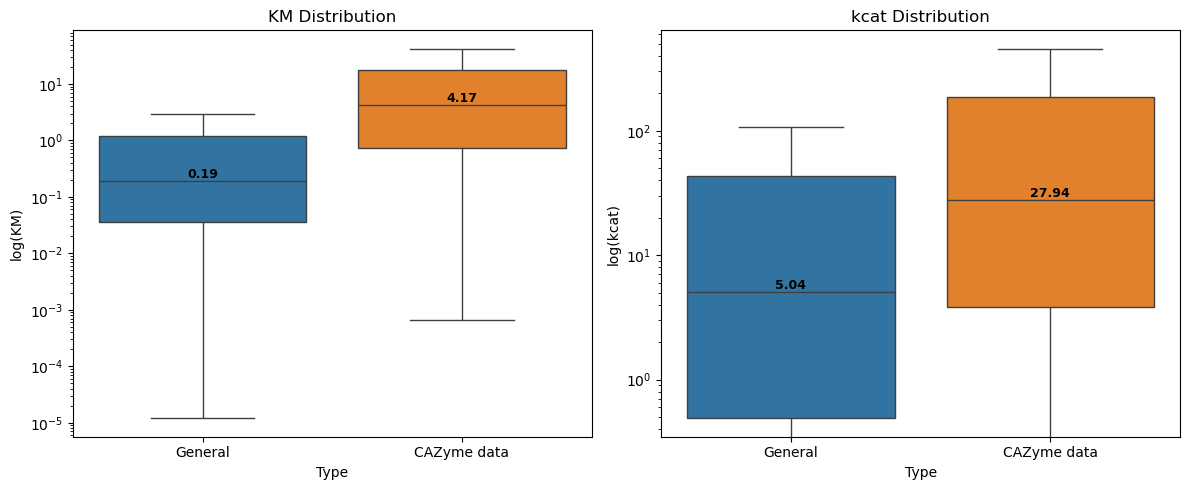

In [23]:
# Define colors for 0 and 1
palette = {0: "#1f77b4", 1: "#ff7f0e"}  # blue for 0, orange for 1
label_map = {0: "General", 1: "CAZyme data"}

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# ---------------- KM plot ----------------
ax = axes[0]
sns.boxplot(
    data=km_clean,
    x="cazyme",
    y="KM_mM",
    hue="cazyme",
    palette=palette,
    dodge=False,   # avoid double boxes
    showfliers=False,
    ax=ax
)

ax.set_yscale("log")

# Add median labels
medians = km_clean.groupby("cazyme")["KM_mM"].median()
for pos, (c, median) in enumerate(medians.items()):
    ax.text(pos, median, f"{median:.2f}", ha='center', va='bottom', fontweight='bold', fontsize=9)

# Fix x-axis ticks and labels
ax.set_xticks(range(len(medians)))
ax.set_xticklabels([label_map[x] for x in sorted(km_clean['cazyme'].unique())])
ax.set_xlabel("Type")
ax.set_ylabel("log(KM)")
ax.set_title("KM Distribution")
ax.get_legend().remove()

# ---------------- kcat plot ----------------
ax = axes[1]
sns.boxplot(
    data=kcat_clean,
    x="cazyme",
    y="Value",
    hue="cazyme",
    palette=palette,
    dodge=False,
    showfliers=False,
    ax=ax
)

ax.set_yscale("log")

# Add median labels
medians = kcat_clean.groupby("cazyme")["Value"].median()
for pos, (c, median) in enumerate(medians.items()):
    ax.text(pos, median, f"{median:.2f}", ha='center', va='bottom', fontweight='bold', fontsize=9)

# x-axis ticks and labels
ax.set_xticks(range(len(medians)))
ax.set_xticklabels([label_map[x] for x in sorted(kcat_clean['cazyme'].unique())])
ax.set_xlabel("Type")
ax.set_ylabel("log(kcat)")
ax.set_title("kcat Distribution")
ax.get_legend().remove()

plt.tight_layout()
plt.savefig("data_exploration/pair_values.png", dpi=300, bbox_inches="tight")
plt.show()

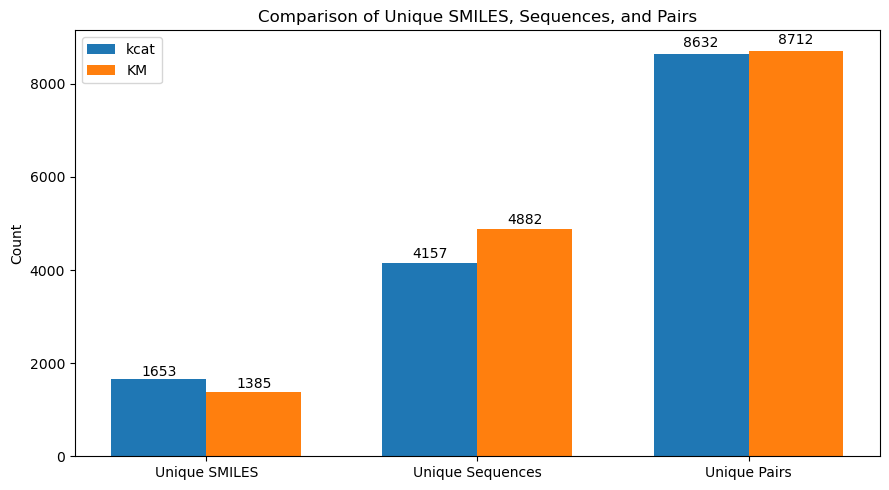

In [22]:
# Compute counts for kcat
kcat_counts = [
    kcat_clean['Smiles'].nunique(),
    kcat_clean['Sequence'].nunique(),
    kcat_clean[['Sequence', 'Smiles']].drop_duplicates().shape[0]
]

# Compute counts for km
km_counts = [
    km_clean['Smiles'].nunique(),  # adjust column name if needed
    km_clean['Sequence'].nunique(),
    km_clean[['Sequence', 'Smiles']].drop_duplicates().shape[0]
]

labels = ['Unique SMILES', 'Unique Sequences', 'Unique Pairs']
x = np.arange(len(labels))  # label locations
width = 0.35  # width of bars

fig, ax = plt.subplots(figsize=(9, 5))

# Side-by-side bars
bars1 = ax.bar(x - width/2, kcat_counts, width, label='kcat')
bars2 = ax.bar(x + width/2, km_counts, width, label='KM')

# Labels and title
ax.set_ylabel("Count")
ax.set_title("Comparison of Unique SMILES, Sequences, and Pairs")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add numbers on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2.,
            height + 0.01*height,
            f'{int(height)}',
            ha='center',
            va='bottom'
        )

plt.tight_layout()
plt.savefig("data_exploration/pair_counts.png", dpi=300, bbox_inches="tight")
plt.show()

In [14]:
# Find duplicate pairs
duplicate_pairs = kcat[kcat.duplicated(subset=['Smiles', 'Sequence'], keep=False)]
duplicate_pairs_km = km[km.duplicated(subset=['smiles', 'Sequence'], keep=False)]

# Count duplicates for each pair
duplicate_counts = duplicate_pairs.groupby(['Smiles', 'Sequence']).size().reset_index(name='Count')
duplicate_counts_km = duplicate_pairs_km.groupby(['smiles', 'Sequence']).size().reset_index(name='Count')

# Keep only pairs with more than 1 occurrence
duplicate_counts = duplicate_counts[duplicate_counts['Count'] > 1]
duplicate_counts_km = duplicate_counts_km[duplicate_counts_km['Count'] > 1]

# For these duplicates, check if they also have duplicate kcat values
duplicate_kcat_counts = duplicate_pairs.groupby(['Smiles', 'Sequence', 'Value']).size().reset_index(name='ValueCount')
duplicate_km_counts = duplicate_pairs_km.groupby(['smiles', 'Sequence', 'KM_mM']).size().reset_index(name='ValueCount')

# Keep only those where the same value appears more than once
duplicate_kcat_counts = duplicate_kcat_counts[duplicate_kcat_counts['ValueCount'] > 1]
duplicate_km_counts = duplicate_km_counts[duplicate_km_counts['ValueCount'] > 1]

print(f"Duplicate (Smiles, Sequence) pairs in kcat data: {len(duplicate_counts)}")
print(f"Duplicate pairs with duplicate kcat values: {len(duplicate_kcat_counts)}")

print(f"\nDuplicate (Smiles, Sequence) pairs in KM data: {len(duplicate_counts_km)}")
print(f"Duplicate pairs with duplicate KM values: {len(duplicate_km_counts)}")

Duplicate (Smiles, Sequence) pairs in kcat data: 421
Duplicate pairs with duplicate kcat values: 135

Duplicate (Smiles, Sequence) pairs in KM data: 252
Duplicate pairs with duplicate KM values: 24


### Dimensionality Reduction

First need to generate all the encoded vectors for the sequences and the smiles

In [15]:
# Helper function: save list to a text file
# Used as input for embedding on the cluster
def save_list_to_txt(list_data, filename):
    with open(filename, 'w') as f:
        for item in list_data:
            f.write(str(item) + '\n')

# Save each list to its own file
save_list_to_txt(kcat_clean['Smiles'].tolist(), '/Users/kevinliu/Desktop/kcat_smiles.txt')
save_list_to_txt(km_clean['Smiles'].tolist(), '/Users/kevinliu/Desktop/km_smiles.txt')
save_list_to_txt(kcat_clean['Sequence'].tolist(), '/Users/kevinliu/Desktop/kcat_sequences.txt')
save_list_to_txt(km_clean['Sequence'].tolist(), '/Users/kevinliu/Desktop/km_sequences.txt')

In [20]:
"""
The following code completes the embeddings for the sequence and smiles data, but due to computational intensity, it was run on the cluster.
Produced ..._merged.npz files (4 files with embeddings)
"""
### use cmd + / to uncomment ###
# import sys
# path = '/Users/kevinliu/Desktop/QBIO 460/Final Project/unikp'
# sys.path.append(path)

# import torch
# from build_vocab import WordVocab
# from pretrain_trfm import TrfmSeq2seq
# from utils import split
# # build_vocab, pretrain_trfm, utils packages are from SMILES Transformer
# from transformers import T5EncoderModel, T5Tokenizer
# # transformers package is from ProtTrans
# import re
# import gc
# import numpy as np
# import pandas as pd
# import pickle
# import math
# import json
# from itertools import product


# def smiles_to_vec(Smiles):
#     pad_index = 0
#     unk_index = 1
#     eos_index = 2
#     sos_index = 3
#     mask_index = 4
#     vocab = WordVocab.load_vocab(f'{path}/vocab.pkl')
#     def get_inputs(sm):
#         seq_len = 220
#         sm = sm.split()
#         if len(sm)>218:
#             print('SMILES is too long ({:d})'.format(len(sm)))
#             sm = sm[:109]+sm[-109:]
#         ids = [vocab.stoi.get(token, unk_index) for token in sm]
#         ids = [sos_index] + ids + [eos_index]
#         seg = [1]*len(ids)
#         padding = [pad_index]*(seq_len - len(ids))
#         ids.extend(padding), seg.extend(padding)
#         return ids, seg
#     def get_array(smiles):
#         x_id, x_seg = [], []
#         for sm in smiles:
#             a,b = get_inputs(sm)
#             x_id.append(a)
#             x_seg.append(b)
#         return torch.tensor(x_id), torch.tensor(x_seg)
#     trfm = TrfmSeq2seq(len(vocab), 256, len(vocab), 4)
#     trfm.load_state_dict(torch.load(f'{path}/trfm_12_23000.pkl', map_location='cpu', weights_only=True))
#     trfm = trfm.to(torch.device('cpu'))
#     trfm.eval()
#     x_split = [split(sm) for sm in Smiles]
#     xid, xseg = get_array(x_split)
#     X = trfm.encode(torch.t(xid))
#     return X

# def Seq_to_vec(Sequence):
#     for i in range(len(Sequence)):
#         if len(Sequence[i]) > 1000:
#             Sequence[i] = Sequence[i][:500] + Sequence[i][-500:]
#     sequences_Example = []
#     for i in range(len(Sequence)):
#         zj = ''
#         for j in range(len(Sequence[i]) - 1):
#             zj += Sequence[i][j] + ' '
#         zj += Sequence[i][-1]
#         sequences_Example.append(zj)
#     ###### you should place downloaded model into this directory.
#     tokenizer = T5Tokenizer.from_pretrained(f"{path}/prot_t5_xl_uniref50", do_lower_case=False,legacy=True)
#     model = T5EncoderModel.from_pretrained(f"{path}/prot_t5_xl_uniref50")
#     gc.collect()
#     print(torch.cuda.is_available())
#     # 'cuda:0' if torch.cuda.is_available() else
#     device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#     model = model.to(device)
#     model = model.eval()
#     features = []
#     for i in range(len(sequences_Example)):
#         print('For sequence ', str(i+1))
#         sequences_Example_i = sequences_Example[i]
#         sequences_Example_i = [re.sub(r"[UZOB]", "X", sequences_Example_i)]
#         ids = tokenizer.batch_encode_plus(sequences_Example_i, add_special_tokens=True, padding=True)
#         input_ids = torch.tensor(ids['input_ids']).to(device)
#         attention_mask = torch.tensor(ids['attention_mask']).to(device)
#         with torch.no_grad():
#             embedding = model(input_ids=input_ids, attention_mask=attention_mask)
#         embedding = embedding.last_hidden_state.cpu().numpy()
#         for seq_num in range(len(embedding)):
#             seq_len = (attention_mask[seq_num] == 1).sum()
#             seq_emd = embedding[seq_num][:seq_len - 1]
#             features.append(seq_emd)
#     features_normalize = np.zeros([len(features), len(features[0][0])], dtype=float)
#     for i in range(len(features)):
#         for k in range(len(features[0][0])):
#             for j in range(len(features[i])):
#                 features_normalize[i][k] += features[i][j][k]
#             features_normalize[i][k] /= len(features[i])
#     return features_normalize

# kcat_smiles_vectors = smiles_to_vec(kcat_cleaned['Smiles'].tolist())
# km_smiles_vectors = smiles_to_vec(km_cleaned['Smiles'].tolist())
# kcat_seq_vectors = Seq_to_vec(kcat_cleaned['Sequence'].tolist())
# km_seq_vectors = Seq_to_vec(km_cleaned['sequence'].tolist())

'\nThe following code completes the embeddings for the sequence and smiles data, but due to computational intensity, it was run on the cluster.\nProduced ..._merged.npz files (4 files with embeddings)\n'

In [16]:
"""
Map embeddings to the correct pairings of substrate and enzymes with their values and CAZyme labels.

Input: 
    - ..._merged.npz files (4 files with embeddings)
    - kcat_clean & km_clean dataframes

Output: 
    - ..._merged_structured.npz files (4 files with aligned embeddings, values, and labels)
"""

# Map npz files to corresponding cleaned DataFrames
files = [
    ('kcat_sequence_vectors_merged.npz', kcat_clean, 'Sequence'),
    ('kcat_smiles_vectors_merged.npz', kcat_clean, 'Smiles'),
    ('km_sequence_vectors_merged.npz', km_clean, 'Sequence'),
    ('km_smiles_vectors_merged.npz', km_clean, 'Smiles')
]

for npz_path, df, key_column in files:
    print(f"\nProcessing: {npz_path}")
    
    # Load npz file
    npz_data = np.load(npz_path, allow_pickle=True)
    embeddings = npz_data['embeddings']
    original_data = npz_data['original_data']
    
    # Determine value column name
    value_col = 'Value' if 'Value' in df.columns else 'KM_mM'
    
    # Check alignment: unique embeddings vs pair-specific embeddings
    if len(embeddings) == df[key_column].nunique():
        # Case 1: One embedding per unique sequence/SMILES (aggregate values)
        print(f"  → {len(embeddings)} unique {key_column} embeddings (averaging values)")
        
        df_aggregated = df.groupby(key_column, as_index=False).agg({
            value_col: 'mean',
            'cazyme': 'first'
        })
        
        df_indexed = df_aggregated.set_index(key_column)
        predictor_values = df_indexed.loc[original_data][value_col].values
        is_cazyme = df_indexed.loc[original_data]['cazyme'].values
        
    elif len(embeddings) == len(df):
        # Case 2: One embedding per (Sequence, SMILES) pair
        print(f"  → {len(embeddings)} pair-specific embeddings")
        
        # Verify order matches (assumes embeddings were created in same order as df)
        assert np.array_equal(original_data, df[key_column].values), \
            f"Order mismatch! Embeddings order doesn't match DataFrame order."
        
        predictor_values = df[value_col].values
        is_cazyme = df['cazyme'].values
        
    else:
        raise ValueError(
            f"Length mismatch! Embeddings: {len(embeddings)}, "
            f"DataFrame rows: {len(df)}, Unique {key_column}s: {df[key_column].nunique()}"
        )
    
    # Verify final alignment
    assert len(embeddings) == len(predictor_values) == len(is_cazyme), \
        f"Alignment failed! Lengths: embeddings={len(embeddings)}, values={len(predictor_values)}, cazyme={len(is_cazyme)}"
    
    # Save structured npz
    out_path = npz_path.replace('.npz', '_structured.npz')
    np.savez(out_path,
             embeddings=embeddings,
             original_seqs=original_data,
             predictor_values=predictor_values,
             is_cazyme=is_cazyme)
    
    # print(f"   Saved: {out_path}")
    # print(f"    Values: mean={predictor_values.mean():.4f}, range=[{predictor_values.min():.4f}, {predictor_values.max():.4f}]")
    # print(f"    CAZymes: {is_cazyme.sum()}/{len(is_cazyme)} ({100*is_cazyme.mean():.1f}%)")


Processing: kcat_sequence_vectors_merged.npz
  → 8632 pair-specific embeddings

Processing: kcat_smiles_vectors_merged.npz
  → 8632 pair-specific embeddings

Processing: km_sequence_vectors_merged.npz
  → 8712 pair-specific embeddings

Processing: km_smiles_vectors_merged.npz
  → 8712 pair-specific embeddings


In [17]:
# Load in computed embeddings
kcat_seq = np.load("kcat_sequence_vectors_merged_structured.npz", allow_pickle=True)
kcat_smiles = np.load("kcat_smiles_vectors_merged_structured.npz", allow_pickle=True)
km_seq = np.load("km_sequence_vectors_merged_structured.npz", allow_pickle=True)
km_smiles = np.load("km_smiles_vectors_merged_structured.npz", allow_pickle=True)

kcat sequence embedding shape: (8632, 1024)
kcat smiles embedding shape: (8632, 1024)
km sequence embedding shape: (8712, 1024)
km smiles embedding shape: (8712, 1024)


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


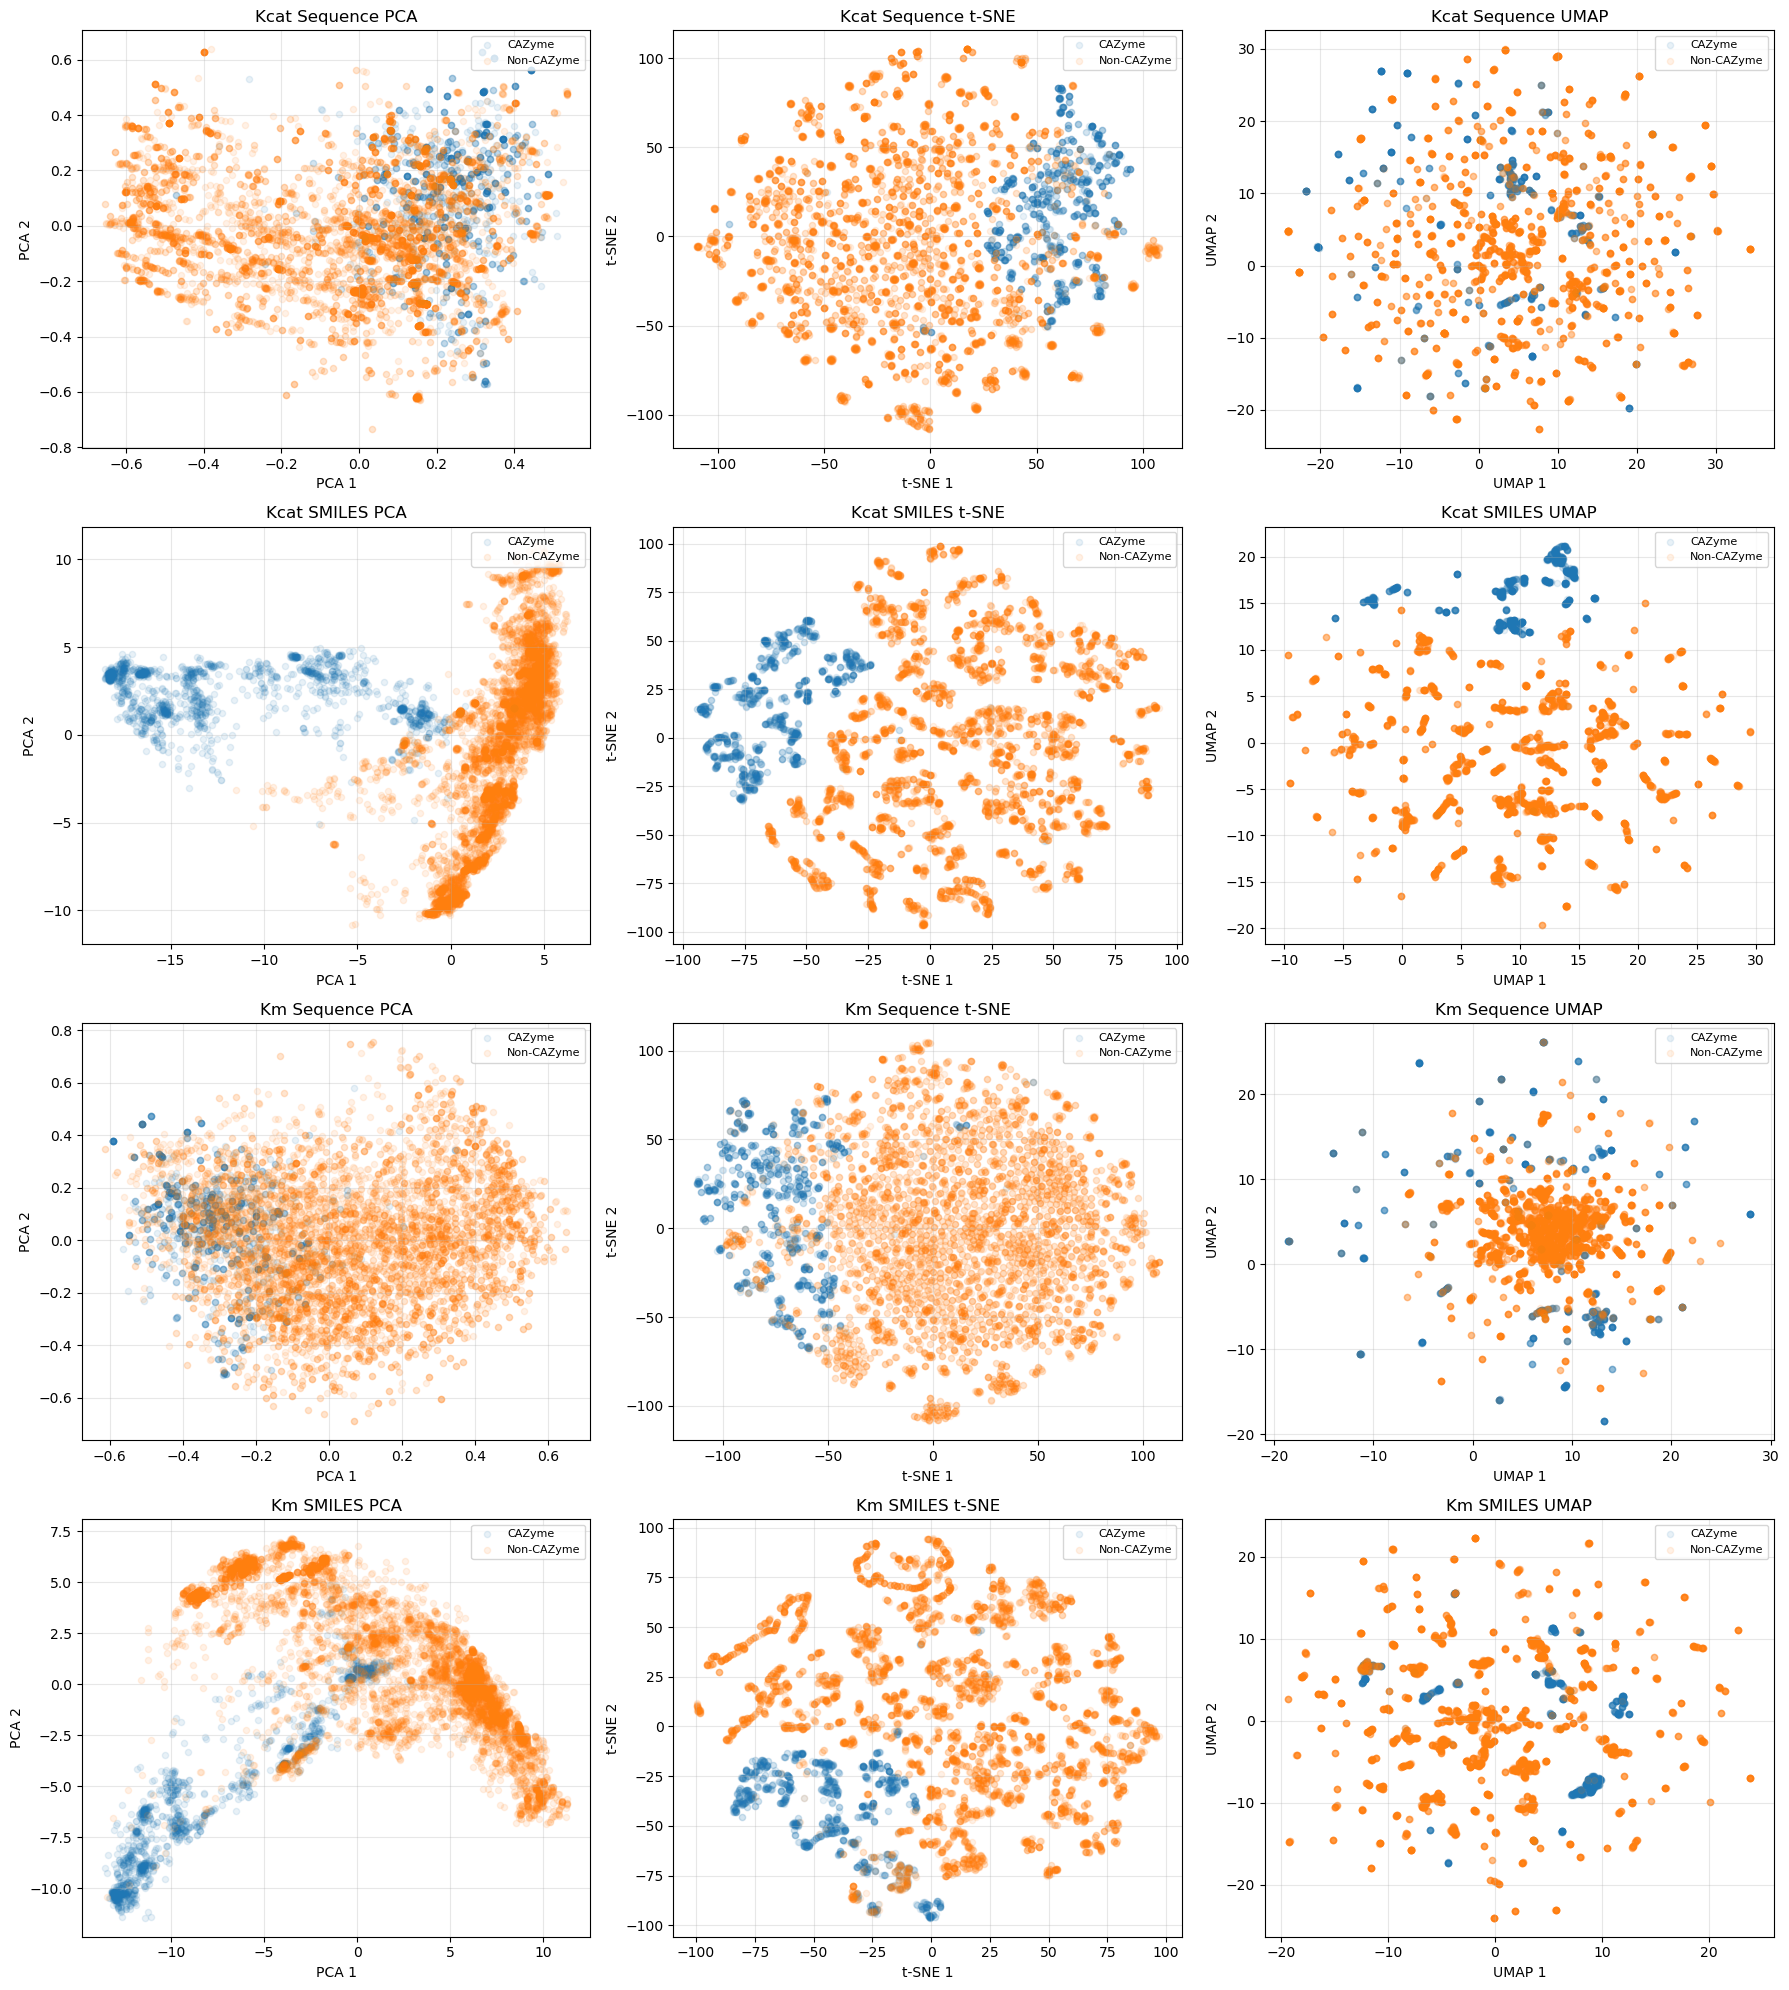

In [24]:
from sklearn.manifold import TSNE
import umap
from sklearn.decomposition import PCA

# Extract embeddings and labels from structured npz files
kcat_seq_emb = kcat_seq['embeddings']
kcat_seq_cazyme = kcat_seq['is_cazyme']

kcat_smiles_emb = kcat_smiles['embeddings']
kcat_smiles_cazyme = kcat_smiles['is_cazyme']

km_seq_emb = km_seq['embeddings']
km_seq_cazyme = km_seq['is_cazyme']

km_smiles_emb = km_smiles['embeddings']
km_smiles_cazyme = km_smiles['is_cazyme']

print("kcat sequence embedding shape:", kcat_seq_emb.shape)
print("kcat smiles embedding shape:", kcat_smiles_emb.shape)
print("km sequence embedding shape:", km_seq_emb.shape)
print("km smiles embedding shape:", km_smiles_emb.shape)

# Function to plot on a given Axes
def plot_embedding(ax, emb, labels, title, method="PCA"):
    if method == "PCA":
        coords = PCA(n_components=2, random_state=42).fit_transform(emb)
        xlabel, ylabel = "PCA 1", "PCA 2"
    elif method == "t-SNE":
        coords = TSNE(n_components=2, random_state=42, init="pca").fit_transform(emb)
        xlabel, ylabel = "t-SNE 1", "t-SNE 2"
    elif method == "UMAP":
        coords = umap.UMAP(n_components=2, random_state=42).fit_transform(emb)
        xlabel, ylabel = "UMAP 1", "UMAP 2"
    
    ax.scatter(coords[labels==1,0], coords[labels==1,1], alpha=0.1, label="CAZyme", s=20)
    ax.scatter(coords[labels==0,0], coords[labels==0,1], alpha=0.1, label="Non-CAZyme", s=20)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper right", fontsize=8)

# Create 4x3 subplot for all four datasets
fig, axes = plt.subplots(4, 3, figsize=(18, 20))

# ------------------------
# Row 0: Kcat Sequence embeddings
# ------------------------
plot_embedding(axes[0,0], kcat_seq_emb, kcat_seq_cazyme, "Kcat Sequence PCA", method="PCA")
plot_embedding(axes[0,1], kcat_seq_emb, kcat_seq_cazyme, "Kcat Sequence t-SNE", method="t-SNE")
plot_embedding(axes[0,2], kcat_seq_emb, kcat_seq_cazyme, "Kcat Sequence UMAP", method="UMAP")

# ------------------------
# Row 1: Kcat SMILES embeddings
# ------------------------
plot_embedding(axes[1,0], kcat_smiles_emb, kcat_smiles_cazyme, "Kcat SMILES PCA", method="PCA")
plot_embedding(axes[1,1], kcat_smiles_emb, kcat_smiles_cazyme, "Kcat SMILES t-SNE", method="t-SNE")
plot_embedding(axes[1,2], kcat_smiles_emb, kcat_smiles_cazyme, "Kcat SMILES UMAP", method="UMAP")

# ------------------------
# Row 2: Km Sequence embeddings
# ------------------------
plot_embedding(axes[2,0], km_seq_emb, km_seq_cazyme, "Km Sequence PCA", method="PCA")
plot_embedding(axes[2,1], km_seq_emb, km_seq_cazyme, "Km Sequence t-SNE", method="t-SNE")
plot_embedding(axes[2,2], km_seq_emb, km_seq_cazyme, "Km Sequence UMAP", method="UMAP")

# ------------------------
# Row 3: Km SMILES embeddings
# ------------------------
plot_embedding(axes[3,0], km_smiles_emb, km_smiles_cazyme, "Km SMILES PCA", method="PCA")
plot_embedding(axes[3,1], km_smiles_emb, km_smiles_cazyme, "Km SMILES t-SNE", method="t-SNE")
plot_embedding(axes[3,2], km_smiles_emb, km_smiles_cazyme, "Km SMILES UMAP", method="UMAP")

plt.tight_layout()
plt.savefig("data_exploration/dim_reduction.png", dpi=300, bbox_inches="tight")
plt.show()

# print("\n--- CAZyme Distribution ---")
# print(f"Kcat Sequence: {kcat_seq_cazyme.sum()} CAZymes / {len(kcat_seq_cazyme)} total ({100*kcat_seq_cazyme.mean():.1f}%)")
# print(f"Kcat SMILES: {kcat_smiles_cazyme.sum()} CAZymes / {len(kcat_smiles_cazyme)} total ({100*kcat_smiles_cazyme.mean():.1f}%)")
# print(f"Km Sequence: {km_seq_cazyme.sum()} CAZymes / {len(km_seq_cazyme)} total ({100*km_seq_cazyme.mean():.1f}%)")
# print(f"Km SMILES: {km_smiles_cazyme.sum()} CAZymes / {len(km_smiles_cazyme)} total ({100*km_smiles_cazyme.mean():.1f}%)")

## 3. Build ExtraTrees Predictive Model

### kcat ExtraTrees Predictions

#### Hyperparameter Tuning

In [45]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import math

def plot_hyperparameter_tuning(grid_search, output_dir):
    """
    Create visualizations for hyperparameter tuning results.
    
    Args:
        grid_search: Fitted GridSearchCV object
        output_dir: Directory to save plots
    """
    cv_results = pd.DataFrame(grid_search.cv_results_)
    
    # Convert negative MAE back to positive for plotting
    cv_results['mean_test_score_positive'] = -cv_results['mean_test_score']
    cv_results['std_test_score'] = cv_results['std_test_score']
    
    # Set style
    sns.set_style("whitegrid")
    
    # 1. Top 20 parameter combinations
    fig, ax = plt.subplots(figsize=(12, 8))
    top_20 = cv_results.nsmallest(20, 'rank_test_score')
    
    y_pos = np.arange(len(top_20))
    ax.barh(y_pos, top_20['mean_test_score_positive'], 
            xerr=top_20['std_test_score'], capsize=3, alpha=0.7)
    
    # Create labels for each configuration
    labels = []
    for idx, row in top_20.iterrows():
        label = f"n_est={row['param_n_estimators']}, depth={row['param_max_depth']}, " \
                f"split={row['param_min_samples_split']}, leaf={row['param_min_samples_leaf']}, " \
                f"feat={row['param_max_features']}"
        labels.append(label)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels, fontsize=8)
    ax.set_xlabel('Mean Absolute Error (MAE)', fontsize=12)
    ax.set_title('kcat Top 20 Hyperparameter Combinations', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.savefig(f'{output_dir}/top_20_hyperparameters.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 2. Effect of individual parameters
    params_to_plot = ['param_n_estimators', 'param_max_depth', 
                      'param_min_samples_split', 'param_min_samples_leaf', 'param_max_features']
    param_names = ['n_estimators', 'max_depth', 'min_samples_split', 
                   'min_samples_leaf', 'max_features']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, (param, name) in enumerate(zip(params_to_plot, param_names)):
        ax = axes[idx]
        
        # Group by parameter and calculate mean and std
        grouped = cv_results.groupby(param).agg({
            'mean_test_score_positive': ['mean', 'std', 'count']
        })
        
        x_vals = grouped.index.tolist()
        y_vals = grouped['mean_test_score_positive']['mean'].values
        y_std = grouped['mean_test_score_positive']['std'].values
        
        # Convert None to string for plotting
        x_labels = [str(x) for x in x_vals]
        x_pos = np.arange(len(x_vals))
        
        ax.bar(x_pos, y_vals, yerr=y_std, capsize=5, alpha=0.7, color='steelblue')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(x_labels, rotation=45, ha='right')
        ax.set_xlabel(name, fontsize=11, fontweight='bold')
        ax.set_ylabel('MAE', fontsize=11)
        ax.set_title(f'Effect of {name}', fontsize=12, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        
        # Highlight best value
        best_idx = np.argmin(y_vals)
        ax.bar(x_pos[best_idx], y_vals[best_idx], 
               yerr=y_std[best_idx], capsize=5, alpha=0.7, color='coral')
    
    # Remove extra subplot
    fig.delaxes(axes[-1])
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/parameter_effects.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 3. Heatmap for n_estimators vs max_depth (most important parameters)
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Pivot table for heatmap
    pivot_data = cv_results.pivot_table(
        values='mean_test_score_positive',
        index='param_max_depth',
        columns='param_n_estimators',
        aggfunc='mean'
    )
    
    sns.heatmap(pivot_data, annot=True, fmt='.4f', cmap='RdYlGn_r', 
                ax=ax, cbar_kws={'label': 'MAE'})
    ax.set_title('kcat Heatmap: n_estimators vs max_depth', fontsize=14, fontweight='bold')
    ax.set_xlabel('n_estimators', fontsize=12)
    ax.set_ylabel('max_depth', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/heatmap_n_estimators_max_depth.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 4. Score distribution
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.hist(cv_results['mean_test_score_positive'], bins=30, alpha=0.7, 
            color='steelblue', edgecolor='black')
    ax.axvline(cv_results['mean_test_score_positive'].min(), 
               color='red', linestyle='--', linewidth=2, label='Best Score')
    ax.set_xlabel('Mean Absolute Error (MAE)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('kcat Distribution of CV Scores Across All Parameter Combinations', 
                 fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/score_distribution.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"\nHyperparameter tuning plots saved to {output_dir}/")
    print(f"  - top_20_hyperparameters.png")
    print(f"  - parameter_effects.png")
    print(f"  - heatmap_n_estimators_max_depth.png")
    print(f"  - score_distribution.png")


def tune_hyperparameters_only(features, labels, metadata_df, output_dir='kcat_tree_tuning', fast_mode=True):
    """
    Perform only hyperparameter tuning with RandomizedSearchCV (no multiple folds).
    
    Args:
        features: Combined embeddings (N, 2048)
        labels: Log10-transformed kcat values (N,)
        metadata_df: DataFrame with sequence, smiles, and CAZyme status
        output_dir: Directory to save results
        fast_mode: If True, uses faster but less comprehensive search
    
    Returns:
        best_params: Dictionary of best hyperparameters
        grid_search: Fitted RandomizedSearchCV object
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    cazyme_status = metadata_df['is_CAZyme'].values
    
    print("=== Hyperparameter Tuning ===")
    
    # Single stratified 80/20 split by CAZyme status
    train_indices, test_indices = train_test_split(
        np.arange(len(features)),
        test_size=0.2,
        stratify=cazyme_status,
        random_state=42
    )
    
    # Create train/test masks
    train_mask = np.zeros(len(features), dtype=bool)
    train_mask[train_indices] = True
    
    # Split data
    X_train, y_train = features[train_mask], labels[train_mask]
    X_test, y_test = features[~train_mask], labels[~train_mask]
    
    # Print split statistics
    train_cazyme = cazyme_status[train_mask]
    test_cazyme = cazyme_status[~train_mask]
    print(f"Train: {len(X_train)} samples ({train_cazyme.sum()} CAZymes, {100*train_cazyme.mean():.1f}%)")
    print(f"Test:  {len(X_test)} samples ({test_cazyme.sum()} CAZymes, {100*test_cazyme.mean():.1f}%)")
    
    print("\nPerforming RandomizedSearchCV for hyperparameter tuning...")
    
    if fast_mode:
        # Faster search with fewer parameters
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [None, 30],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'max_features': ['sqrt', None]
        }
        n_iter = 12  # Test 12 random combinations
        cv_folds = 3
    else:
        # More comprehensive search
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 20, 30, 40],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        }
        n_iter = 30
        cv_folds = 5
    
    print(f"Search mode: {'FAST' if fast_mode else 'COMPREHENSIVE'}")
    print(f"Testing {n_iter} parameter combinations with {cv_folds}-fold CV")
    
    # Create base model
    base_model = ExtraTreesRegressor(random_state=42, n_jobs=-1)
    
    # Use RandomizedSearchCV for faster search
    from sklearn.model_selection import RandomizedSearchCV
    
    grid_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_grid,
        n_iter=n_iter,
        cv=cv_folds,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=2,
        random_state=42
    )
    
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    print(f"\n=== Best Parameters Found ===")
    for param, value in best_params.items():
        print(f"{param}: {value}")
    print(f"\nBest CV MAE: {-grid_search.best_score_:.4f}")
    
    # Evaluate on test set
    y_pred_test = grid_search.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)
    
    print(f"\n=== Test Set Performance ===")
    print(f"MSE: {test_mse:.4f}")
    print(f"MAE: {test_mae:.4f}")
    print(f"R²: {test_r2:.4f}")
    
    # Test set performance by CAZyme status
    cazyme_test_mask = test_cazyme.astype(bool)
    if cazyme_test_mask.sum() > 0:
        cazyme_mae = mean_absolute_error(y_test[cazyme_test_mask], y_pred_test[cazyme_test_mask])
        cazyme_r2 = r2_score(y_test[cazyme_test_mask], y_pred_test[cazyme_test_mask])
        print(f"CAZyme - MAE: {cazyme_mae:.4f}, R²: {cazyme_r2:.4f}")
        
    if (~cazyme_test_mask).sum() > 0:
        non_cazyme_mae = mean_absolute_error(y_test[~cazyme_test_mask], y_pred_test[~cazyme_test_mask])
        non_cazyme_r2 = r2_score(y_test[~cazyme_test_mask], y_pred_test[~cazyme_test_mask])
        print(f"Non-CAZyme - MAE: {non_cazyme_mae:.4f}, R²: {non_cazyme_r2:.4f}")
    
    # Save grid search results
    cv_results_df = pd.DataFrame(grid_search.cv_results_)
    cv_results_df.to_csv(f'{output_dir}/gridsearch_results.csv', index=False)
    
    # Create hyperparameter tuning plots
    plot_hyperparameter_tuning(grid_search, output_dir)
    
    # Save best parameters
    with open(f'{output_dir}/best_params.txt', 'w') as f:
        f.write("Best Hyperparameters:\n")
        for param, value in best_params.items():
            f.write(f"{param}: {value}\n")
        f.write(f"\nBest CV MAE: {-grid_search.best_score_:.4f}\n")
        f.write(f"Test MAE: {test_mae:.4f}\n")
        f.write(f"Test R²: {test_r2:.4f}\n")
    
    # Save predictions
    y_pred_all = grid_search.predict(features)
    results_df = metadata_df.copy()
    results_df['Label'] = labels
    results_df['Predicted_Label'] = y_pred_all
    results_df['Training_or_Test'] = ['Train' if m else 'Test' for m in train_mask]
    results_df.to_excel(f'{output_dir}/predictions.xlsx', index=False)
    
    return best_params, grid_search


if __name__ == '__main__':
    # Load pre-computed embeddings
    print("Loading embeddings...")
    kcat_seq = np.load("kcat_sequence_vectors_merged_structured.npz", allow_pickle=True)
    kcat_smiles = np.load("kcat_smiles_vectors_merged_structured.npz", allow_pickle=True)
    
    # Extract data
    seq_embeddings = kcat_seq['embeddings']
    smiles_embeddings = kcat_smiles['embeddings']
    kcat_values = kcat_seq['predictor_values']
    sequences = kcat_seq['original_seqs']
    smiles = kcat_smiles['original_seqs']
    is_cazyme = kcat_seq['is_cazyme']
    
    print(f"Loaded {len(kcat_values)} samples")
    print(f"Sequence embeddings: {seq_embeddings.shape}")
    print(f"SMILES embeddings: {smiles_embeddings.shape}")
    
    # Combine features (concatenate SMILES + sequence, matching original order)
    combined_features = np.concatenate([smiles_embeddings, seq_embeddings], axis=1)
    print(f"Combined features: {combined_features.shape}")
    
    # Convert to log10 scale (matching original code)
    log_kcat = np.array([
        -10000000000 if val == 0 else math.log(val, 10) 
        for val in kcat_values
    ])
    
    # Filter out invalid values and SMILES with '.' (salts/mixtures)
    valid_mask = (log_kcat > -10000000000) & np.array(['.' not in s for s in smiles])
    
    features_filtered = combined_features[valid_mask]
    labels_filtered = log_kcat[valid_mask]
    sequences_filtered = sequences[valid_mask]
    smiles_filtered = smiles[valid_mask]
    cazyme_filtered = is_cazyme[valid_mask]
    
    print(f"\nAfter filtering:")
    print(f"Valid samples: {len(labels_filtered)}")
    print(f"Label range: [{labels_filtered.min():.4f}, {labels_filtered.max():.4f}]")
    print(f"CAZymes: {cazyme_filtered.sum()} ({100*cazyme_filtered.mean():.1f}%)")
    print(f"Non-CAZymes: {(~cazyme_filtered).sum()} ({100*(~cazyme_filtered).mean():.1f}%)")
    
    # Create metadata DataFrame
    metadata_df = pd.DataFrame({
        'Sequence': sequences_filtered,
        'SMILES': smiles_filtered,
        'is_CAZyme': cazyme_filtered
    })
    
    # Perform hyperparameter tuning only (no multiple folds)
    best_params, grid_search = tune_hyperparameters_only(
        features_filtered, 
        labels_filtered, 
        metadata_df,
        output_dir='PreKcat_tuning_results',
        fast_mode=True  # Set to False for more comprehensive search
    )
    
    print(f"\n=== Hyperparameter Tuning Complete ===")
    print("Results saved to 'PreKcat_tuning_results/' directory")

Loading embeddings...
Loaded 8632 samples
Sequence embeddings: (8632, 1024)
SMILES embeddings: (8632, 1024)
Combined features: (8632, 2048)

After filtering:
Valid samples: 8519
Label range: [-5.5253, 8.2041]
CAZymes: 1515 (17.8%)
Non-CAZymes: -10034 (-117.8%)
=== Hyperparameter Tuning ===
Train: 6815 samples (1212 CAZymes, 17.8%)
Test:  1704 samples (303 CAZymes, 17.8%)

Performing RandomizedSearchCV for hyperparameter tuning...
Search mode: FAST
Testing 12 parameter combinations with 3-fold CV
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END max_depth=30, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 3.2min
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   9.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  11.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_spli

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.



=== Best Parameters Found ===
n_estimators: 100
min_samples_split: 2
min_samples_leaf: 1
max_features: None
max_depth: 30

Best CV MAE: 1.0567

=== Test Set Performance ===
MSE: 0.7382
MAE: 0.5746
R²: 0.6700
CAZyme - MAE: 0.4352, R²: 0.6300
Non-CAZyme - MAE: 0.6048, R²: 0.6573

Hyperparameter tuning plots saved to PreKcat_tuning_results/
  - top_20_hyperparameters.png
  - parameter_effects.png
  - heatmap_n_estimators_max_depth.png
  - score_distribution.png

=== Hyperparameter Tuning Complete ===
Results saved to 'PreKcat_tuning_results/' directory
[CV] END max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 4.3min
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 5.8min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_s

#### Best model

In [46]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import math

def Kcat_predict(features, labels, metadata_df, n_folds=10, output_dir='results'):
    """
    Train ExtraTreesRegressor with stratified 80/20 train/test splits based on CAZyme status.
    
    Args:
        features: Combined embeddings (N, 2048)
        labels: Log10-transformed kcat values (N,)
        metadata_df: DataFrame with sequence, smiles, and CAZyme status
        n_folds: Number of random train/test splits
        output_dir: Directory to save results
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    all_results = []
    cazyme_status = metadata_df['is_CAZyme'].values
    
    for fold in range(n_folds):
        print(f"\n=== Fold {fold + 1}/{n_folds} ===")
        
        # Stratified 80/20 split by CAZyme status
        train_indices, test_indices = train_test_split(
            np.arange(len(features)),
            test_size=0.2,
            stratify=cazyme_status,
            random_state=fold
        )
        
        # Create train/test masks
        train_mask = np.zeros(len(features), dtype=bool)
        train_mask[train_indices] = True
        
        # Split data
        X_train, y_train = features[train_mask], labels[train_mask]
        X_test, y_test = features[~train_mask], labels[~train_mask]
        
        # Print split statistics
        train_cazyme = cazyme_status[train_mask]
        test_cazyme = cazyme_status[~train_mask]
        print(f"Train: {len(X_train)} samples ({train_cazyme.sum()} CAZymes, {100*train_cazyme.mean():.1f}%)")
        print(f"Test:  {len(X_test)} samples ({test_cazyme.sum()} CAZymes, {100*test_cazyme.mean():.1f}%)")
        
        # Train model
        model = ExtraTreesRegressor(
                    n_estimators=100,
                    min_samples_split=2,
                    min_samples_leaf=1,
                    max_features=None,
                    max_depth=30,
                    random_state=fold,
                    n_jobs=-1
                )
        model.fit(X_train, y_train)
        
        # Predict on all data
        y_pred_all = model.predict(features)
        
        # Calculate metrics on test set
        y_pred_test = y_pred_all[~train_mask]
        mse = mean_squared_error(y_test, y_pred_test)
        mae = mean_absolute_error(y_test, y_pred_test)
        r2 = r2_score(y_test, y_pred_test)
        
        # Calculate metrics separately for CAZyme and non-CAZyme in test set
        cazyme_test_mask = test_cazyme.astype(bool)
        if cazyme_test_mask.sum() > 0:
            cazyme_mae = mean_absolute_error(y_test[cazyme_test_mask], y_pred_test[cazyme_test_mask])
            cazyme_r2 = r2_score(y_test[cazyme_test_mask], y_pred_test[cazyme_test_mask])
        else:
            cazyme_mae, cazyme_r2 = np.nan, np.nan
            
        if (~cazyme_test_mask).sum() > 0:
            non_cazyme_mae = mean_absolute_error(y_test[~cazyme_test_mask], y_pred_test[~cazyme_test_mask])
            non_cazyme_r2 = r2_score(y_test[~cazyme_test_mask], y_pred_test[~cazyme_test_mask])
        else:
            non_cazyme_mae, non_cazyme_r2 = np.nan, np.nan
        
        print(f"Overall - MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
        print(f"CAZyme  - MAE: {cazyme_mae:.4f}, R²: {cazyme_r2:.4f}")
        print(f"Non-CAZyme - MAE: {non_cazyme_mae:.4f}, R²: {non_cazyme_r2:.4f}")
        
        # Save results
        results_df = metadata_df.copy()
        results_df['Label'] = labels
        results_df['Predicted_Label'] = y_pred_all
        results_df['Training_or_Test'] = ['Train' if m else 'Test' for m in train_mask]
        results_df.to_excel(f'{output_dir}/fold_{fold + 1}_predictions.xlsx', index=False)
        
        all_results.append({
            'fold': fold + 1,
            'test_mse': mse,
            'test_mae': mae,
            'test_r2': r2,
            'cazyme_test_mae': cazyme_mae,
            'cazyme_test_r2': cazyme_r2,
            'non_cazyme_test_mae': non_cazyme_mae,
            'non_cazyme_test_r2': non_cazyme_r2,
            'train_size': len(X_train),
            'test_size': len(X_test)
        })
    
    # Save summary statistics
    summary_df = pd.DataFrame(all_results)
    summary_df.to_csv(f'{output_dir}/summary_metrics.csv', index=False)
    print(f"\n=== Summary across {n_folds} folds ===")
    print(summary_df.describe())
    
    return summary_df


if __name__ == '__main__':
    # Load pre-computed embeddings
    print("Loading embeddings...")
    kcat_seq = np.load("kcat_sequence_vectors_merged_structured.npz", allow_pickle=True)
    kcat_smiles = np.load("kcat_smiles_vectors_merged_structured.npz", allow_pickle=True)
    
    # Extract data
    seq_embeddings = kcat_seq['embeddings']
    smiles_embeddings = kcat_smiles['embeddings']
    kcat_values = kcat_seq['predictor_values']
    sequences = kcat_seq['original_seqs']
    smiles = kcat_smiles['original_seqs']
    is_cazyme = kcat_seq['is_cazyme']
    
    print(f"Loaded {len(kcat_values)} samples")
    print(f"Sequence embeddings: {seq_embeddings.shape}")
    print(f"SMILES embeddings: {smiles_embeddings.shape}")
    
    # Combine features (concatenate SMILES + sequence, matching original order)
    combined_features = np.concatenate([smiles_embeddings, seq_embeddings], axis=1)
    print(f"Combined features: {combined_features.shape}")
    
    # Convert to log10 scale (matching original code)
    log_kcat = np.array([
        -10000000000 if val == 0 else math.log(val, 10) 
        for val in kcat_values
    ])
    
    # Filter out invalid values and SMILES with '.' (salts/mixtures)
    valid_mask = (log_kcat > -10000000000) & np.array(['.' not in s for s in smiles])
    
    features_filtered = combined_features[valid_mask]
    labels_filtered = log_kcat[valid_mask]
    sequences_filtered = sequences[valid_mask]
    smiles_filtered = smiles[valid_mask]
    cazyme_filtered = is_cazyme[valid_mask]
    
    print(f"\nAfter filtering:")
    print(f"Valid samples: {len(labels_filtered)}")
    print(f"Label range: [{labels_filtered.min():.4f}, {labels_filtered.max():.4f}]")
    print(f"CAZymes: {cazyme_filtered.sum()} ({100*cazyme_filtered.mean():.1f}%)")
    print(f"Non-CAZymes: {(~cazyme_filtered).sum()} ({100*(~cazyme_filtered).mean():.1f}%)")
    
    # Create metadata DataFrame
    metadata_df = pd.DataFrame({
        'Sequence': sequences_filtered,
        'SMILES': smiles_filtered,
        'is_CAZyme': cazyme_filtered
    })
    
    # Train and evaluate models with stratified splits
    summary = Kcat_predict(
        features_filtered, 
        labels_filtered, 
        metadata_df,
        n_folds=10,
        output_dir='PreKcat_results'
    )

Loading embeddings...
Loaded 8632 samples
Sequence embeddings: (8632, 1024)
SMILES embeddings: (8632, 1024)
Combined features: (8632, 2048)

After filtering:
Valid samples: 8519
Label range: [-5.5253, 8.2041]
CAZymes: 1515 (17.8%)
Non-CAZymes: -10034 (-117.8%)

=== Fold 1/10 ===
Train: 6815 samples (1212 CAZymes, 17.8%)
Test:  1704 samples (303 CAZymes, 17.8%)
Overall - MSE: 0.8391, MAE: 0.6101, R²: 0.6481
CAZyme  - MAE: 0.4817, R²: 0.6390
Non-CAZyme - MAE: 0.6378, R²: 0.6302

=== Fold 2/10 ===
Train: 6815 samples (1212 CAZymes, 17.8%)
Test:  1704 samples (303 CAZymes, 17.8%)
Overall - MSE: 0.7143, MAE: 0.5639, R²: 0.6770
CAZyme  - MAE: 0.4903, R²: 0.5573
Non-CAZyme - MAE: 0.5799, R²: 0.6803

=== Fold 3/10 ===
Train: 6815 samples (1212 CAZymes, 17.8%)
Test:  1704 samples (303 CAZymes, 17.8%)
Overall - MSE: 0.7277, MAE: 0.5682, R²: 0.6830
CAZyme  - MAE: 0.4790, R²: 0.6415
Non-CAZyme - MAE: 0.5875, R²: 0.6717

=== Fold 4/10 ===
Train: 6815 samples (1212 CAZymes, 17.8%)
Test:  1704 sample

Loaded 85190 total predictions (17040 test, 68150 train)


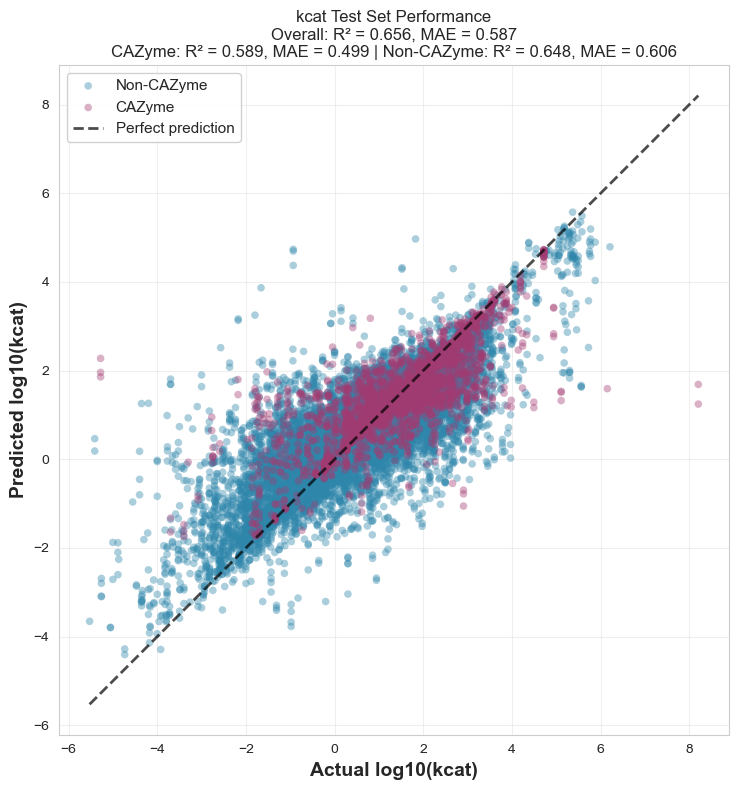

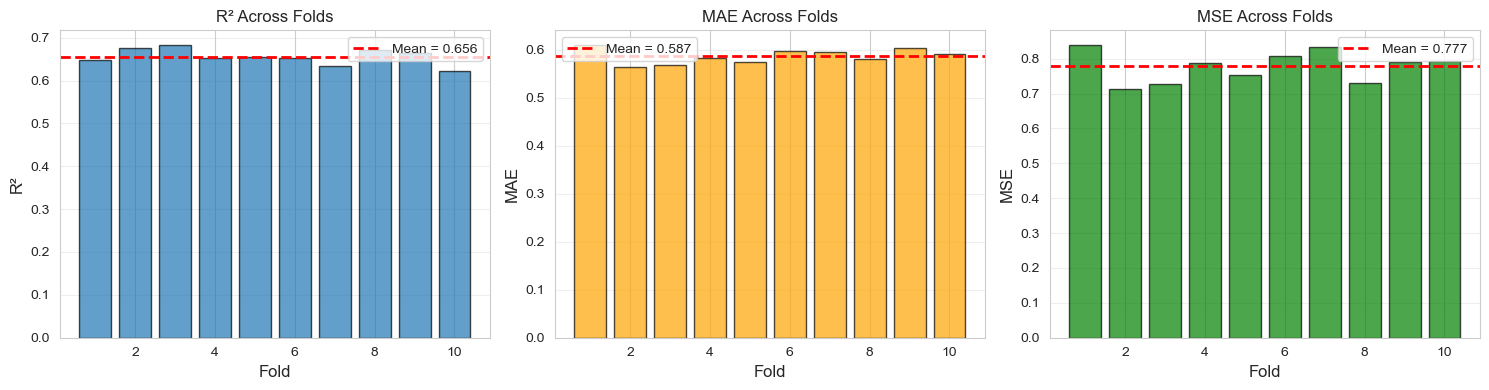

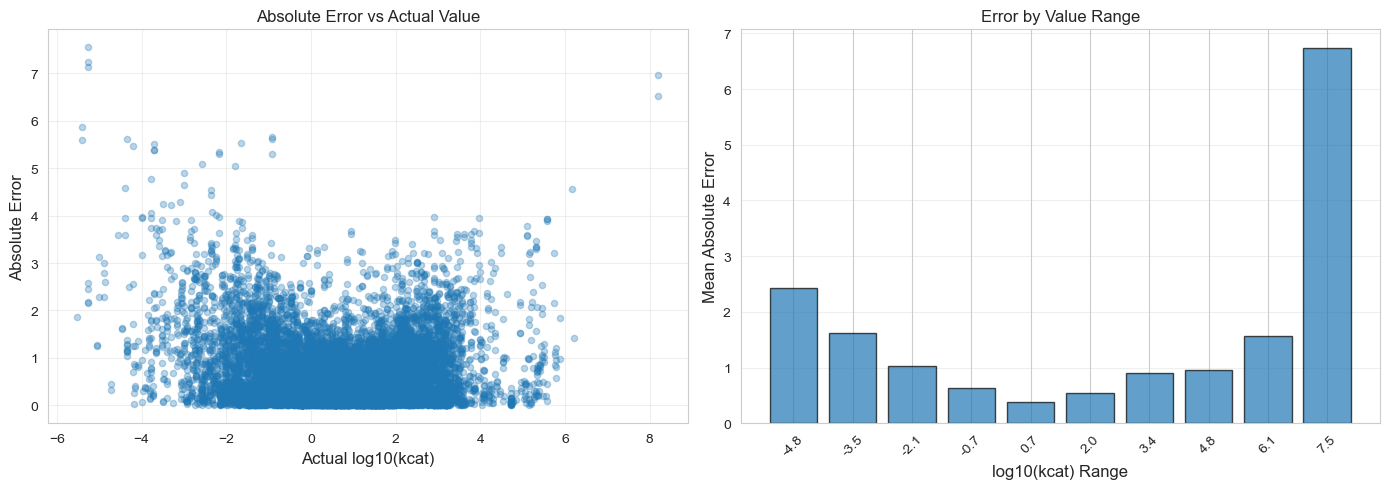

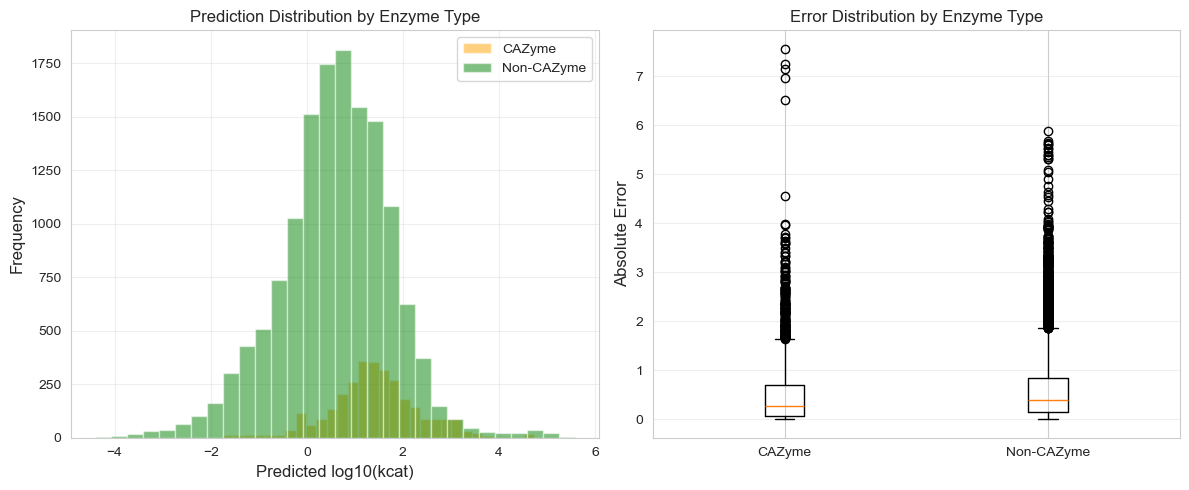


SUMMARY STATISTICS

Test Set Performance:
  R² Score:    0.6561
  MAE:         0.5868
  MSE:         0.7774
  RMSE:        0.8817

CAZyme Performance (n=3030):
  R² Score:    0.5894
  MAE:         0.4986

Non-CAZyme Performance (n=14010):
  R² Score:    0.6485
  MAE:         0.6059

Performance Across Folds:
  R² Mean ± Std:   0.6559 ± 0.0188
  MAE Mean ± Std:  0.5868 ± 0.0152


In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats

def plot_kcat_model_performance(results_dir='PreKcat_results', output_dir='plots'):
    """
    Generate comprehensive plots to analyze ExtraTreesRegressor performance.
    
    Args:
        results_dir: Directory containing fold prediction Excel files
        output_dir: Directory to save plots
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    # Load all fold results
    all_folds = []
    for i in range(1, 11):  # 10 folds
        try:
            df = pd.read_excel(f'{results_dir}/fold_{i}_predictions.xlsx')
            df['fold'] = i
            all_folds.append(df)
        except FileNotFoundError:
            print(f"Warning: fold_{i}_predictions.xlsx not found")
    
    if not all_folds:
        print("No results found!")
        return
    
    # Combine all folds
    all_data = pd.concat(all_folds, ignore_index=True)
    
    # Separate train and test
    test_data = all_data[all_data['Training_or_Test'] == 'Test']
    train_data = all_data[all_data['Training_or_Test'] == 'Train']
    
    print(f"Loaded {len(all_data)} total predictions ({len(test_data)} test, {len(train_data)} train)")
    
    # =====================================================
    # 1. PREDICTED VS ACTUAL (PARITY PLOT) - Most Important
    # =====================================================
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    # Separate CAZyme and Non-CAZyme
    cazyme_test = test_data[test_data['is_CAZyme'] == 1]
    non_cazyme_test = test_data[test_data['is_CAZyme'] == 0]
    
    # Plot both on same axes
    ax.scatter(non_cazyme_test['Label'], non_cazyme_test['Predicted_Label'], 
               alpha=0.4, s=30, color='#2E86AB', label='Non-CAZyme', edgecolors='none')
    ax.scatter(cazyme_test['Label'], cazyme_test['Predicted_Label'], 
               alpha=0.4, s=30, color='#A23B72', label='CAZyme', edgecolors='none')
    
    # Perfect prediction line
    min_val = test_data['Label'].min()
    max_val = test_data['Label'].max()
    ax.plot([min_val, max_val], [min_val, max_val], 
            'k--', lw=2, label='Perfect prediction', alpha=0.7)
    
    # Calculate metrics
    r2 = r2_score(test_data['Label'], test_data['Predicted_Label'])
    mae = mean_absolute_error(test_data['Label'], test_data['Predicted_Label'])
    r2_caz = r2_score(cazyme_test['Label'], cazyme_test['Predicted_Label'])
    mae_caz = mean_absolute_error(cazyme_test['Label'], cazyme_test['Predicted_Label'])
    r2_non = r2_score(non_cazyme_test['Label'], non_cazyme_test['Predicted_Label'])
    mae_non = mean_absolute_error(non_cazyme_test['Label'], non_cazyme_test['Predicted_Label'])
    
    ax.set_xlabel('Actual log10(kcat)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Predicted log10(kcat)', fontsize=14, fontweight='bold')
    ax.set_title(f'kcat Test Set Performance\n' + 
                 f'Overall: R² = {r2:.3f}, MAE = {mae:.3f}\n' +
                 f'CAZyme: R² = {r2_caz:.3f}, MAE = {mae_caz:.3f} | ' +
                 f'Non-CAZyme: R² = {r2_non:.3f}, MAE = {mae_non:.3f}',
                 fontsize=12)
    ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/1_parity_plot.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # =====================================================
    # 2. PERFORMANCE ACROSS FOLDS
    # =====================================================
    fold_metrics = []
    for fold_num in test_data['fold'].unique():
        fold_test = test_data[test_data['fold'] == fold_num]
        fold_metrics.append({
            'fold': fold_num,
            'R2': r2_score(fold_test['Label'], fold_test['Predicted_Label']),
            'MAE': mean_absolute_error(fold_test['Label'], fold_test['Predicted_Label']),
            'MSE': mean_squared_error(fold_test['Label'], fold_test['Predicted_Label'])
        })
    fold_df = pd.DataFrame(fold_metrics)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # R² across folds
    ax = axes[0]
    ax.bar(fold_df['fold'], fold_df['R2'], alpha=0.7, edgecolor='black')
    ax.axhline(y=fold_df['R2'].mean(), color='r', linestyle='--', lw=2, 
               label=f'Mean = {fold_df["R2"].mean():.3f}')
    ax.set_xlabel('Fold', fontsize=12)
    ax.set_ylabel('R²', fontsize=12)
    ax.set_title('R² Across Folds', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # MAE across folds
    ax = axes[1]
    ax.bar(fold_df['fold'], fold_df['MAE'], alpha=0.7, color='orange', edgecolor='black')
    ax.axhline(y=fold_df['MAE'].mean(), color='r', linestyle='--', lw=2,
               label=f'Mean = {fold_df["MAE"].mean():.3f}')
    ax.set_xlabel('Fold', fontsize=12)
    ax.set_ylabel('MAE', fontsize=12)
    ax.set_title('MAE Across Folds', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # MSE across folds
    ax = axes[2]
    ax.bar(fold_df['fold'], fold_df['MSE'], alpha=0.7, color='green', edgecolor='black')
    ax.axhline(y=fold_df['MSE'].mean(), color='r', linestyle='--', lw=2,
               label=f'Mean = {fold_df["MSE"].mean():.3f}')
    ax.set_xlabel('Fold', fontsize=12)
    ax.set_ylabel('MSE', fontsize=12)
    ax.set_title('MSE Across Folds', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/2_fold_performance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # =====================================================
    # 3. ERROR DISTRIBUTION BY MAGNITUDE
    # =====================================================
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Calculate residuals and absolute error
    test_residuals = test_data['Label'] - test_data['Predicted_Label']
    test_abs_error = np.abs(test_residuals)
    
    # Absolute error vs actual value
    ax = axes[0]
    ax.scatter(test_data['Label'], test_abs_error, alpha=0.3, s=20)
    ax.set_xlabel('Actual log10(kcat)', fontsize=12)
    ax.set_ylabel('Absolute Error', fontsize=12)
    ax.set_title('Absolute Error vs Actual Value', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Error by value range
    ax = axes[1]
    bins = pd.cut(test_data['Label'], bins=10)
    error_by_bin = test_data.groupby(bins)['Label'].apply(
        lambda x: np.abs(test_data.loc[x.index, 'Label'] - 
                        test_data.loc[x.index, 'Predicted_Label']).mean()
    )
    bin_centers = [interval.mid for interval in error_by_bin.index]
    ax.bar(range(len(error_by_bin)), error_by_bin.values, alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(error_by_bin)))
    ax.set_xticklabels([f'{c:.1f}' for c in bin_centers], rotation=45)
    ax.set_xlabel('log10(kcat) Range', fontsize=12)
    ax.set_ylabel('Mean Absolute Error', fontsize=12)
    ax.set_title('Error by Value Range', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/3_error_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # =====================================================
    # 4. CAZYME VS NON-CAZYME COMPARISON
    # =====================================================
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Distribution of predictions
    ax = axes[0]
    ax.hist(cazyme_test['Predicted_Label'], bins=30, alpha=0.5, label='CAZyme', color='orange')
    ax.hist(non_cazyme_test['Predicted_Label'], bins=30, alpha=0.5, label='Non-CAZyme', color='green')
    ax.set_xlabel('Predicted log10(kcat)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Prediction Distribution by Enzyme Type', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Box plot of errors
    ax = axes[1]
    cazyme_errors = np.abs(cazyme_test['Label'] - cazyme_test['Predicted_Label'])
    non_cazyme_errors = np.abs(non_cazyme_test['Label'] - non_cazyme_test['Predicted_Label'])
    ax.boxplot([cazyme_errors, non_cazyme_errors], labels=['CAZyme', 'Non-CAZyme'])
    ax.set_ylabel('Absolute Error', fontsize=12)
    ax.set_title('Error Distribution by Enzyme Type', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/4_cazyme_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # =====================================================
    # Print Summary Statistics
    # =====================================================
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    print(f"\nTest Set Performance:")
    print(f"  R² Score:    {r2:.4f}")
    print(f"  MAE:         {mae:.4f}")
    print(f"  MSE:         {mean_squared_error(test_data['Label'], test_data['Predicted_Label']):.4f}")
    print(f"  RMSE:        {np.sqrt(mean_squared_error(test_data['Label'], test_data['Predicted_Label'])):.4f}")
    
    print(f"\nCAZyme Performance (n={len(cazyme_test)}):")
    print(f"  R² Score:    {r2_caz:.4f}")
    print(f"  MAE:         {mae_caz:.4f}")
    
    print(f"\nNon-CAZyme Performance (n={len(non_cazyme_test)}):")
    print(f"  R² Score:    {r2_non:.4f}")
    print(f"  MAE:         {mae_non:.4f}")
    
    print(f"\nPerformance Across Folds:")
    print(f"  R² Mean ± Std:   {fold_df['R2'].mean():.4f} ± {fold_df['R2'].std():.4f}")
    print(f"  MAE Mean ± Std:  {fold_df['MAE'].mean():.4f} ± {fold_df['MAE'].std():.4f}")
    print("="*60)


if __name__ == '__main__':
    # Generate all plots
    plot_kcat_model_performance(results_dir='PreKcat_results', output_dir='kcat_performance_plots')

### Km ExtraTrees Predictions

#### Hyperparameter Tuning

In [48]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

def plot_hyperparameter_tuning(grid_search, output_dir):
    """
    Create visualizations for hyperparameter tuning results.
    
    Args:
        grid_search: Fitted GridSearchCV object
        output_dir: Directory to save plots
    """
    cv_results = pd.DataFrame(grid_search.cv_results_)
    
    # Convert negative MAE back to positive for plotting
    cv_results['mean_test_score_positive'] = -cv_results['mean_test_score']
    cv_results['std_test_score'] = cv_results['std_test_score']
    
    # Set style
    sns.set_style("whitegrid")
    
    # 1. Top 20 parameter combinations
    fig, ax = plt.subplots(figsize=(12, 8))
    top_20 = cv_results.nsmallest(20, 'rank_test_score')
    
    y_pos = np.arange(len(top_20))
    ax.barh(y_pos, top_20['mean_test_score_positive'], 
            xerr=top_20['std_test_score'], capsize=3, alpha=0.7)
    
    # Create labels for each configuration
    labels = []
    for idx, row in top_20.iterrows():
        label = f"n_est={row['param_n_estimators']}, depth={row['param_max_depth']}, " \
                f"split={row['param_min_samples_split']}, leaf={row['param_min_samples_leaf']}, " \
                f"feat={row['param_max_features']}"
        labels.append(label)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels, fontsize=8)
    ax.set_xlabel('Mean Absolute Error (MAE)', fontsize=12)
    ax.set_title('Km Top 20 Hyperparameter Combinations', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.savefig(f'{output_dir}/top_20_hyperparameters.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 2. Effect of individual parameters
    params_to_plot = ['param_n_estimators', 'param_max_depth', 
                      'param_min_samples_split', 'param_min_samples_leaf', 'param_max_features']
    param_names = ['n_estimators', 'max_depth', 'min_samples_split', 
                   'min_samples_leaf', 'max_features']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, (param, name) in enumerate(zip(params_to_plot, param_names)):
        ax = axes[idx]
        
        # Group by parameter and calculate mean and std
        grouped = cv_results.groupby(param).agg({
            'mean_test_score_positive': ['mean', 'std', 'count']
        })
        
        x_vals = grouped.index.tolist()
        y_vals = grouped['mean_test_score_positive']['mean'].values
        y_std = grouped['mean_test_score_positive']['std'].values
        
        # Convert None to string for plotting
        x_labels = [str(x) for x in x_vals]
        x_pos = np.arange(len(x_vals))
        
        ax.bar(x_pos, y_vals, yerr=y_std, capsize=5, alpha=0.7, color='steelblue')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(x_labels, rotation=45, ha='right')
        ax.set_xlabel(name, fontsize=11, fontweight='bold')
        ax.set_ylabel('MAE', fontsize=11)
        ax.set_title(f'Effect of {name}', fontsize=12, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        
        # Highlight best value
        best_idx = np.argmin(y_vals)
        ax.bar(x_pos[best_idx], y_vals[best_idx], 
               yerr=y_std[best_idx], capsize=5, alpha=0.7, color='coral')
    
    # Remove extra subplot
    fig.delaxes(axes[-1])
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/parameter_effects.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 3. Heatmap for n_estimators vs max_depth (most important parameters)
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Pivot table for heatmap
    pivot_data = cv_results.pivot_table(
        values='mean_test_score_positive',
        index='param_max_depth',
        columns='param_n_estimators',
        aggfunc='mean'
    )
    
    sns.heatmap(pivot_data, annot=True, fmt='.4f', cmap='RdYlGn_r', 
                ax=ax, cbar_kws={'label': 'MAE'})
    ax.set_title('Km Heatmap: n_estimators vs max_depth', fontsize=14, fontweight='bold')
    ax.set_xlabel('n_estimators', fontsize=12)
    ax.set_ylabel('max_depth', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/heatmap_n_estimators_max_depth.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 4. Score distribution
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.hist(cv_results['mean_test_score_positive'], bins=30, alpha=0.7, 
            color='steelblue', edgecolor='black')
    ax.axvline(cv_results['mean_test_score_positive'].min(), 
               color='red', linestyle='--', linewidth=2, label='Best Score')
    ax.set_xlabel('Mean Absolute Error (MAE)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Km Distribution of CV Scores Across All Parameter Combinations', 
                 fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/score_distribution.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"\nHyperparameter tuning plots saved to {output_dir}/")
    print(f"  - top_20_hyperparameters.png")
    print(f"  - parameter_effects.png")
    print(f"  - heatmap_n_estimators_max_depth.png")
    print(f"  - score_distribution.png")


def tune_hyperparameters_only(features, labels, metadata_df, output_dir='km_tree_tuning', fast_mode=True):
    """
    Perform only hyperparameter tuning with RandomizedSearchCV (no multiple folds).
    
    Args:
        features: Combined embeddings (N, 2048)
        labels: Log10-transformed Km values (N,)
        metadata_df: DataFrame with sequence, smiles, and CAZyme status
        output_dir: Directory to save results
        fast_mode: If True, uses faster but less comprehensive search
    
    Returns:
        best_params: Dictionary of best hyperparameters
        grid_search: Fitted RandomizedSearchCV object
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    cazyme_status = metadata_df['is_CAZyme'].values
    
    print("=== Km Hyperparameter Tuning ===")
    
    # Single stratified 80/20 split by CAZyme status
    train_indices, test_indices = train_test_split(
        np.arange(len(features)),
        test_size=0.2,
        stratify=cazyme_status,
        random_state=42
    )
    
    # Create train/test masks
    train_mask = np.zeros(len(features), dtype=bool)
    train_mask[train_indices] = True
    
    # Split data
    X_train, y_train = features[train_mask], labels[train_mask]
    X_test, y_test = features[~train_mask], labels[~train_mask]
    
    # Print split statistics
    train_cazyme = cazyme_status[train_mask]
    test_cazyme = cazyme_status[~train_mask]
    print(f"Train: {len(X_train)} samples ({train_cazyme.sum()} CAZymes, {100*train_cazyme.mean():.1f}%)")
    print(f"Test:  {len(X_test)} samples ({test_cazyme.sum()} CAZymes, {100*test_cazyme.mean():.1f}%)")
    
    print("\nPerforming RandomizedSearchCV for hyperparameter tuning...")
    
    if fast_mode:
        # Faster search with fewer parameters
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [None, 30],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'max_features': ['sqrt', None]
        }
        n_iter = 12  # Test 12 random combinations
        cv_folds = 3
    else:
        # More comprehensive search
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 20, 30, 40],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        }
        n_iter = 30
        cv_folds = 5
    
    print(f"Search mode: {'FAST' if fast_mode else 'COMPREHENSIVE'}")
    print(f"Testing {n_iter} parameter combinations with {cv_folds}-fold CV")
    
    # Create base model
    base_model = ExtraTreesRegressor(random_state=42, n_jobs=-1)
    
    # Use RandomizedSearchCV for faster search
    grid_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_grid,
        n_iter=n_iter,
        cv=cv_folds,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=2,
        random_state=42
    )
    
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    print(f"\n=== Best Parameters Found ===")
    for param, value in best_params.items():
        print(f"{param}: {value}")
    print(f"\nBest CV MAE: {-grid_search.best_score_:.4f}")
    
    # Evaluate on test set
    y_pred_test = grid_search.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)
    
    print(f"\n=== Test Set Performance ===")
    print(f"MSE: {test_mse:.4f}")
    print(f"MAE: {test_mae:.4f}")
    print(f"R²: {test_r2:.4f}")
    
    # Test set performance by CAZyme status
    cazyme_test_mask = test_cazyme.astype(bool)
    if cazyme_test_mask.sum() > 0:
        cazyme_mae = mean_absolute_error(y_test[cazyme_test_mask], y_pred_test[cazyme_test_mask])
        cazyme_r2 = r2_score(y_test[cazyme_test_mask], y_pred_test[cazyme_test_mask])
        print(f"CAZyme - MAE: {cazyme_mae:.4f}, R²: {cazyme_r2:.4f}")
        
    if (~cazyme_test_mask).sum() > 0:
        non_cazyme_mae = mean_absolute_error(y_test[~cazyme_test_mask], y_pred_test[~cazyme_test_mask])
        non_cazyme_r2 = r2_score(y_test[~cazyme_test_mask], y_pred_test[~cazyme_test_mask])
        print(f"Non-CAZyme - MAE: {non_cazyme_mae:.4f}, R²: {non_cazyme_r2:.4f}")
    
    # Save grid search results
    cv_results_df = pd.DataFrame(grid_search.cv_results_)
    cv_results_df.to_csv(f'{output_dir}/gridsearch_results.csv', index=False)
    
    # Create hyperparameter tuning plots
    plot_hyperparameter_tuning(grid_search, output_dir)
    
    # Save best parameters
    with open(f'{output_dir}/best_params.txt', 'w') as f:
        f.write("Best Hyperparameters for Km:\n")
        for param, value in best_params.items():
            f.write(f"{param}: {value}\n")
        f.write(f"\nBest CV MAE: {-grid_search.best_score_:.4f}\n")
        f.write(f"Test MAE: {test_mae:.4f}\n")
        f.write(f"Test R²: {test_r2:.4f}\n")
    
    # Save predictions
    y_pred_all = grid_search.predict(features)
    results_df = metadata_df.copy()
    results_df['Label'] = labels
    results_df['Predicted_Label'] = y_pred_all
    results_df['Training_or_Test'] = ['Train' if m else 'Test' for m in train_mask]
    results_df.to_excel(f'{output_dir}/predictions.xlsx', index=False)
    
    return best_params, grid_search


if __name__ == '__main__':
    # Load pre-computed embeddings
    print("Loading embeddings...")
    km_seq = np.load("km_sequence_vectors_merged_structured.npz", allow_pickle=True)
    km_smiles = np.load("km_smiles_vectors_merged_structured.npz", allow_pickle=True)
    
    # Extract data
    seq_embeddings = km_seq['embeddings']
    smiles_embeddings = km_smiles['embeddings']
    km_values = km_seq['predictor_values']
    sequences = km_seq['original_seqs']
    smiles = km_smiles['original_seqs']
    is_cazyme = km_seq['is_cazyme']
    
    print(f"Loaded {len(km_values)} samples")
    print(f"Sequence embeddings: {seq_embeddings.shape}")
    print(f"SMILES embeddings: {smiles_embeddings.shape}")
    
    # Combine features (concatenate SMILES + sequence, matching original order)
    combined_features = np.concatenate([smiles_embeddings, seq_embeddings], axis=1)
    print(f"Combined features: {combined_features.shape}")
    
    # Convert to log10 scale (matching original code)
    log_km = np.array([
        -10000000000 if val == 0 else math.log(val, 10) 
        for val in km_values
    ])
    
    # Filter out invalid values and SMILES with '.' (salts/mixtures)
    valid_mask = (log_km > -10000000000) & np.array(['.' not in s for s in smiles])
    
    features_filtered = combined_features[valid_mask]
    labels_filtered = log_km[valid_mask]
    sequences_filtered = sequences[valid_mask]
    smiles_filtered = smiles[valid_mask]
    cazyme_filtered = is_cazyme[valid_mask]
    
    print(f"\nAfter filtering:")
    print(f"Valid samples: {len(labels_filtered)}")
    print(f"Label range: [{labels_filtered.min():.4f}, {labels_filtered.max():.4f}]")
    print(f"CAZymes: {cazyme_filtered.sum()} ({100*cazyme_filtered.mean():.1f}%)")
    print(f"Non-CAZymes: {(~cazyme_filtered).sum()} ({100*(~cazyme_filtered).mean():.1f}%)")
    
    # Create metadata DataFrame
    metadata_df = pd.DataFrame({
        'Sequence': sequences_filtered,
        'SMILES': smiles_filtered,
        'is_CAZyme': cazyme_filtered
    })
    
    # Perform hyperparameter tuning only (no multiple folds)
    best_params, grid_search = tune_hyperparameters_only(
        features_filtered, 
        labels_filtered, 
        metadata_df,
        output_dir='PreKm_tuning_results',
        fast_mode=True  # Set to False for more comprehensive search
    )
    
    print(f"\n=== Km Hyperparameter Tuning Complete ===")
    print("Results saved to 'PreKm_tuning_results/' directory")

Loading embeddings...
Loaded 8712 samples
Sequence embeddings: (8712, 1024)
SMILES embeddings: (8712, 1024)
Combined features: (8712, 2048)

After filtering:
Valid samples: 8711
Label range: [-4.9208, 3.9294]
CAZymes: 1529 (17.6%)
Non-CAZymes: -10240 (-117.6%)
=== Km Hyperparameter Tuning ===
Train: 6968 samples (1223 CAZymes, 17.6%)
Test:  1743 samples (306 CAZymes, 17.6%)

Performing RandomizedSearchCV for hyperparameter tuning...
Search mode: FAST
Testing 12 parameter combinations with 3-fold CV
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END max_depth=30, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 3.2min
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  11.6s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  13.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_s

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.



=== Best Parameters Found ===
n_estimators: 100
min_samples_split: 2
min_samples_leaf: 1
max_features: None
max_depth: 30

Best CV MAE: 0.7307

=== Test Set Performance ===
MSE: 0.6327
MAE: 0.5837
R²: 0.5888
CAZyme - MAE: 0.3919, R²: 0.6288
Non-CAZyme - MAE: 0.6245, R²: 0.5011

Hyperparameter tuning plots saved to PreKm_tuning_results/
  - top_20_hyperparameters.png
  - parameter_effects.png
  - heatmap_n_estimators_max_depth.png
  - score_distribution.png

=== Km Hyperparameter Tuning Complete ===
Results saved to 'PreKm_tuning_results/' directory
[CV] END max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 4.4min
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 5.9min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   7.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_sp

#### Best model

TRAINING Km PREDICTION MODEL

Loading embeddings...
Loaded 8712 samples
Sequence embeddings: (8712, 1024)
SMILES embeddings: (8712, 1024)
Combined features: (8712, 2048)

After filtering:
Valid samples: 8711
Label range: [-4.9208, 3.9294]
CAZymes: 1529 (17.6%)
Non-CAZymes: -10240 (-117.6%)

=== Fold 1/10 ===
Train: 6968 samples (1223 CAZymes, 17.6%)
Test:  1743 samples (306 CAZymes, 17.6%)
Overall - MSE: 0.6852, MAE: 0.6085, R²: 0.5558
CAZyme  - MAE: 0.3901, R²: 0.6802
Non-CAZyme - MAE: 0.6550, R²: 0.4693

=== Fold 2/10 ===
Train: 6968 samples (1223 CAZymes, 17.6%)
Test:  1743 samples (306 CAZymes, 17.6%)
Overall - MSE: 0.6175, MAE: 0.5755, R²: 0.5739
CAZyme  - MAE: 0.3267, R²: 0.7426
Non-CAZyme - MAE: 0.6285, R²: 0.4750

=== Fold 3/10 ===
Train: 6968 samples (1223 CAZymes, 17.6%)
Test:  1743 samples (306 CAZymes, 17.6%)
Overall - MSE: 0.5725, MAE: 0.5660, R²: 0.6184
CAZyme  - MAE: 0.3838, R²: 0.6874
Non-CAZyme - MAE: 0.6048, R²: 0.5452

=== Fold 4/10 ===
Train: 6968 samples (1223 CAZy

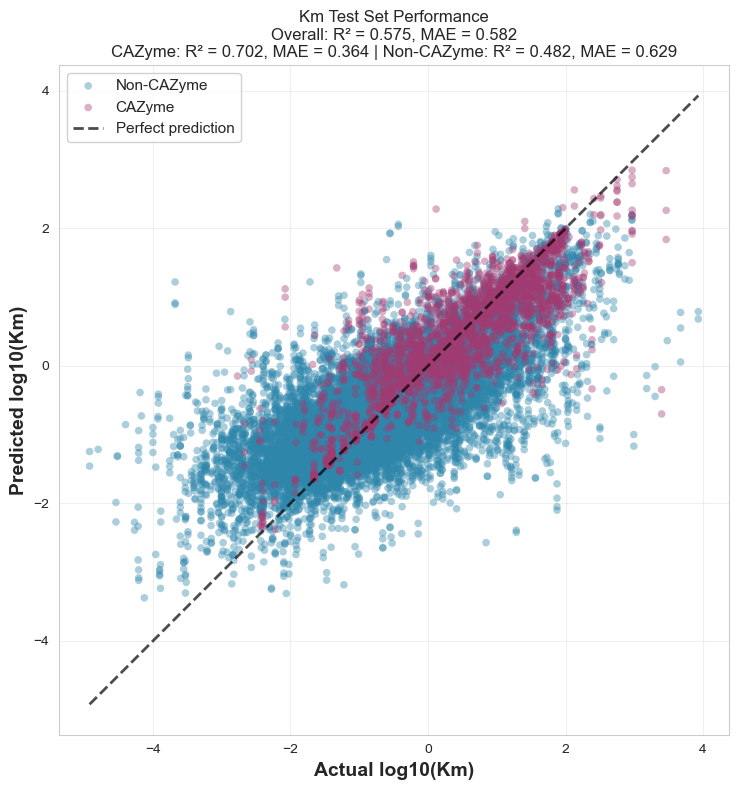

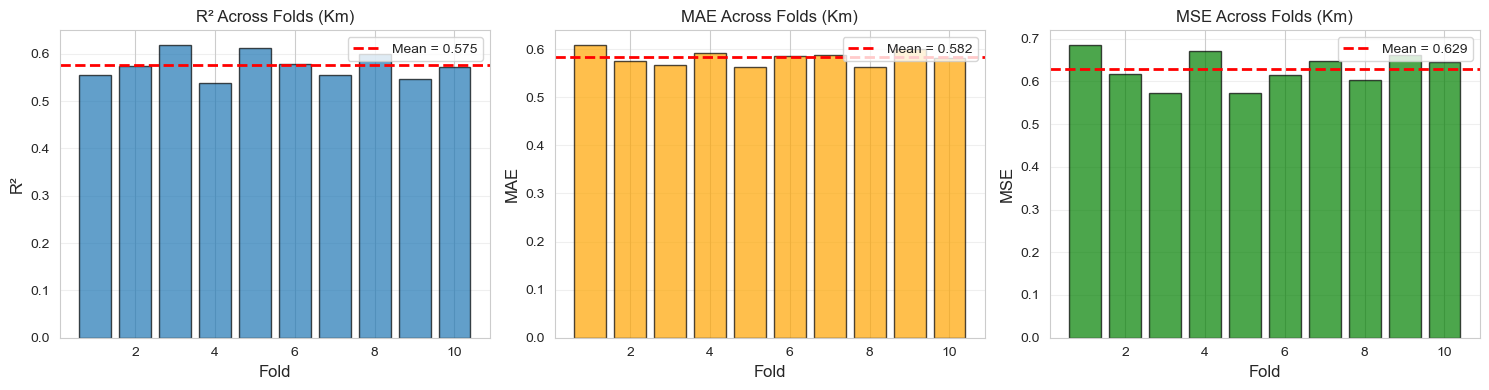

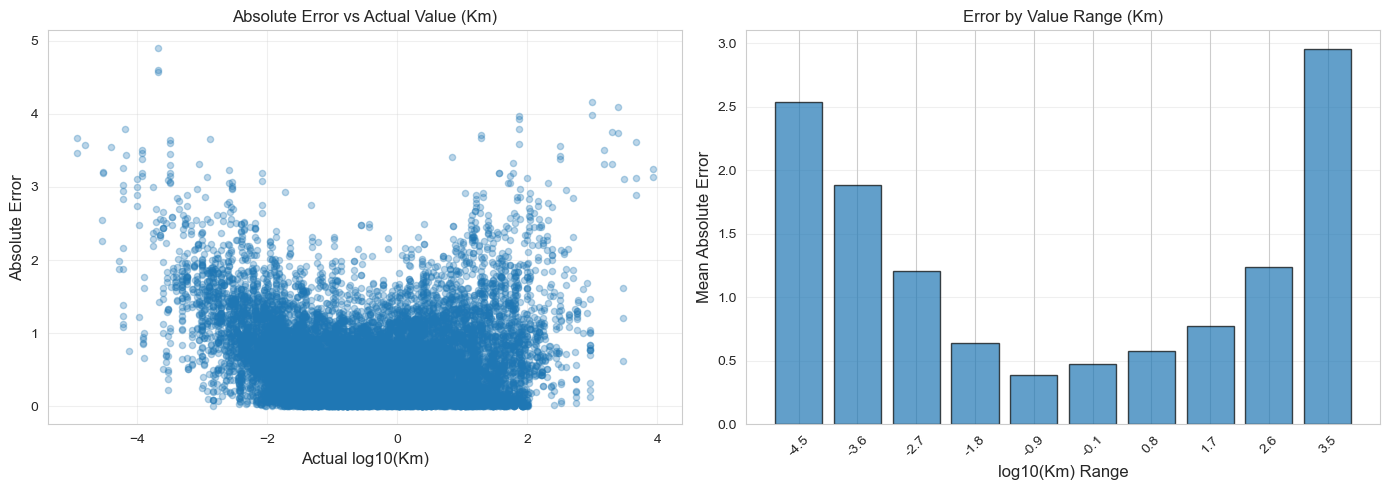

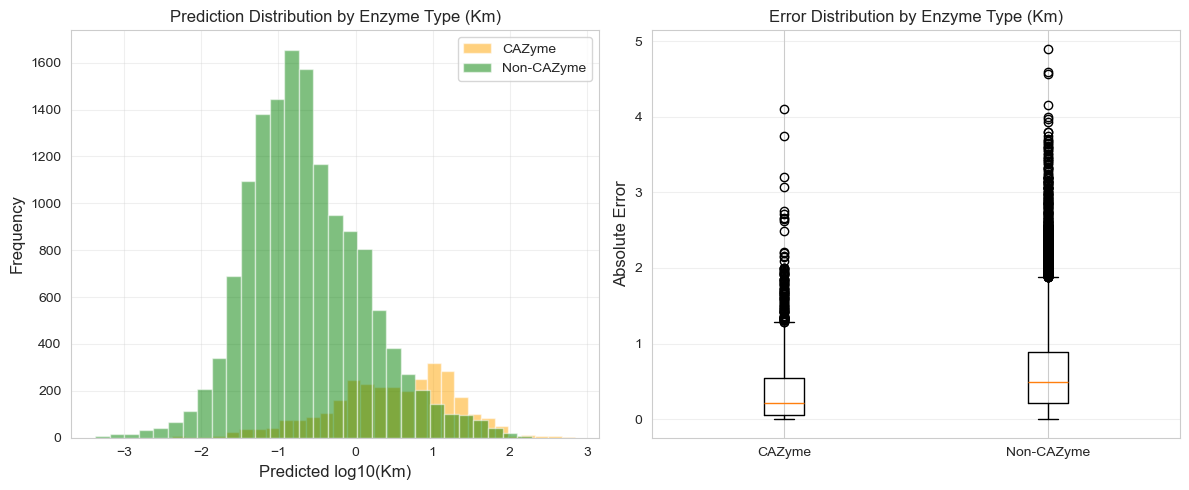


Km PREDICTION SUMMARY STATISTICS

Test Set Performance:
  R² Score:    0.5754
  MAE:         0.5825
  MSE:         0.6293
  RMSE:        0.7933

CAZyme Performance (n=3060):
  R² Score:    0.7023
  MAE:         0.3641

Non-CAZyme Performance (n=14370):
  R² Score:    0.4816
  MAE:         0.6290

Performance Across Folds:
  R² Mean ± Std:   0.5751 ± 0.0274
  MAE Mean ± Std:  0.5825 ± 0.0157


In [49]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import math

def Km_predict(features, labels, metadata_df, n_folds=10, output_dir='results'):
    """
    Train ExtraTreesRegressor with stratified 80/20 train/test splits based on CAZyme status.
    
    Args:
        features: Combined embeddings (N, 2048)
        labels: Log10-transformed Km values (N,)
        metadata_df: DataFrame with sequence, smiles, and CAZyme status
        n_folds: Number of random train/test splits
        output_dir: Directory to save results
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    all_results = []
    cazyme_status = metadata_df['is_CAZyme'].values
    
    for fold in range(n_folds):
        print(f"\n=== Fold {fold + 1}/{n_folds} ===")
        
        # Stratified 80/20 split by CAZyme status
        train_indices, test_indices = train_test_split(
            np.arange(len(features)),
            test_size=0.2,
            stratify=cazyme_status,
            random_state=fold
        )
        
        # Create train/test masks
        train_mask = np.zeros(len(features), dtype=bool)
        train_mask[train_indices] = True
        
        # Split data
        X_train, y_train = features[train_mask], labels[train_mask]
        X_test, y_test = features[~train_mask], labels[~train_mask]
        
        # Print split statistics
        train_cazyme = cazyme_status[train_mask]
        test_cazyme = cazyme_status[~train_mask]
        print(f"Train: {len(X_train)} samples ({train_cazyme.sum()} CAZymes, {100*train_cazyme.mean():.1f}%)")
        print(f"Test:  {len(X_test)} samples ({test_cazyme.sum()} CAZymes, {100*test_cazyme.mean():.1f}%)")
        
        # Train model
        model = ExtraTreesRegressor(
                    n_estimators=100,
                    min_samples_split=2,
                    min_samples_leaf=1,
                    max_features=None,
                    max_depth=30,
                    random_state=fold,
                    n_jobs=-1
                )
        model.fit(X_train, y_train)
        
        # Predict on all data
        y_pred_all = model.predict(features)
        
        # Calculate metrics on test set
        y_pred_test = y_pred_all[~train_mask]
        mse = mean_squared_error(y_test, y_pred_test)
        mae = mean_absolute_error(y_test, y_pred_test)
        r2 = r2_score(y_test, y_pred_test)
        
        # Calculate metrics separately for CAZyme and non-CAZyme in test set
        cazyme_test_mask = test_cazyme.astype(bool)
        if cazyme_test_mask.sum() > 0:
            cazyme_mae = mean_absolute_error(y_test[cazyme_test_mask], y_pred_test[cazyme_test_mask])
            cazyme_r2 = r2_score(y_test[cazyme_test_mask], y_pred_test[cazyme_test_mask])
        else:
            cazyme_mae, cazyme_r2 = np.nan, np.nan
            
        if (~cazyme_test_mask).sum() > 0:
            non_cazyme_mae = mean_absolute_error(y_test[~cazyme_test_mask], y_pred_test[~cazyme_test_mask])
            non_cazyme_r2 = r2_score(y_test[~cazyme_test_mask], y_pred_test[~cazyme_test_mask])
        else:
            non_cazyme_mae, non_cazyme_r2 = np.nan, np.nan
        
        print(f"Overall - MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
        print(f"CAZyme  - MAE: {cazyme_mae:.4f}, R²: {cazyme_r2:.4f}")
        print(f"Non-CAZyme - MAE: {non_cazyme_mae:.4f}, R²: {non_cazyme_r2:.4f}")
        
        # Save results
        results_df = metadata_df.copy()
        results_df['Label'] = labels
        results_df['Predicted_Label'] = y_pred_all
        results_df['Training_or_Test'] = ['Train' if m else 'Test' for m in train_mask]
        results_df.to_excel(f'{output_dir}/fold_{fold + 1}_predictions.xlsx', index=False)
        
        all_results.append({
            'fold': fold + 1,
            'test_mse': mse,
            'test_mae': mae,
            'test_r2': r2,
            'cazyme_test_mae': cazyme_mae,
            'cazyme_test_r2': cazyme_r2,
            'non_cazyme_test_mae': non_cazyme_mae,
            'non_cazyme_test_r2': non_cazyme_r2,
            'train_size': len(X_train),
            'test_size': len(X_test)
        })
    
    # Save summary statistics
    summary_df = pd.DataFrame(all_results)
    summary_df.to_csv(f'{output_dir}/summary_metrics.csv', index=False)
    print(f"\n=== Summary across {n_folds} folds ===")
    print(summary_df.describe())
    
    return summary_df


def plot_km_performance(results_dir='PreKm_results', output_dir='plots'):
    """
    Generate comprehensive plots to analyze Km prediction performance.
    
    Args:
        results_dir: Directory containing fold prediction Excel files
        output_dir: Directory to save plots
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    # Load all fold results
    all_folds = []
    for i in range(1, 11):  # 10 folds
        try:
            df = pd.read_excel(f'{results_dir}/fold_{i}_predictions.xlsx')
            df['fold'] = i
            all_folds.append(df)
        except FileNotFoundError:
            print(f"Warning: fold_{i}_predictions.xlsx not found")
    
    if not all_folds:
        print("No results found!")
        return
    
    # Combine all folds
    all_data = pd.concat(all_folds, ignore_index=True)
    
    # Separate train and test
    test_data = all_data[all_data['Training_or_Test'] == 'Test']
    train_data = all_data[all_data['Training_or_Test'] == 'Train']
    
    print(f"Loaded {len(all_data)} total predictions ({len(test_data)} test, {len(train_data)} train)")
    
    # =====================================================
    # 1. PREDICTED VS ACTUAL (PARITY PLOT) - Most Important
    # =====================================================
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    # Separate CAZyme and Non-CAZyme
    cazyme_test = test_data[test_data['is_CAZyme'] == 1]
    non_cazyme_test = test_data[test_data['is_CAZyme'] == 0]
    
    # Plot both on same axes
    ax.scatter(non_cazyme_test['Label'], non_cazyme_test['Predicted_Label'], 
               alpha=0.4, s=30, color='#2E86AB', label='Non-CAZyme', edgecolors='none')
    ax.scatter(cazyme_test['Label'], cazyme_test['Predicted_Label'], 
               alpha=0.4, s=30, color='#A23B72', label='CAZyme', edgecolors='none')
    
    # Perfect prediction line
    min_val = test_data['Label'].min()
    max_val = test_data['Label'].max()
    ax.plot([min_val, max_val], [min_val, max_val], 
            'k--', lw=2, label='Perfect prediction', alpha=0.7)
    
    # Calculate metrics
    r2 = r2_score(test_data['Label'], test_data['Predicted_Label'])
    mae = mean_absolute_error(test_data['Label'], test_data['Predicted_Label'])
    r2_caz = r2_score(cazyme_test['Label'], cazyme_test['Predicted_Label'])
    mae_caz = mean_absolute_error(cazyme_test['Label'], cazyme_test['Predicted_Label'])
    r2_non = r2_score(non_cazyme_test['Label'], non_cazyme_test['Predicted_Label'])
    mae_non = mean_absolute_error(non_cazyme_test['Label'], non_cazyme_test['Predicted_Label'])
    
    ax.set_xlabel('Actual log10(Km)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Predicted log10(Km)', fontsize=14, fontweight='bold')
    ax.set_title(f'Km Test Set Performance\n' + 
                 f'Overall: R² = {r2:.3f}, MAE = {mae:.3f}\n' +
                 f'CAZyme: R² = {r2_caz:.3f}, MAE = {mae_caz:.3f} | ' +
                 f'Non-CAZyme: R² = {r2_non:.3f}, MAE = {mae_non:.3f}',
                 fontsize=12)
    ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/1_parity_plot_km.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # =====================================================
    # 2. PERFORMANCE ACROSS FOLDS
    # =====================================================
    fold_metrics = []
    for fold_num in test_data['fold'].unique():
        fold_test = test_data[test_data['fold'] == fold_num]
        fold_metrics.append({
            'fold': fold_num,
            'R2': r2_score(fold_test['Label'], fold_test['Predicted_Label']),
            'MAE': mean_absolute_error(fold_test['Label'], fold_test['Predicted_Label']),
            'MSE': mean_squared_error(fold_test['Label'], fold_test['Predicted_Label'])
        })
    fold_df = pd.DataFrame(fold_metrics)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # R² across folds
    ax = axes[0]
    ax.bar(fold_df['fold'], fold_df['R2'], alpha=0.7, edgecolor='black')
    ax.axhline(y=fold_df['R2'].mean(), color='r', linestyle='--', lw=2, 
               label=f'Mean = {fold_df["R2"].mean():.3f}')
    ax.set_xlabel('Fold', fontsize=12)
    ax.set_ylabel('R²', fontsize=12)
    ax.set_title('R² Across Folds (Km)', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # MAE across folds
    ax = axes[1]
    ax.bar(fold_df['fold'], fold_df['MAE'], alpha=0.7, color='orange', edgecolor='black')
    ax.axhline(y=fold_df['MAE'].mean(), color='r', linestyle='--', lw=2,
               label=f'Mean = {fold_df["MAE"].mean():.3f}')
    ax.set_xlabel('Fold', fontsize=12)
    ax.set_ylabel('MAE', fontsize=12)
    ax.set_title('MAE Across Folds (Km)', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # MSE across folds
    ax = axes[2]
    ax.bar(fold_df['fold'], fold_df['MSE'], alpha=0.7, color='green', edgecolor='black')
    ax.axhline(y=fold_df['MSE'].mean(), color='r', linestyle='--', lw=2,
               label=f'Mean = {fold_df["MSE"].mean():.3f}')
    ax.set_xlabel('Fold', fontsize=12)
    ax.set_ylabel('MSE', fontsize=12)
    ax.set_title('MSE Across Folds (Km)', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/2_fold_performance_km.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # =====================================================
    # 3. ERROR DISTRIBUTION BY MAGNITUDE
    # =====================================================
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Calculate residuals and absolute error
    test_residuals = test_data['Label'] - test_data['Predicted_Label']
    test_abs_error = np.abs(test_residuals)
    
    # Absolute error vs actual value
    ax = axes[0]
    ax.scatter(test_data['Label'], test_abs_error, alpha=0.3, s=20)
    ax.set_xlabel('Actual log10(Km)', fontsize=12)
    ax.set_ylabel('Absolute Error', fontsize=12)
    ax.set_title('Absolute Error vs Actual Value (Km)', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Error by value range
    ax = axes[1]
    bins = pd.cut(test_data['Label'], bins=10)
    error_by_bin = test_data.groupby(bins)['Label'].apply(
        lambda x: np.abs(test_data.loc[x.index, 'Label'] - 
                        test_data.loc[x.index, 'Predicted_Label']).mean()
    )
    bin_centers = [interval.mid for interval in error_by_bin.index]
    ax.bar(range(len(error_by_bin)), error_by_bin.values, alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(error_by_bin)))
    ax.set_xticklabels([f'{c:.1f}' for c in bin_centers], rotation=45)
    ax.set_xlabel('log10(Km) Range', fontsize=12)
    ax.set_ylabel('Mean Absolute Error', fontsize=12)
    ax.set_title('Error by Value Range (Km)', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/3_error_distribution_km.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # =====================================================
    # 4. CAZYME VS NON-CAZYME COMPARISON
    # =====================================================
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Distribution of predictions
    ax = axes[0]
    ax.hist(cazyme_test['Predicted_Label'], bins=30, alpha=0.5, label='CAZyme', color='orange')
    ax.hist(non_cazyme_test['Predicted_Label'], bins=30, alpha=0.5, label='Non-CAZyme', color='green')
    ax.set_xlabel('Predicted log10(Km)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Prediction Distribution by Enzyme Type (Km)', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Box plot of errors
    ax = axes[1]
    cazyme_errors = np.abs(cazyme_test['Label'] - cazyme_test['Predicted_Label'])
    non_cazyme_errors = np.abs(non_cazyme_test['Label'] - non_cazyme_test['Predicted_Label'])
    ax.boxplot([cazyme_errors, non_cazyme_errors], labels=['CAZyme', 'Non-CAZyme'])
    ax.set_ylabel('Absolute Error', fontsize=12)
    ax.set_title('Error Distribution by Enzyme Type (Km)', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/4_cazyme_comparison_km.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # =====================================================
    # Print Summary Statistics
    # =====================================================
    print("\n" + "="*60)
    print("Km PREDICTION SUMMARY STATISTICS")
    print("="*60)
    print(f"\nTest Set Performance:")
    print(f"  R² Score:    {r2:.4f}")
    print(f"  MAE:         {mae:.4f}")
    print(f"  MSE:         {mean_squared_error(test_data['Label'], test_data['Predicted_Label']):.4f}")
    print(f"  RMSE:        {np.sqrt(mean_squared_error(test_data['Label'], test_data['Predicted_Label'])):.4f}")
    
    print(f"\nCAZyme Performance (n={len(cazyme_test)}):")
    print(f"  R² Score:    {r2_caz:.4f}")
    print(f"  MAE:         {mae_caz:.4f}")
    
    print(f"\nNon-CAZyme Performance (n={len(non_cazyme_test)}):")
    print(f"  R² Score:    {r2_non:.4f}")
    print(f"  MAE:         {mae_non:.4f}")
    
    print(f"\nPerformance Across Folds:")
    print(f"  R² Mean ± Std:   {fold_df['R2'].mean():.4f} ± {fold_df['R2'].std():.4f}")
    print(f"  MAE Mean ± Std:  {fold_df['MAE'].mean():.4f} ± {fold_df['MAE'].std():.4f}")
    print("="*60)


if __name__ == '__main__':
    # =====================================================
    # TRAIN KM MODEL
    # =====================================================
    print("="*60)
    print("TRAINING Km PREDICTION MODEL")
    print("="*60)
    
    # Load pre-computed embeddings
    print("\nLoading embeddings...")
    km_seq = np.load("km_sequence_vectors_merged_structured.npz", allow_pickle=True)
    km_smiles = np.load("km_smiles_vectors_merged_structured.npz", allow_pickle=True)
    
    # Extract data
    seq_embeddings = km_seq['embeddings']
    smiles_embeddings = km_smiles['embeddings']
    km_values = km_seq['predictor_values']
    sequences = km_seq['original_seqs']
    smiles = km_smiles['original_seqs']
    is_cazyme = km_seq['is_cazyme']
    
    print(f"Loaded {len(km_values)} samples")
    print(f"Sequence embeddings: {seq_embeddings.shape}")
    print(f"SMILES embeddings: {smiles_embeddings.shape}")
    
    # Combine features (concatenate SMILES + sequence, matching original order)
    combined_features = np.concatenate([smiles_embeddings, seq_embeddings], axis=1)
    print(f"Combined features: {combined_features.shape}")
    
    # Convert to log10 scale (matching original code)
    log_km = np.array([
        -10000000000 if val == 0 else math.log(val, 10) 
        for val in km_values
    ])
    
    # Filter out invalid values and SMILES with '.' (salts/mixtures)
    valid_mask = (log_km > -10000000000) & np.array(['.' not in s for s in smiles])
    
    features_filtered = combined_features[valid_mask]
    labels_filtered = log_km[valid_mask]
    sequences_filtered = sequences[valid_mask]
    smiles_filtered = smiles[valid_mask]
    cazyme_filtered = is_cazyme[valid_mask]
    
    print(f"\nAfter filtering:")
    print(f"Valid samples: {len(labels_filtered)}")
    print(f"Label range: [{labels_filtered.min():.4f}, {labels_filtered.max():.4f}]")
    print(f"CAZymes: {cazyme_filtered.sum()} ({100*cazyme_filtered.mean():.1f}%)")
    print(f"Non-CAZymes: {(~cazyme_filtered).sum()} ({100*(~cazyme_filtered).mean():.1f}%)")
    
    # Create metadata DataFrame
    metadata_df = pd.DataFrame({
        'Sequence': sequences_filtered,
        'SMILES': smiles_filtered,
        'is_CAZyme': cazyme_filtered
    })
    
    # Train and evaluate models with stratified splits
    summary = Km_predict(
        features_filtered, 
        labels_filtered, 
        metadata_df,
        n_folds=10,
        output_dir='PreKm_results'
    )
    
    # =====================================================
    # GENERATE PLOTS
    # =====================================================
    print("\n" + "="*60)
    print("GENERATING Km PERFORMANCE PLOTS")
    print("="*60)
    
    plot_km_performance(results_dir='PreKm_results', output_dir='km_performance_plots')

## 4. Build Neural Networks

### kcat Hyperparameter tuning

In [58]:
"""
Hyperparameter Tuning for Dual-Tower MLP with Box Plot Visualizations
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import StandardScaler
import math
import itertools
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


class DualTowerMLPRegressor:
    """Dual-Tower MLP for hyperparameter tuning."""
    
    def __init__(self, 
                 tower_hidden_layers=(512, 256),
                 fusion_hidden_layers=(256, 128, 64),
                 learning_rate=0.001,
                 batch_size=32,
                 max_epochs=100,
                 patience=10,
                 random_state=42):
        
        self.tower_hidden_layers = tower_hidden_layers
        self.fusion_hidden_layers = fusion_hidden_layers
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.patience = patience
        self.random_state = random_state
        
        np.random.seed(random_state)
        tf.random.set_seed(random_state)
        
        self.history_ = None
    
    def _build_tower(self, input_dim, hidden_layers, name):
        """Build a tower network - outputs representation, not prediction."""
        model = models.Sequential(name=name)
        for i, units in enumerate(hidden_layers):
            if i == 0:
                model.add(layers.Dense(units, activation='relu', input_dim=input_dim))
            else:
                model.add(layers.Dense(units, activation='relu'))
        return model
    
    def _build_fusion_network(self, input_dim, hidden_layers):
        """Build the fusion network."""
        model = models.Sequential(name='fusion_network')
        for i, units in enumerate(hidden_layers):
            if i == 0:
                model.add(layers.Dense(units, activation='relu', input_dim=input_dim))
            else:
                model.add(layers.Dense(units, activation='relu'))
        model.add(layers.Dense(1))
        return model
    
    def fit(self, X, y, X_val=None, y_val=None):
        """Fit the dual-tower model."""
        # Split input into sequence and SMILES embeddings
        n_features = X.shape[1]
        seq_dim = n_features // 2
        
        X_seq = X[:, :seq_dim]
        X_smiles = X[:, seq_dim:]
        
        # Normalize inputs
        self.seq_scaler_ = StandardScaler()
        self.smiles_scaler_ = StandardScaler()
        
        X_seq_norm = self.seq_scaler_.fit_transform(X_seq)
        X_smiles_norm = self.smiles_scaler_.fit_transform(X_smiles)
        
        # Build towers (they only extract representations)
        self.seq_tower_ = self._build_tower(seq_dim, self.tower_hidden_layers, 'seq_tower')
        self.smiles_tower_ = self._build_tower(n_features - seq_dim, self.tower_hidden_layers, 'smiles_tower')
        
        # Extract representations from towers
        seq_repr = self.seq_tower_.predict(X_seq_norm, verbose=0)
        smiles_repr = self.smiles_tower_.predict(X_smiles_norm, verbose=0)
        
        # Validation representations
        if X_val is not None:
            X_val_seq = X_val[:, :seq_dim]
            X_val_smiles = X_val[:, seq_dim:]
            X_val_seq_norm = self.seq_scaler_.transform(X_val_seq)
            X_val_smiles_norm = self.smiles_scaler_.transform(X_val_smiles)
            
            seq_repr_val = self.seq_tower_.predict(X_val_seq_norm, verbose=0)
            smiles_repr_val = self.smiles_tower_.predict(X_val_smiles_norm, verbose=0)
        
        # Fuse representations
        fused = np.concatenate([seq_repr, smiles_repr], axis=1)
        
        self.fusion_scaler_ = StandardScaler()
        fused_norm = self.fusion_scaler_.fit_transform(fused)
        
        # Validation fused features
        if X_val is not None:
            fused_val = np.concatenate([seq_repr_val, smiles_repr_val], axis=1)
            fused_val_norm = self.fusion_scaler_.transform(fused_val)
            val_fusion = (fused_val_norm, y_val)
        else:
            val_fusion = None
        
        # Build and train fusion network
        self.fusion_network_ = self._build_fusion_network(fused.shape[1], self.fusion_hidden_layers)
        self.fusion_network_.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss='mse'
        )
        
        early_stop = callbacks.EarlyStopping(
            monitor='val_loss' if val_fusion else 'loss',
            patience=self.patience,
            restore_best_weights=True,
            verbose=0
        )
        
        history = self.fusion_network_.fit(
            fused_norm, y,
            epochs=self.max_epochs,
            batch_size=self.batch_size,
            validation_data=val_fusion,
            callbacks=[early_stop],
            verbose=0
        )
        
        self.history_ = history.history
        
        return self
    
    def predict(self, X):
        """Make predictions."""
        n_features = X.shape[1]
        seq_dim = n_features // 2
        
        X_seq = X[:, :seq_dim]
        X_smiles = X[:, seq_dim:]
        
        X_seq_norm = self.seq_scaler_.transform(X_seq)
        X_smiles_norm = self.smiles_scaler_.transform(X_smiles)
        
        seq_repr = self.seq_tower_.predict(X_seq_norm, verbose=0)
        smiles_repr = self.smiles_tower_.predict(X_smiles_norm, verbose=0)
        
        fused = np.concatenate([seq_repr, smiles_repr], axis=1)
        fused_norm = self.fusion_scaler_.transform(fused)
        
        predictions = self.fusion_network_.predict(fused_norm, verbose=0)
        return predictions.flatten()


def hyperparameter_tuning(X_train, y_train, X_val, y_val, X_test, y_test, 
                          param_grid, n_trials=3, output_dir='dual_tower_tuning'):
    """
    Perform hyperparameter tuning with multiple trials per configuration.
    
    Args:
        X_train, y_train: Training data
        X_val, y_val: Validation data
        X_test, y_test: Test data
        param_grid: Dictionary of hyperparameters to search
        n_trials: Number of trials per configuration (for stability)
        output_dir: Directory to save results
    
    Returns:
        results_df: DataFrame with all results
        best_params: Best hyperparameter configuration
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    print("="*70)
    print("DUAL-TOWER MLP HYPERPARAMETER TUNING")
    print("="*70)
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Test samples: {len(X_test)}")
    print(f"Trials per configuration: {n_trials}")
    print("="*70)
    
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    all_combinations = list(itertools.product(*param_values))
    
    print(f"\nTotal configurations to test: {len(all_combinations)}")
    print(f"Total training runs: {len(all_combinations) * n_trials}\n")
    
    # Storage for results
    results = []
    
    # Iterate through all combinations
    for combo in tqdm(all_combinations, desc="Testing configurations"):
        params = dict(zip(param_names, combo))
        
        # Run multiple trials for this configuration
        for trial in range(n_trials):
            try:
                # Create model with these parameters
                model = DualTowerMLPRegressor(
                    tower_hidden_layers=params['tower_hidden_layers'],
                    fusion_hidden_layers=params['fusion_hidden_layers'],
                    learning_rate=params['learning_rate'],
                    batch_size=params['batch_size'],
                    max_epochs=100,
                    patience=10,
                    random_state=42 + trial
                )
                
                # Train model
                model.fit(X_train, y_train, X_val, y_val)
                
                # Evaluate on validation and test sets
                y_val_pred = model.predict(X_val)
                y_test_pred = model.predict(X_test)
                
                val_mae = mean_absolute_error(y_val, y_val_pred)
                val_r2 = r2_score(y_val, y_val_pred)
                test_mae = mean_absolute_error(y_test, y_test_pred)
                test_r2 = r2_score(y_test, y_test_pred)
                
                # Get final training and validation loss
                train_loss = model.history_['loss'][-1]
                val_loss = model.history_['val_loss'][-1] if 'val_loss' in model.history_ else np.nan
                
                # Store results
                result = {
                    'tower_hidden_layers': str(params['tower_hidden_layers']),
                    'fusion_hidden_layers': str(params['fusion_hidden_layers']),
                    'learning_rate': params['learning_rate'],
                    'batch_size': params['batch_size'],
                    'trial': trial,
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'val_mae': val_mae,
                    'val_r2': val_r2,
                    'test_mae': test_mae,
                    'test_r2': test_r2
                }
                results.append(result)
                
            except Exception as e:
                print(f"\nError in trial: {str(e)}")
                continue
    
    # Convert to DataFrame
    if len(results) == 0:
        raise RuntimeError("No successful training runs!")
    
    results_df = pd.DataFrame(results)
    results_df.to_csv(f'{output_dir}/hyperparameter_results.csv', index=False)
    
    print(f"\n✓ Completed {len(results)} successful runs")
    
    # Find best configuration based on mean validation MAE
    grouped = results_df.groupby(['tower_hidden_layers', 'fusion_hidden_layers', 
                                   'learning_rate', 'batch_size'])
    mean_results = grouped.agg({
        'val_mae': ['mean', 'std'],
        'val_r2': ['mean', 'std'],
        'test_mae': ['mean', 'std'],
        'test_r2': ['mean', 'std']
    }).reset_index()
    
    # Flatten column names
    mean_results.columns = ['_'.join(col).strip('_') for col in mean_results.columns.values]
    mean_results.to_csv(f'{output_dir}/hyperparameter_summary.csv', index=False)
    
    # Get best parameters
    best_idx = mean_results['val_mae_mean'].idxmin()
    best_row = mean_results.iloc[best_idx]
    
    best_params = {
        'tower_hidden_layers': eval(best_row['tower_hidden_layers']),
        'fusion_hidden_layers': eval(best_row['fusion_hidden_layers']),
        'learning_rate': best_row['learning_rate'],
        'batch_size': best_row['batch_size']
    }
    
    print("\n" + "="*70)
    print("BEST HYPERPARAMETERS")
    print("="*70)
    for key, value in best_params.items():
        print(f"{key}: {value}")
    print(f"\nValidation MAE: {best_row['val_mae_mean']:.4f} ± {best_row['val_mae_std']:.4f}")
    print(f"Validation R²: {best_row['val_r2_mean']:.4f} ± {best_row['val_r2_std']:.4f}")
    print(f"Test MAE: {best_row['test_mae_mean']:.4f} ± {best_row['test_mae_std']:.4f}")
    print(f"Test R²: {best_row['test_r2_mean']:.4f} ± {best_row['test_r2_std']:.4f}")
    print("="*70)
    
    # Save best parameters
    with open(f'{output_dir}/best_params.txt', 'w') as f:
        f.write("Best Hyperparameters:\n")
        for key, value in best_params.items():
            f.write(f"{key}: {value}\n")
        f.write(f"\nValidation MAE: {best_row['val_mae_mean']:.4f} ± {best_row['val_mae_std']:.4f}\n")
        f.write(f"Validation R²: {best_row['val_r2_mean']:.4f} ± {best_row['val_r2_std']:.4f}\n")
        f.write(f"Test MAE: {best_row['test_mae_mean']:.4f} ± {best_row['test_mae_std']:.4f}\n")
        f.write(f"Test R²: {best_row['test_r2_mean']:.4f} ± {best_row['test_r2_std']:.4f}\n")
    
    return results_df, best_params, mean_results


def plot_hyperparameter_boxplots(results_df, output_dir='dual_tower_tuning'):
    """Create box plots showing validation loss distribution for each hyperparameter."""
    
    sns.set_style("whitegrid")
    
    # 1. Box plot for tower hidden layers
    fig, ax = plt.subplots(figsize=(12, 6))
    data_to_plot = []
    labels = []
    
    for tower_config in sorted(results_df['tower_hidden_layers'].unique()):
        subset = results_df[results_df['tower_hidden_layers'] == tower_config]
        data_to_plot.append(subset['val_mae'].values)
        labels.append(tower_config)
    
    bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
    
    ax.set_xlabel('Tower Hidden Layers', fontsize=12, fontweight='bold')
    ax.set_ylabel('Validation MAE', fontsize=12, fontweight='bold')
    ax.set_title('Validation Loss vs Tower Architecture', fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/boxplot_tower_layers.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 2. Box plot for fusion hidden layers
    fig, ax = plt.subplots(figsize=(12, 6))
    data_to_plot = []
    labels = []
    
    for fusion_config in sorted(results_df['fusion_hidden_layers'].unique()):
        subset = results_df[results_df['fusion_hidden_layers'] == fusion_config]
        data_to_plot.append(subset['val_mae'].values)
        labels.append(fusion_config)
    
    bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightgreen')
    
    ax.set_xlabel('Fusion Hidden Layers', fontsize=12, fontweight='bold')
    ax.set_ylabel('Validation MAE', fontsize=12, fontweight='bold')
    ax.set_title('Validation Loss vs Fusion Architecture', fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/boxplot_fusion_layers.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 3. Box plot for learning rate
    fig, ax = plt.subplots(figsize=(10, 6))
    data_to_plot = []
    labels = []
    
    for lr in sorted(results_df['learning_rate'].unique()):
        subset = results_df[results_df['learning_rate'] == lr]
        data_to_plot.append(subset['val_mae'].values)
        labels.append(f'{lr:.4f}')
    
    bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightcoral')
    
    ax.set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
    ax.set_ylabel('Validation MAE', fontsize=12, fontweight='bold')
    ax.set_title('Validation Loss vs Learning Rate', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/boxplot_learning_rate.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 4. Box plot for batch size
    fig, ax = plt.subplots(figsize=(10, 6))
    data_to_plot = []
    labels = []
    
    for bs in sorted(results_df['batch_size'].unique()):
        subset = results_df[results_df['batch_size'] == bs]
        data_to_plot.append(subset['val_mae'].values)
        labels.append(str(bs))
    
    bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightyellow')
    
    ax.set_xlabel('Batch Size', fontsize=12, fontweight='bold')
    ax.set_ylabel('Validation MAE', fontsize=12, fontweight='bold')
    ax.set_title('Validation Loss vs Batch Size', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/boxplot_batch_size.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 5. Combined comparison plot
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Tower layers
    ax = axes[0, 0]
    grouped = results_df.groupby('tower_hidden_layers')['val_mae'].agg(['mean', 'std'])
    x_pos = np.arange(len(grouped))
    ax.bar(x_pos, grouped['mean'], yerr=grouped['std'], capsize=5, alpha=0.7, color='lightblue')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(grouped.index, rotation=45, ha='right')
    ax.set_ylabel('Validation MAE', fontsize=11, fontweight='bold')
    ax.set_title('Tower Architecture', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Fusion layers
    ax = axes[0, 1]
    grouped = results_df.groupby('fusion_hidden_layers')['val_mae'].agg(['mean', 'std'])
    x_pos = np.arange(len(grouped))
    ax.bar(x_pos, grouped['mean'], yerr=grouped['std'], capsize=5, alpha=0.7, color='lightgreen')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(grouped.index, rotation=45, ha='right')
    ax.set_ylabel('Validation MAE', fontsize=11, fontweight='bold')
    ax.set_title('Fusion Architecture', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Learning rate
    ax = axes[1, 0]
    grouped = results_df.groupby('learning_rate')['val_mae'].agg(['mean', 'std']).sort_index()
    x_pos = np.arange(len(grouped))
    ax.bar(x_pos, grouped['mean'], yerr=grouped['std'], capsize=5, alpha=0.7, color='lightcoral')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f'{lr:.4f}' for lr in grouped.index])
    ax.set_ylabel('Validation MAE', fontsize=11, fontweight='bold')
    ax.set_title('Learning Rate', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Batch size
    ax = axes[1, 1]
    grouped = results_df.groupby('batch_size')['val_mae'].agg(['mean', 'std']).sort_index()
    x_pos = np.arange(len(grouped))
    ax.bar(x_pos, grouped['mean'], yerr=grouped['std'], capsize=5, alpha=0.7, color='lightyellow')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([str(bs) for bs in grouped.index])
    ax.set_ylabel('Validation MAE', fontsize=11, fontweight='bold')
    ax.set_title('Batch Size', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/comparison_all_hyperparameters.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 6. Heatmap of hyperparameter interactions
    fig, ax = plt.subplots(figsize=(12, 8))
    
    pivot_data = results_df.groupby(['tower_hidden_layers', 'fusion_hidden_layers'])['val_mae'].mean().unstack()
    
    sns.heatmap(pivot_data, annot=True, fmt='.4f', cmap='RdYlGn_r', ax=ax, cbar_kws={'label': 'Mean Validation MAE'})
    ax.set_xlabel('Fusion Hidden Layers', fontsize=12, fontweight='bold')
    ax.set_ylabel('Tower Hidden Layers', fontsize=12, fontweight='bold')
    ax.set_title('Heatmap: Tower vs Fusion Architecture', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/heatmap_tower_fusion.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"\n✓ Box plots saved to '{output_dir}/'")


# =====================================================
# MAIN EXECUTION
# =====================================================
if __name__ == '__main__':
    # Load kcat embeddings
    print("Loading kcat embeddings...")
    kcat_seq = np.load("kcat_sequence_vectors_merged_structured.npz", allow_pickle=True)
    kcat_smiles = np.load("kcat_smiles_vectors_merged_structured.npz", allow_pickle=True)
    
    # Extract data
    seq_embeddings = kcat_seq['embeddings']
    smiles_embeddings = kcat_smiles['embeddings']
    kcat_values = kcat_seq['predictor_values']
    is_cazyme = kcat_seq['is_cazyme']
    smiles_strings = kcat_smiles['original_seqs']
    
    print(f"Loaded {len(kcat_values)} samples")
    
    # Combine embeddings
    combined_features = np.concatenate([smiles_embeddings, seq_embeddings], axis=1)
    
    # Log10 transform
    log_kcat = np.array([
        -10000000000 if val == 0 else math.log(val, 10) 
        for val in kcat_values
    ])
    
    # Filter invalid values
    valid_mask = (log_kcat > -10000000000) & np.array(['.' not in s for s in smiles_strings])
    
    X = combined_features[valid_mask]
    y = log_kcat[valid_mask]
    cazyme_labels = is_cazyme[valid_mask]
    
    print(f"After filtering: {len(y)} samples")
    
    # Split data: 60% train, 20% val, 20% test (stratified)
    X_temp, X_test, y_temp, y_test, caz_temp, caz_test = train_test_split(
        X, y, cazyme_labels, test_size=0.2, stratify=cazyme_labels, random_state=42
    )
    
    X_train, X_val, y_train, y_val, caz_train, caz_val = train_test_split(
        X_temp, y_temp, caz_temp, test_size=0.25, stratify=caz_temp, random_state=42
    )
    
    print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
    
    # Define hyperparameter grid
    param_grid = {
        'tower_hidden_layers': [
            (256, 128),
            (512, 256),
            (512, 256, 128)
        ],
        'fusion_hidden_layers': [
            (128, 64),
            (256, 128),
            (256, 128, 64)
        ],
        'learning_rate': [0.001, 0.0001],
        'batch_size': [32, 64]
    }
    
    # Perform hyperparameter tuning
    results_df, best_params, mean_results = hyperparameter_tuning(
        X_train, y_train, X_val, y_val, X_test, y_test,
        param_grid=param_grid,
        n_trials=3,
        output_dir='kcat_dual_tower_tuning'
    )
    
    # Generate box plots
    plot_hyperparameter_boxplots(results_df, output_dir='kcat_dual_tower_tuning')
    
    print("\n✓ Hyperparameter tuning complete!")
    print("Results saved to 'kcat_dual_tower_tuning/' directory")

Loading kcat embeddings...
Loaded 8632 samples
After filtering: 8519 samples
Train: 5111, Val: 1704, Test: 1704
DUAL-TOWER MLP HYPERPARAMETER TUNING
Training samples: 5111
Validation samples: 1704
Test samples: 1704
Trials per configuration: 3

Total configurations to test: 36
Total training runs: 108



Testing configurations: 100%|███████████████████| 36/36 [11:12<00:00, 18.69s/it]



✓ Completed 108 successful runs

BEST HYPERPARAMETERS
tower_hidden_layers: (512, 256)
fusion_hidden_layers: (256, 128, 64)
learning_rate: 0.001
batch_size: 64

Validation MAE: 0.7690 ± 0.0157
Validation R²: 0.4783 ± 0.0201
Test MAE: 0.7358 ± 0.0243
Test R²: 0.5163 ± 0.0194

✓ Box plots saved to 'kcat_dual_tower_tuning/'

✓ Hyperparameter tuning complete!
Results saved to 'kcat_dual_tower_tuning/' directory


### kcat model architecture

In [59]:
"""
Dual-Tower MLP with Fusion for Kcat Prediction (Keras/TensorFlow Implementation)

This implements a dual-tower architecture where:
1. Sequence embeddings are processed through one tower
2. SMILES embeddings are processed through another tower
3. Tower outputs are fused (concatenated, added, multiplied, or all)
4. A fusion network makes the final prediction

All components use Keras/TensorFlow for proper validation loss tracking.
"""

import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
import warnings
warnings.filterwarnings('ignore')


class DualTowerMLPRegressor(BaseEstimator, RegressorMixin):
    """
    Dual-Tower MLP using Keras/TensorFlow for each component.
    
    Architecture:
        Input → [Sequence Tower, SMILES Tower] → Fusion → Prediction
    
    Each tower independently processes its input through multiple hidden layers,
    then the learned representations are fused and passed through a fusion network.
    """
    
    def __init__(self, 
                 tower_hidden_layers=(512, 256),
                 fusion_hidden_layers=(256, 128, 64),
                 fusion_type='concat',
                 max_iter=200,
                 learning_rate_init=0.001,
                 early_stopping=True,
                 validation_fraction=0.1,
                 patience=10,
                 batch_size=64,
                 random_state=42,
                 verbose=True):
        """
        Args:
            tower_hidden_layers: Tuple of hidden layer sizes for each tower
            fusion_hidden_layers: Tuple of hidden layer sizes for fusion network
            fusion_type: How to combine tower outputs:
                - 'concat': Concatenate outputs [default]
                - 'add': Element-wise addition
                - 'multiply': Element-wise multiplication
                - 'all': Use all three fusion strategies
            max_iter: Maximum epochs for training
            learning_rate_init: Initial learning rate (Adam optimizer)
            early_stopping: Whether to use early stopping
            validation_fraction: Fraction of data for validation (if early_stopping=True)
            patience: Number of epochs to wait for improvement before stopping
            batch_size: Batch size for training
            random_state: Random seed for reproducibility
            verbose: Whether to print training progress
        """
        self.tower_hidden_layers = tower_hidden_layers
        self.fusion_hidden_layers = fusion_hidden_layers
        self.fusion_type = fusion_type
        self.max_iter = max_iter
        self.learning_rate_init = learning_rate_init
        self.early_stopping = early_stopping
        self.validation_fraction = validation_fraction
        self.patience = patience
        self.batch_size = batch_size
        self.random_state = random_state
        self.verbose = verbose
        
        # Set random seeds
        np.random.seed(random_state)
        tf.random.set_seed(random_state)
        
        # Storage for loss curves
        self.loss_curves_ = {
            'seq_tower': {'train': [], 'val': []},
            'smiles_tower': {'train': [], 'val': []},
            'fusion': {'train': [], 'val': []}
        }
    
    def _build_tower(self, input_dim, hidden_layers, name):
        """Build a tower network."""
        model = models.Sequential(name=name)
        
        for i, units in enumerate(hidden_layers):
            if i == 0:
                model.add(layers.Dense(units, activation='relu', input_dim=input_dim,
                                      name=f'{name}_dense_{i}'))
            else:
                model.add(layers.Dense(units, activation='relu', name=f'{name}_dense_{i}'))
        
        # Output layer for regression
        model.add(layers.Dense(1, name=f'{name}_output'))
        
        return model
    
    def _build_fusion_network(self, input_dim, hidden_layers):
        """Build the fusion network."""
        model = models.Sequential(name='fusion_network')
        
        for i, units in enumerate(hidden_layers):
            if i == 0:
                model.add(layers.Dense(units, activation='relu', input_dim=input_dim,
                                      name=f'fusion_dense_{i}'))
            else:
                model.add(layers.Dense(units, activation='relu', name=f'fusion_dense_{i}'))
        
        # Output layer for regression
        model.add(layers.Dense(1, name='fusion_output'))
        
        return model
    
    def _get_callbacks(self, name):
        """Get callbacks for training."""
        callback_list = []
        
        if self.early_stopping:
            early_stop = callbacks.EarlyStopping(
                monitor='val_loss',
                patience=self.patience,
                restore_best_weights=True,
                verbose=0
            )
            callback_list.append(early_stop)
        
        return callback_list
    
    def fit(self, X, y):
        """
        Fit the dual-tower model.
        
        Args:
            X: Combined embeddings [N, seq_dim + smiles_dim]
               First half should be sequence embeddings, second half SMILES embeddings
            y: Target values [N]
        
        Returns:
            self: Fitted estimator
        """
        # Split input into sequence and SMILES embeddings
        n_features = X.shape[1]
        seq_dim = n_features // 2
        
        X_seq = X[:, :seq_dim]
        X_smiles = X[:, seq_dim:]
        
        if self.verbose:
            print("="*60)
            print("DUAL-TOWER MLP TRAINING (Keras/TensorFlow)")
            print("="*60)
            print(f"Sequence embedding dimension: {seq_dim}")
            print(f"SMILES embedding dimension: {n_features - seq_dim}")
            print(f"Tower architecture: {self.tower_hidden_layers}")
            print(f"Fusion type: {self.fusion_type}")
            print(f"Fusion architecture: {self.fusion_hidden_layers}")
            print(f"Batch size: {self.batch_size}")
            print(f"Max epochs: {self.max_iter}")
            print("="*60)
        
        # Step 1: Normalize inputs
        self.seq_scaler_ = StandardScaler()
        self.smiles_scaler_ = StandardScaler()
        
        X_seq_norm = self.seq_scaler_.fit_transform(X_seq)
        X_smiles_norm = self.smiles_scaler_.fit_transform(X_smiles)
        
        # Determine validation split
        if self.early_stopping:
            val_split = self.validation_fraction
        else:
            val_split = 0.0
        
        # Step 2: Train sequence tower
        if self.verbose:
            print("\n[1/3] Training Sequence Tower...")
        
        self.seq_tower_ = self._build_tower(seq_dim, self.tower_hidden_layers, 'seq_tower')
        self.seq_tower_.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate_init),
            loss='mse',
            metrics=['mae']
        )
        
        history_seq = self.seq_tower_.fit(
            X_seq_norm, y,
            epochs=self.max_iter,
            batch_size=self.batch_size,
            validation_split=val_split,
            callbacks=self._get_callbacks('seq_tower'),
            verbose=1 if self.verbose else 0
        )
        
        # Store loss curves
        self.loss_curves_['seq_tower']['train'] = history_seq.history['loss']
        if 'val_loss' in history_seq.history:
            self.loss_curves_['seq_tower']['val'] = history_seq.history['val_loss']
        
        # Step 3: Train SMILES tower
        if self.verbose:
            print("\n[2/3] Training SMILES Tower...")
        
        self.smiles_tower_ = self._build_tower(n_features - seq_dim, self.tower_hidden_layers, 'smiles_tower')
        self.smiles_tower_.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate_init),
            loss='mse',
            metrics=['mae']
        )
        
        history_smiles = self.smiles_tower_.fit(
            X_smiles_norm, y,
            epochs=self.max_iter,
            batch_size=self.batch_size,
            validation_split=val_split,
            callbacks=self._get_callbacks('smiles_tower'),
            verbose=1 if self.verbose else 0
        )
        
        # Store loss curves
        self.loss_curves_['smiles_tower']['train'] = history_smiles.history['loss']
        if 'val_loss' in history_smiles.history:
            self.loss_curves_['smiles_tower']['val'] = history_smiles.history['val_loss']
        
        # Step 4: Extract learned representations from towers (exclude final layer)
        # Create feature extractors by removing the last layer (output layer)
        seq_feature_extractor = models.Sequential(self.seq_tower_.layers[:-1], name='seq_feature_extractor')
        smiles_feature_extractor = models.Sequential(self.smiles_tower_.layers[:-1], name='smiles_feature_extractor')
        
        seq_representation = seq_feature_extractor.predict(X_seq_norm, verbose=0)
        smiles_representation = smiles_feature_extractor.predict(X_smiles_norm, verbose=0)
        
        # Step 5: Fuse representations
        fused_features = self._fuse_representations(seq_representation, smiles_representation)
        
        # Step 6: Normalize fused features
        self.fusion_scaler_ = StandardScaler()
        fused_features_norm = self.fusion_scaler_.fit_transform(fused_features)
        
        # Step 7: Train fusion network
        if self.verbose:
            print(f"\n[3/3] Training Fusion Network (input dim: {fused_features.shape[1]})...")
        
        self.fusion_network_ = self._build_fusion_network(fused_features.shape[1], self.fusion_hidden_layers)
        self.fusion_network_.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate_init),
            loss='mse',
            metrics=['mae']
        )
        
        history_fusion = self.fusion_network_.fit(
            fused_features_norm, y,
            epochs=self.max_iter,
            batch_size=self.batch_size,
            validation_split=val_split,
            callbacks=self._get_callbacks('fusion_network'),
            verbose=1 if self.verbose else 0
        )
        
        # Store loss curves
        self.loss_curves_['fusion']['train'] = history_fusion.history['loss']
        if 'val_loss' in history_fusion.history:
            self.loss_curves_['fusion']['val'] = history_fusion.history['val_loss']
        
        if self.verbose:
            print("\n" + "="*60)
            print("TRAINING COMPLETE")
            print("="*60)
        
        return self
    
    def _fuse_representations(self, seq_repr, smiles_repr):
        """
        Fuse the two tower representations using the specified fusion strategy.
        
        Args:
            seq_repr: Sequence tower output [N, tower_output_dim]
            smiles_repr: SMILES tower output [N, tower_output_dim]
        
        Returns:
            fused: Fused representation [N, fusion_dim]
        """
        if self.fusion_type == 'concat':
            # Simple concatenation
            return np.concatenate([seq_repr, smiles_repr], axis=1)
        
        elif self.fusion_type == 'add':
            # Element-wise addition (requires same dimensions)
            return seq_repr + smiles_repr
        
        elif self.fusion_type == 'multiply':
            # Element-wise multiplication (Hadamard product)
            return seq_repr * smiles_repr
        
        elif self.fusion_type == 'all':
            # Use all three fusion strategies
            concat = np.concatenate([seq_repr, smiles_repr], axis=1)
            add = seq_repr + smiles_repr
            mult = seq_repr * smiles_repr
            return np.concatenate([concat, add, mult], axis=1)
        
        else:
            raise ValueError(f"Unknown fusion_type: {self.fusion_type}. "
                           f"Must be one of: 'concat', 'add', 'multiply', 'all'")
    
    def predict(self, X):
        """
        Make predictions using the trained dual-tower model.
        
        Args:
            X: Combined embeddings [N, seq_dim + smiles_dim]
        
        Returns:
            predictions: Predicted kcat values [N]
        """
        # Split input
        n_features = X.shape[1]
        seq_dim = n_features // 2
        
        X_seq = X[:, :seq_dim]
        X_smiles = X[:, seq_dim:]
        
        # Normalize inputs
        X_seq_norm = self.seq_scaler_.transform(X_seq)
        X_smiles_norm = self.smiles_scaler_.transform(X_smiles)
        
        # Extract tower representations (exclude final layer)
        seq_feature_extractor = models.Sequential(self.seq_tower_.layers[:-1], name='seq_feature_extractor_pred')
        smiles_feature_extractor = models.Sequential(self.smiles_tower_.layers[:-1], name='smiles_feature_extractor_pred')
        
        seq_representation = seq_feature_extractor.predict(X_seq_norm, verbose=0)
        smiles_representation = smiles_feature_extractor.predict(X_smiles_norm, verbose=0)
        
        # Fuse representations
        fused_features = self._fuse_representations(seq_representation, smiles_representation)
        fused_features_norm = self.fusion_scaler_.transform(fused_features)
        
        # Final prediction
        predictions = self.fusion_network_.predict(fused_features_norm, verbose=0)
        return predictions.flatten()


# =====================================================
# COMPLETE TRAINING AND EVALUATION PIPELINE
# =====================================================

def train_and_evaluate_dual_tower(X, y, cazyme_labels, test_size=0.2, random_state=42, output_dir='kcat_dual_tower_plots'):
    """
    Complete pipeline for training and evaluating the dual-tower model.
    Uses stratified train-test split to maintain CAZyme/non-CAZyme proportions.
    
    Args:
        X: Combined embeddings [N, seq_dim + smiles_dim]
        y: Target values (log10 kcat) [N]
        cazyme_labels: Binary CAZyme labels [N]
        test_size: Fraction for test set
        random_state: Random seed
        output_dir: Directory to save plots
    
    Returns:
        model: Trained DualTowerMLPRegressor
        results: Dictionary with evaluation metrics
        X_train, y_train, X_test, y_test: Train/test splits
        caz_train, caz_test: CAZyme labels for train/test
    """
    import os
    import matplotlib.pyplot as plt
    
    os.makedirs(output_dir, exist_ok=True)
    
    print("\n" + "="*60)
    print("DUAL-TOWER MLP PIPELINE")
    print("="*60)
    print(f"Total samples: {len(y)}")
    print(f"Feature shape: {X.shape}")
    print(f"CAZyme samples: {cazyme_labels.sum()} ({100*cazyme_labels.mean():.1f}%)")
    
    # Stratified train-test split to maintain CAZyme proportions
    X_train, X_test, y_train, y_test, caz_train, caz_test = train_test_split(
        X, y, cazyme_labels, 
        test_size=test_size, 
        stratify=cazyme_labels, 
        random_state=random_state
    )
    
    print(f"\nTrain samples: {len(X_train)} (CAZyme: {caz_train.sum():.0f}, Non-CAZyme: {(caz_train==0).sum():.0f})")
    print(f"Test samples: {len(X_test)} (CAZyme: {caz_test.sum():.0f}, Non-CAZyme: {(caz_test==0).sum():.0f})")
    print(f"\nCAZyme split: {caz_train.sum():.0f} train / {caz_test.sum():.0f} test ({caz_train.sum()/(caz_train.sum()+caz_test.sum())*100:.1f}% train)")
    print(f"Non-CAZyme split: {(caz_train==0).sum():.0f} train / {(caz_test==0).sum():.0f} test ({(caz_train==0).sum()/((caz_train==0).sum()+(caz_test==0).sum())*100:.1f}% train)")
    
    # Initialize and train model
    model = DualTowerMLPRegressor(
        tower_hidden_layers=(512, 256),
        fusion_hidden_layers=(512, 256, 128),
        fusion_type='concat',
        max_iter=200,
        learning_rate_init=0.001,
        early_stopping=True,
        validation_fraction=0.1,
        patience=10,
        batch_size=32,
        random_state=random_state,
        verbose=True
    )
    
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate overall metrics
    train_r2 = r2_score(y_train, y_pred_train)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    
    results = {
        'train_r2': train_r2,
        'train_mae': train_mae,
        'train_mse': train_mse,
        'test_r2': test_r2,
        'test_mae': test_mae,
        'test_mse': test_mse
    }
    
    # Calculate CAZyme-specific metrics
    caz_mask = caz_test == 1
    non_caz_mask = caz_test == 0
    
    if caz_mask.sum() > 0:
        caz_r2 = r2_score(y_test[caz_mask], y_pred_test[caz_mask])
        caz_mae = mean_absolute_error(y_test[caz_mask], y_pred_test[caz_mask])
        results['cazyme_test_r2'] = caz_r2
        results['cazyme_test_mae'] = caz_mae
    else:
        caz_r2, caz_mae = np.nan, np.nan
    
    if non_caz_mask.sum() > 0:
        non_caz_r2 = r2_score(y_test[non_caz_mask], y_pred_test[non_caz_mask])
        non_caz_mae = mean_absolute_error(y_test[non_caz_mask], y_pred_test[non_caz_mask])
        results['non_cazyme_test_r2'] = non_caz_r2
        results['non_cazyme_test_mae'] = non_caz_mae
    else:
        non_caz_r2, non_caz_mae = np.nan, np.nan
    
    # Print results
    print("\n" + "="*60)
    print("EVALUATION RESULTS")
    print("="*60)
    print(f"\nOverall Performance:")
    print(f"  Train R²:  {train_r2:.4f}")
    print(f"  Train MAE: {train_mae:.4f}")
    print(f"  Test R²:   {test_r2:.4f}")
    print(f"  Test MAE:  {test_mae:.4f}")
    
    if caz_mask.sum() > 0:
        print(f"\nCAZyme Test Performance (n={caz_mask.sum()}):")
        print(f"  R²:  {caz_r2:.4f}")
        print(f"  MAE: {caz_mae:.4f}")
    
    if non_caz_mask.sum() > 0:
        print(f"\nNon-CAZyme Test Performance (n={non_caz_mask.sum()}):")
        print(f"  R²:  {non_caz_r2:.4f}")
        print(f"  MAE: {non_caz_mae:.4f}")
    
    print("="*60)
    
    # Generate analysis plots
    print("\nGenerating performance plots...")
    _generate_performance_plots(
        y_train, y_pred_train, y_test, y_pred_test,
        caz_train, caz_test, model, output_dir
    )
    
    return model, results, X_train, y_train, X_test, y_test, caz_train, caz_test


def _generate_performance_plots(y_train, y_pred_train, y_test, y_pred_test, 
                                caz_train, caz_test, model, output_dir):
    """
    Generate comprehensive performance analysis plots.
    
    Plots include:
    0. Training/Validation loss curves over time
    1. Predicted vs Actual (train/test)
    2. Residual plots
    3. CAZyme vs Non-CAZyme performance comparison
    4. Error distribution
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec
    
    # Set style
    plt.style.use('default')
    
    # ============================================================
    # PLOT 0: Training/Validation Loss Curves
    # ============================================================
    if hasattr(model, 'loss_curves_'):
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        components = [
            ('seq_tower', 'Sequence Tower', axes[0]),
            ('smiles_tower', 'SMILES Tower', axes[1]),
            ('fusion', 'Fusion Network', axes[2])
        ]
        
        for comp_name, title, ax in components:
            train_loss = model.loss_curves_[comp_name]['train']
            val_loss = model.loss_curves_[comp_name]['val']
            
            if len(train_loss) > 0:
                epochs = range(1, len(train_loss) + 1)
                ax.plot(epochs, train_loss, 'b-', linewidth=2, label='Training Loss')
                
                if len(val_loss) > 0:
                    val_epochs = range(1, len(val_loss) + 1)
                    ax.plot(val_epochs, val_loss, 'r-', linewidth=2, label='Validation Loss')
                
                ax.set_xlabel('Epoch', fontsize=12)
                ax.set_ylabel('Loss (MSE)', fontsize=12)
                ax.set_title(f'{title} - Loss Curves', fontsize=12, fontweight='bold')
                ax.legend()
                ax.grid(True, alpha=0.3)
                
                # Add final loss values
                final_train = train_loss[-1]
                text = f'Final Train Loss: {final_train:.4f}'
                if len(val_loss) > 0:
                    final_val = val_loss[-1]
                    text += f'\nFinal Val Loss: {final_val:.4f}'
                ax.text(0.98, 0.98, text, transform=ax.transAxes, 
                       verticalalignment='top', horizontalalignment='right',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        plt.savefig(f'{output_dir}/00_training_curves.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    # ============================================================
    # PLOT 1: Predicted vs Actual (Train and Test)
    # ============================================================
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Train plot
    ax = axes[0]
    ax.scatter(y_train, y_pred_train, alpha=0.3, s=20, edgecolors='none')
    
    # Perfect prediction line
    min_val = min(y_train.min(), y_pred_train.min())
    max_val = max(y_train.max(), y_pred_train.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    train_r2 = r2_score(y_train, y_pred_train)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    ax.text(0.05, 0.95, f'R² = {train_r2:.4f}\nMAE = {train_mae:.4f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax.set_xlabel('Actual log₁₀(kcat)', fontsize=12)
    ax.set_ylabel('Predicted log₁₀(kcat)', fontsize=12)
    ax.set_title('Training Set Performance', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Test plot
    ax = axes[1]
    ax.scatter(y_test, y_pred_test, alpha=0.3, s=20, edgecolors='none', color='green')
    
    min_val = min(y_test.min(), y_pred_test.min())
    max_val = max(y_test.max(), y_pred_test.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    test_r2 = r2_score(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    ax.text(0.05, 0.95, f'R² = {test_r2:.4f}\nMAE = {test_mae:.4f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
    
    ax.set_xlabel('Actual log₁₀(kcat)', fontsize=12)
    ax.set_ylabel('Predicted log₁₀(kcat)', fontsize=12)
    ax.set_title('Test Set Performance', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/01_predicted_vs_actual.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # ============================================================
    # PLOT 2: Residual Analysis
    # ============================================================
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Train residuals vs predicted
    train_residuals = y_train - y_pred_train
    ax = axes[0, 0]
    ax.scatter(y_pred_train, train_residuals, alpha=0.3, s=20, edgecolors='none')
    ax.axhline(y=0, color='r', linestyle='--', lw=2)
    ax.set_xlabel('Predicted log₁₀(kcat)', fontsize=12)
    ax.set_ylabel('Residuals', fontsize=12)
    ax.set_title('Train: Residuals vs Predicted', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Test residuals vs predicted
    test_residuals = y_test - y_pred_test
    ax = axes[0, 1]
    ax.scatter(y_pred_test, test_residuals, alpha=0.3, s=20, edgecolors='none', color='green')
    ax.axhline(y=0, color='r', linestyle='--', lw=2)
    ax.set_xlabel('Predicted log₁₀(kcat)', fontsize=12)
    ax.set_ylabel('Residuals', fontsize=12)
    ax.set_title('Test: Residuals vs Predicted', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Train residual distribution
    ax = axes[1, 0]
    ax.hist(train_residuals, bins=50, alpha=0.7, edgecolor='black')
    ax.axvline(x=0, color='r', linestyle='--', lw=2)
    ax.set_xlabel('Residuals', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(f'Train: Residual Distribution (σ={train_residuals.std():.4f})', 
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Test residual distribution
    ax = axes[1, 1]
    ax.hist(test_residuals, bins=50, alpha=0.7, color='green', edgecolor='black')
    ax.axvline(x=0, color='r', linestyle='--', lw=2)
    ax.set_xlabel('Residuals', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(f'Test: Residual Distribution (σ={test_residuals.std():.4f})', 
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/02_residual_analysis.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # ============================================================
    # PLOT 3: CAZyme vs Non-CAZyme Performance
    # ============================================================
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 3, figure=fig)
    
    # Separate test data by CAZyme status
    caz_mask = caz_test == 1
    non_caz_mask = caz_test == 0
    
    # Plot 1: CAZyme predictions
    ax = fig.add_subplot(gs[0, 0])
    if caz_mask.sum() > 0:
        ax.scatter(y_test[caz_mask], y_pred_test[caz_mask], 
                  alpha=0.4, s=30, color='red', edgecolors='none', label='CAZyme')
        min_val = min(y_test[caz_mask].min(), y_pred_test[caz_mask].min())
        max_val = max(y_test[caz_mask].max(), y_pred_test[caz_mask].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
        
        caz_r2 = r2_score(y_test[caz_mask], y_pred_test[caz_mask])
        caz_mae = mean_absolute_error(y_test[caz_mask], y_pred_test[caz_mask])
        ax.text(0.05, 0.95, f'R² = {caz_r2:.4f}\nMAE = {caz_mae:.4f}\nn = {caz_mask.sum()}', 
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))
    ax.set_xlabel('Actual log₁₀(kcat)', fontsize=12)
    ax.set_ylabel('Predicted log₁₀(kcat)', fontsize=12)
    ax.set_title('CAZyme Test Performance', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Non-CAZyme predictions
    ax = fig.add_subplot(gs[0, 1])
    if non_caz_mask.sum() > 0:
        ax.scatter(y_test[non_caz_mask], y_pred_test[non_caz_mask], 
                  alpha=0.4, s=30, color='blue', edgecolors='none', label='Non-CAZyme')
        min_val = min(y_test[non_caz_mask].min(), y_pred_test[non_caz_mask].min())
        max_val = max(y_test[non_caz_mask].max(), y_pred_test[non_caz_mask].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
        
        non_caz_r2 = r2_score(y_test[non_caz_mask], y_pred_test[non_caz_mask])
        non_caz_mae = mean_absolute_error(y_test[non_caz_mask], y_pred_test[non_caz_mask])
        ax.text(0.05, 0.95, f'R² = {non_caz_r2:.4f}\nMAE = {non_caz_mae:.4f}\nn = {non_caz_mask.sum()}', 
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    ax.set_xlabel('Actual log₁₀(kcat)', fontsize=12)
    ax.set_ylabel('Predicted log₁₀(kcat)', fontsize=12)
    ax.set_title('Non-CAZyme Test Performance', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Combined with color coding
    ax = fig.add_subplot(gs[0, 2])
    if caz_mask.sum() > 0:
        ax.scatter(y_test[caz_mask], y_pred_test[caz_mask], 
                  alpha=0.4, s=30, color='red', edgecolors='none', label='CAZyme')
    if non_caz_mask.sum() > 0:
        ax.scatter(y_test[non_caz_mask], y_pred_test[non_caz_mask], 
                  alpha=0.4, s=30, color='blue', edgecolors='none', label='Non-CAZyme')
    
    min_val = min(y_test.min(), y_pred_test.min())
    max_val = max(y_test.max(), y_pred_test.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    ax.set_xlabel('Actual log₁₀(kcat)', fontsize=12)
    ax.set_ylabel('Predicted log₁₀(kcat)', fontsize=12)
    ax.set_title('Combined Test Performance', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 4: CAZyme residuals
    ax = fig.add_subplot(gs[1, 0])
    if caz_mask.sum() > 0:
        caz_residuals = y_test[caz_mask] - y_pred_test[caz_mask]
        ax.hist(caz_residuals, bins=30, alpha=0.7, color='red', edgecolor='black')
        ax.axvline(x=0, color='k', linestyle='--', lw=2)
        ax.set_xlabel('Residuals', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.set_title(f'CAZyme Residuals (σ={caz_residuals.std():.4f})', 
                     fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
    
    # Plot 5: Non-CAZyme residuals
    ax = fig.add_subplot(gs[1, 1])
    if non_caz_mask.sum() > 0:
        non_caz_residuals = y_test[non_caz_mask] - y_pred_test[non_caz_mask]
        ax.hist(non_caz_residuals, bins=30, alpha=0.7, color='blue', edgecolor='black')
        ax.axvline(x=0, color='k', linestyle='--', lw=2)
        ax.set_xlabel('Residuals', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.set_title(f'Non-CAZyme Residuals (σ={non_caz_residuals.std():.4f})', 
                     fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
    
    # Plot 6: Metric comparison bar chart
    ax = fig.add_subplot(gs[1, 2])
    if caz_mask.sum() > 0 and non_caz_mask.sum() > 0:
        metrics = ['R²', 'MAE']
        caz_metrics = [caz_r2, caz_mae]
        non_caz_metrics = [non_caz_r2, non_caz_mae]
        
        x = np.arange(len(metrics))
        width = 0.35
        
        ax.bar(x - width/2, caz_metrics, width, label='CAZyme', color='red', alpha=0.7)
        ax.bar(x + width/2, non_caz_metrics, width, label='Non-CAZyme', color='blue', alpha=0.7)
        
        ax.set_ylabel('Metric Value', fontsize=12)
        ax.set_title('Performance Comparison', fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(metrics)
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/03_cazyme_analysis.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # ============================================================
    # PLOT 4: Error Distribution Analysis
    # ============================================================
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Absolute error vs actual value (test)
    ax = axes[0, 0]
    abs_errors = np.abs(test_residuals)
    ax.scatter(y_test, abs_errors, alpha=0.3, s=20, edgecolors='none', color='purple')
    ax.set_xlabel('Actual log₁₀(kcat)', fontsize=12)
    ax.set_ylabel('Absolute Error', fontsize=12)
    ax.set_title('Absolute Error vs Actual Value (Test)', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Absolute error vs predicted value (test)
    ax = axes[0, 1]
    ax.scatter(y_pred_test, abs_errors, alpha=0.3, s=20, edgecolors='none', color='orange')
    ax.set_xlabel('Predicted log₁₀(kcat)', fontsize=12)
    ax.set_ylabel('Absolute Error', fontsize=12)
    ax.set_title('Absolute Error vs Predicted Value (Test)', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Cumulative error distribution
    ax = axes[1, 0]
    sorted_abs_errors = np.sort(abs_errors)
    cumulative = np.arange(1, len(sorted_abs_errors) + 1) / len(sorted_abs_errors) * 100
    ax.plot(sorted_abs_errors, cumulative, linewidth=2)
    ax.axvline(x=np.median(abs_errors), color='r', linestyle='--', 
               label=f'Median: {np.median(abs_errors):.4f}')
    ax.axvline(x=np.percentile(abs_errors, 95), color='orange', linestyle='--', 
               label=f'95th %ile: {np.percentile(abs_errors, 95):.4f}')
    ax.set_xlabel('Absolute Error', fontsize=12)
    ax.set_ylabel('Cumulative Percentage (%)', fontsize=12)
    ax.set_title('Cumulative Error Distribution', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Error percentiles comparison
    ax = axes[1, 1]
    percentiles = [50, 75, 90, 95, 99]
    error_percentiles = [np.percentile(abs_errors, p) for p in percentiles]
    
    ax.bar(range(len(percentiles)), error_percentiles, alpha=0.7, color='teal', edgecolor='black')
    ax.set_xlabel('Percentile', fontsize=12)
    ax.set_ylabel('Absolute Error', fontsize=12)
    ax.set_title('Error Percentiles', fontsize=12, fontweight='bold')
    ax.set_xticks(range(len(percentiles)))
    ax.set_xticklabels([f'{p}th' for p in percentiles])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add values on bars
    for i, v in enumerate(error_percentiles):
        ax.text(i, v, f'{v:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/04_error_distribution.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"✓ Plots saved to '{output_dir}/'")
    print("  - 00_training_curves.png")
    print("  - 01_predicted_vs_actual.png")
    print("  - 02_residual_analysis.png")
    print("  - 03_cazyme_analysis.png")
    print("  - 04_error_distribution.png")

### kcat to run

In [60]:
# =====================================================
# MAIN EXECUTION WITH YOUR KCAT DATA
# =====================================================

if __name__ == '__main__':
    # Load your kcat embeddings
    print("Loading kcat embeddings...")
    kcat_seq = np.load("kcat_sequence_vectors_merged_structured.npz", allow_pickle=True)
    kcat_smiles = np.load("kcat_smiles_vectors_merged_structured.npz", allow_pickle=True)
    
    # Extract data
    seq_embeddings = kcat_seq['embeddings']
    smiles_embeddings = kcat_smiles['embeddings']
    kcat_values = kcat_seq['predictor_values']
    is_cazyme = kcat_seq['is_cazyme']
    smiles_strings = kcat_smiles['original_seqs']
    
    print(f"Loaded {len(kcat_values)} samples")
    print(f"Sequence embeddings: {seq_embeddings.shape}")
    print(f"SMILES embeddings: {smiles_embeddings.shape}")
    
    # Combine embeddings (SMILES first, then sequence - matching original code)
    combined_features = np.concatenate([smiles_embeddings, seq_embeddings], axis=1)
    print(f"Combined features: {combined_features.shape}")
    
    # Log10 transform kcat values
    log_kcat = np.array([
        -10000000000 if val == 0 else math.log(val, 10) 
        for val in kcat_values
    ])
    
    # Filter out invalid values and SMILES with '.' (salts/mixtures)
    valid_mask = (log_kcat > -10000000000) & np.array(['.' not in s for s in smiles_strings])
    
    X = combined_features[valid_mask]
    y = log_kcat[valid_mask]
    cazyme_labels = is_cazyme[valid_mask]
    
    print(f"\nAfter filtering:")
    print(f"Valid samples: {len(y)}")
    print(f"Label range: [{y.min():.4f}, {y.max():.4f}]")
    
    # Train and evaluate the model with stratified split
    model, results, X_train, y_train, X_test, y_test, caz_train, caz_test = train_and_evaluate_dual_tower(
        X, y, cazyme_labels, 
        test_size=0.2, 
        random_state=42
    )

    """
    # Save the trained model (optional)
    import pickle
    with open('dual_tower_kcat_model.pkl', 'wb') as f:
        pickle.dump(model, f)
    print("\n Model saved to 'dual_tower_kcat_model.pkl'")
    
    # Example: Make predictions on new data
    # predictions = model.predict(X_new)
    """

Loading kcat embeddings...
Loaded 8632 samples
Sequence embeddings: (8632, 1024)
SMILES embeddings: (8632, 1024)
Combined features: (8632, 2048)

After filtering:
Valid samples: 8519
Label range: [-5.5253, 8.2041]

DUAL-TOWER MLP PIPELINE
Total samples: 8519
Feature shape: (8519, 2048)
CAZyme samples: 1515 (17.8%)

Train samples: 6815 (CAZyme: 1212, Non-CAZyme: 5603)
Test samples: 1704 (CAZyme: 303, Non-CAZyme: 1401)

CAZyme split: 1212 train / 303 test (80.0% train)
Non-CAZyme split: 5603 train / 1401 test (80.0% train)
DUAL-TOWER MLP TRAINING (Keras/TensorFlow)
Sequence embedding dimension: 1024
SMILES embedding dimension: 1024
Tower architecture: (512, 256)
Fusion type: concat
Fusion architecture: (512, 256, 128)
Batch size: 32
Max epochs: 200

[1/3] Training Sequence Tower...
Epoch 1/200
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.2291 - mae: 1.3927 - val_loss: 1.8292 - val_mae: 1.0537
Epoch 2/200
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0949 - mae: 1.1382 - val_lo

### Km Hyperparameter Tuning

In [61]:
"""
Hyperparameter Tuning for Dual-Tower MLP with Box Plot Visualizations - Km Dataset
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import StandardScaler
import math
import itertools
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


class DualTowerMLPRegressor:
    """Dual-Tower MLP for hyperparameter tuning."""
    
    def __init__(self, 
                 tower_hidden_layers=(512, 256),
                 fusion_hidden_layers=(256, 128, 64),
                 learning_rate=0.001,
                 batch_size=32,
                 max_epochs=100,
                 patience=10,
                 random_state=42):
        
        self.tower_hidden_layers = tower_hidden_layers
        self.fusion_hidden_layers = fusion_hidden_layers
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.patience = patience
        self.random_state = random_state
        
        np.random.seed(random_state)
        tf.random.set_seed(random_state)
        
        self.history_ = None
    
    def _build_tower(self, input_dim, hidden_layers, name):
        """Build a tower network - outputs representation, not prediction."""
        model = models.Sequential(name=name)
        for i, units in enumerate(hidden_layers):
            if i == 0:
                model.add(layers.Dense(units, activation='relu', input_dim=input_dim))
            else:
                model.add(layers.Dense(units, activation='relu'))
        return model
    
    def _build_fusion_network(self, input_dim, hidden_layers):
        """Build the fusion network."""
        model = models.Sequential(name='fusion_network')
        for i, units in enumerate(hidden_layers):
            if i == 0:
                model.add(layers.Dense(units, activation='relu', input_dim=input_dim))
            else:
                model.add(layers.Dense(units, activation='relu'))
        model.add(layers.Dense(1))
        return model
    
    def fit(self, X, y, X_val=None, y_val=None):
        """Fit the dual-tower model."""
        # Split input into sequence and SMILES embeddings
        n_features = X.shape[1]
        seq_dim = n_features // 2
        
        X_seq = X[:, :seq_dim]
        X_smiles = X[:, seq_dim:]
        
        # Normalize inputs
        self.seq_scaler_ = StandardScaler()
        self.smiles_scaler_ = StandardScaler()
        
        X_seq_norm = self.seq_scaler_.fit_transform(X_seq)
        X_smiles_norm = self.smiles_scaler_.fit_transform(X_smiles)
        
        # Build towers (they only extract representations)
        self.seq_tower_ = self._build_tower(seq_dim, self.tower_hidden_layers, 'seq_tower')
        self.smiles_tower_ = self._build_tower(n_features - seq_dim, self.tower_hidden_layers, 'smiles_tower')
        
        # Extract representations from towers
        seq_repr = self.seq_tower_.predict(X_seq_norm, verbose=0)
        smiles_repr = self.smiles_tower_.predict(X_smiles_norm, verbose=0)
        
        # Validation representations
        if X_val is not None:
            X_val_seq = X_val[:, :seq_dim]
            X_val_smiles = X_val[:, seq_dim:]
            X_val_seq_norm = self.seq_scaler_.transform(X_val_seq)
            X_val_smiles_norm = self.smiles_scaler_.transform(X_val_smiles)
            
            seq_repr_val = self.seq_tower_.predict(X_val_seq_norm, verbose=0)
            smiles_repr_val = self.smiles_tower_.predict(X_val_smiles_norm, verbose=0)
        
        # Fuse representations
        fused = np.concatenate([seq_repr, smiles_repr], axis=1)
        
        self.fusion_scaler_ = StandardScaler()
        fused_norm = self.fusion_scaler_.fit_transform(fused)
        
        # Validation fused features
        if X_val is not None:
            fused_val = np.concatenate([seq_repr_val, smiles_repr_val], axis=1)
            fused_val_norm = self.fusion_scaler_.transform(fused_val)
            val_fusion = (fused_val_norm, y_val)
        else:
            val_fusion = None
        
        # Build and train fusion network
        self.fusion_network_ = self._build_fusion_network(fused.shape[1], self.fusion_hidden_layers)
        self.fusion_network_.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss='mse'
        )
        
        early_stop = callbacks.EarlyStopping(
            monitor='val_loss' if val_fusion else 'loss',
            patience=self.patience,
            restore_best_weights=True,
            verbose=0
        )
        
        history = self.fusion_network_.fit(
            fused_norm, y,
            epochs=self.max_epochs,
            batch_size=self.batch_size,
            validation_data=val_fusion,
            callbacks=[early_stop],
            verbose=0
        )
        
        self.history_ = history.history
        
        return self
    
    def predict(self, X):
        """Make predictions."""
        n_features = X.shape[1]
        seq_dim = n_features // 2
        
        X_seq = X[:, :seq_dim]
        X_smiles = X[:, seq_dim:]
        
        X_seq_norm = self.seq_scaler_.transform(X_seq)
        X_smiles_norm = self.smiles_scaler_.transform(X_smiles)
        
        seq_repr = self.seq_tower_.predict(X_seq_norm, verbose=0)
        smiles_repr = self.smiles_tower_.predict(X_smiles_norm, verbose=0)
        
        fused = np.concatenate([seq_repr, smiles_repr], axis=1)
        fused_norm = self.fusion_scaler_.transform(fused)
        
        predictions = self.fusion_network_.predict(fused_norm, verbose=0)
        return predictions.flatten()


def hyperparameter_tuning(X_train, y_train, X_val, y_val, X_test, y_test, 
                          param_grid, n_trials=3, output_dir='dual_tower_tuning'):
    """
    Perform hyperparameter tuning with multiple trials per configuration.
    
    Args:
        X_train, y_train: Training data
        X_val, y_val: Validation data
        X_test, y_test: Test data
        param_grid: Dictionary of hyperparameters to search
        n_trials: Number of trials per configuration (for stability)
        output_dir: Directory to save results
    
    Returns:
        results_df: DataFrame with all results
        best_params: Best hyperparameter configuration
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    print("="*70)
    print("DUAL-TOWER MLP HYPERPARAMETER TUNING - Km DATASET")
    print("="*70)
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Test samples: {len(X_test)}")
    print(f"Trials per configuration: {n_trials}")
    print("="*70)
    
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    all_combinations = list(itertools.product(*param_values))
    
    print(f"\nTotal configurations to test: {len(all_combinations)}")
    print(f"Total training runs: {len(all_combinations) * n_trials}\n")
    
    # Storage for results
    results = []
    
    # Iterate through all combinations
    for combo in tqdm(all_combinations, desc="Testing configurations"):
        params = dict(zip(param_names, combo))
        
        # Run multiple trials for this configuration
        for trial in range(n_trials):
            try:
                # Create model with these parameters
                model = DualTowerMLPRegressor(
                    tower_hidden_layers=params['tower_hidden_layers'],
                    fusion_hidden_layers=params['fusion_hidden_layers'],
                    learning_rate=params['learning_rate'],
                    batch_size=params['batch_size'],
                    max_epochs=100,
                    patience=10,
                    random_state=42 + trial
                )
                
                # Train model
                model.fit(X_train, y_train, X_val, y_val)
                
                # Evaluate on validation and test sets
                y_val_pred = model.predict(X_val)
                y_test_pred = model.predict(X_test)
                
                val_mae = mean_absolute_error(y_val, y_val_pred)
                val_r2 = r2_score(y_val, y_val_pred)
                test_mae = mean_absolute_error(y_test, y_test_pred)
                test_r2 = r2_score(y_test, y_test_pred)
                
                # Get final training and validation loss
                train_loss = model.history_['loss'][-1]
                val_loss = model.history_['val_loss'][-1] if 'val_loss' in model.history_ else np.nan
                
                # Store results
                result = {
                    'tower_hidden_layers': str(params['tower_hidden_layers']),
                    'fusion_hidden_layers': str(params['fusion_hidden_layers']),
                    'learning_rate': params['learning_rate'],
                    'batch_size': params['batch_size'],
                    'trial': trial,
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'val_mae': val_mae,
                    'val_r2': val_r2,
                    'test_mae': test_mae,
                    'test_r2': test_r2
                }
                results.append(result)
                
            except Exception as e:
                print(f"\nError in trial: {str(e)}")
                continue
    
    # Convert to DataFrame
    if len(results) == 0:
        raise RuntimeError("No successful training runs!")
    
    results_df = pd.DataFrame(results)
    results_df.to_csv(f'{output_dir}/hyperparameter_results.csv', index=False)
    
    print(f"\n✓ Completed {len(results)} successful runs")
    
    # Find best configuration based on mean validation MAE
    grouped = results_df.groupby(['tower_hidden_layers', 'fusion_hidden_layers', 
                                   'learning_rate', 'batch_size'])
    mean_results = grouped.agg({
        'val_mae': ['mean', 'std'],
        'val_r2': ['mean', 'std'],
        'test_mae': ['mean', 'std'],
        'test_r2': ['mean', 'std']
    }).reset_index()
    
    # Flatten column names
    mean_results.columns = ['_'.join(col).strip('_') for col in mean_results.columns.values]
    mean_results.to_csv(f'{output_dir}/hyperparameter_summary.csv', index=False)
    
    # Get best parameters
    best_idx = mean_results['val_mae_mean'].idxmin()
    best_row = mean_results.iloc[best_idx]
    
    best_params = {
        'tower_hidden_layers': eval(best_row['tower_hidden_layers']),
        'fusion_hidden_layers': eval(best_row['fusion_hidden_layers']),
        'learning_rate': best_row['learning_rate'],
        'batch_size': best_row['batch_size']
    }
    
    print("\n" + "="*70)
    print("BEST HYPERPARAMETERS")
    print("="*70)
    for key, value in best_params.items():
        print(f"{key}: {value}")
    print(f"\nValidation MAE: {best_row['val_mae_mean']:.4f} ± {best_row['val_mae_std']:.4f}")
    print(f"Validation R²: {best_row['val_r2_mean']:.4f} ± {best_row['val_r2_std']:.4f}")
    print(f"Test MAE: {best_row['test_mae_mean']:.4f} ± {best_row['test_mae_std']:.4f}")
    print(f"Test R²: {best_row['test_r2_mean']:.4f} ± {best_row['test_r2_std']:.4f}")
    print("="*70)
    
    # Save best parameters
    with open(f'{output_dir}/best_params.txt', 'w') as f:
        f.write("Best Hyperparameters:\n")
        for key, value in best_params.items():
            f.write(f"{key}: {value}\n")
        f.write(f"\nValidation MAE: {best_row['val_mae_mean']:.4f} ± {best_row['val_mae_std']:.4f}\n")
        f.write(f"Validation R²: {best_row['val_r2_mean']:.4f} ± {best_row['val_r2_std']:.4f}\n")
        f.write(f"Test MAE: {best_row['test_mae_mean']:.4f} ± {best_row['test_mae_std']:.4f}\n")
        f.write(f"Test R²: {best_row['test_r2_mean']:.4f} ± {best_row['test_r2_std']:.4f}\n")
    
    return results_df, best_params, mean_results


def plot_hyperparameter_boxplots(results_df, output_dir='dual_tower_tuning'):
    """Create box plots showing validation loss distribution for each hyperparameter."""
    
    sns.set_style("whitegrid")
    
    # 1. Box plot for tower hidden layers
    fig, ax = plt.subplots(figsize=(12, 6))
    data_to_plot = []
    labels = []
    
    for tower_config in sorted(results_df['tower_hidden_layers'].unique()):
        subset = results_df[results_df['tower_hidden_layers'] == tower_config]
        data_to_plot.append(subset['val_mae'].values)
        labels.append(tower_config)
    
    bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
    
    ax.set_xlabel('Tower Hidden Layers', fontsize=12, fontweight='bold')
    ax.set_ylabel('Validation MAE', fontsize=12, fontweight='bold')
    ax.set_title('Validation Loss vs Tower Architecture', fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/boxplot_tower_layers.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 2. Box plot for fusion hidden layers
    fig, ax = plt.subplots(figsize=(12, 6))
    data_to_plot = []
    labels = []
    
    for fusion_config in sorted(results_df['fusion_hidden_layers'].unique()):
        subset = results_df[results_df['fusion_hidden_layers'] == fusion_config]
        data_to_plot.append(subset['val_mae'].values)
        labels.append(fusion_config)
    
    bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightgreen')
    
    ax.set_xlabel('Fusion Hidden Layers', fontsize=12, fontweight='bold')
    ax.set_ylabel('Validation MAE', fontsize=12, fontweight='bold')
    ax.set_title('Validation Loss vs Fusion Architecture', fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/boxplot_fusion_layers.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 3. Box plot for learning rate
    fig, ax = plt.subplots(figsize=(10, 6))
    data_to_plot = []
    labels = []
    
    for lr in sorted(results_df['learning_rate'].unique()):
        subset = results_df[results_df['learning_rate'] == lr]
        data_to_plot.append(subset['val_mae'].values)
        labels.append(f'{lr:.4f}')
    
    bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightcoral')
    
    ax.set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
    ax.set_ylabel('Validation MAE', fontsize=12, fontweight='bold')
    ax.set_title('Validation Loss vs Learning Rate', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/boxplot_learning_rate.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 4. Box plot for batch size
    fig, ax = plt.subplots(figsize=(10, 6))
    data_to_plot = []
    labels = []
    
    for bs in sorted(results_df['batch_size'].unique()):
        subset = results_df[results_df['batch_size'] == bs]
        data_to_plot.append(subset['val_mae'].values)
        labels.append(str(bs))
    
    bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightyellow')
    
    ax.set_xlabel('Batch Size', fontsize=12, fontweight='bold')
    ax.set_ylabel('Validation MAE', fontsize=12, fontweight='bold')
    ax.set_title('Validation Loss vs Batch Size', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/boxplot_batch_size.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 5. Combined comparison plot
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Tower layers
    ax = axes[0, 0]
    grouped = results_df.groupby('tower_hidden_layers')['val_mae'].agg(['mean', 'std'])
    x_pos = np.arange(len(grouped))
    ax.bar(x_pos, grouped['mean'], yerr=grouped['std'], capsize=5, alpha=0.7, color='lightblue')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(grouped.index, rotation=45, ha='right')
    ax.set_ylabel('Validation MAE', fontsize=11, fontweight='bold')
    ax.set_title('Tower Architecture', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Fusion layers
    ax = axes[0, 1]
    grouped = results_df.groupby('fusion_hidden_layers')['val_mae'].agg(['mean', 'std'])
    x_pos = np.arange(len(grouped))
    ax.bar(x_pos, grouped['mean'], yerr=grouped['std'], capsize=5, alpha=0.7, color='lightgreen')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(grouped.index, rotation=45, ha='right')
    ax.set_ylabel('Validation MAE', fontsize=11, fontweight='bold')
    ax.set_title('Fusion Architecture', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Learning rate
    ax = axes[1, 0]
    grouped = results_df.groupby('learning_rate')['val_mae'].agg(['mean', 'std']).sort_index()
    x_pos = np.arange(len(grouped))
    ax.bar(x_pos, grouped['mean'], yerr=grouped['std'], capsize=5, alpha=0.7, color='lightcoral')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f'{lr:.4f}' for lr in grouped.index])
    ax.set_ylabel('Validation MAE', fontsize=11, fontweight='bold')
    ax.set_title('Learning Rate', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Batch size
    ax = axes[1, 1]
    grouped = results_df.groupby('batch_size')['val_mae'].agg(['mean', 'std']).sort_index()
    x_pos = np.arange(len(grouped))
    ax.bar(x_pos, grouped['mean'], yerr=grouped['std'], capsize=5, alpha=0.7, color='lightyellow')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([str(bs) for bs in grouped.index])
    ax.set_ylabel('Validation MAE', fontsize=11, fontweight='bold')
    ax.set_title('Batch Size', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/comparison_all_hyperparameters.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 6. Heatmap of hyperparameter interactions
    fig, ax = plt.subplots(figsize=(12, 8))
    
    pivot_data = results_df.groupby(['tower_hidden_layers', 'fusion_hidden_layers'])['val_mae'].mean().unstack()
    
    sns.heatmap(pivot_data, annot=True, fmt='.4f', cmap='RdYlGn_r', ax=ax, cbar_kws={'label': 'Mean Validation MAE'})
    ax.set_xlabel('Fusion Hidden Layers', fontsize=12, fontweight='bold')
    ax.set_ylabel('Tower Hidden Layers', fontsize=12, fontweight='bold')
    ax.set_title('Heatmap: Tower vs Fusion Architecture', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/heatmap_tower_fusion.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"\n✓ Box plots saved to '{output_dir}/'")


# =====================================================
# MAIN EXECUTION
# =====================================================
if __name__ == '__main__':
    # Load Km embeddings
    print("Loading Km embeddings...")
    km_seq = np.load("km_sequence_vectors_merged_structured.npz", allow_pickle=True)
    km_smiles = np.load("km_smiles_vectors_merged_structured.npz", allow_pickle=True)
    
    # Extract data
    seq_embeddings = km_seq['embeddings']
    smiles_embeddings = km_smiles['embeddings']
    km_values = km_seq['predictor_values']
    is_cazyme = km_seq['is_cazyme']
    smiles_strings = km_smiles['original_seqs']
    
    print(f"Loaded {len(km_values)} samples")
    
    # Combine embeddings
    combined_features = np.concatenate([smiles_embeddings, seq_embeddings], axis=1)
    
    # Log10 transform
    log_km = np.array([
        -10000000000 if val == 0 else math.log(val, 10) 
        for val in km_values
    ])
    
    # Filter invalid values
    valid_mask = (log_km > -10000000000) & np.array(['.' not in s for s in smiles_strings])
    
    X = combined_features[valid_mask]
    y = log_km[valid_mask]
    cazyme_labels = is_cazyme[valid_mask]
    
    print(f"After filtering: {len(y)} samples")
    
    # Split data: 60% train, 20% val, 20% test (stratified)
    X_temp, X_test, y_temp, y_test, caz_temp, caz_test = train_test_split(
        X, y, cazyme_labels, test_size=0.2, stratify=cazyme_labels, random_state=42
    )
    
    X_train, X_val, y_train, y_val, caz_train, caz_val = train_test_split(
        X_temp, y_temp, caz_temp, test_size=0.25, stratify=caz_temp, random_state=42
    )
    
    print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
    
    # Define hyperparameter grid
    param_grid = {
        'tower_hidden_layers': [
            (256, 128),
            (512, 256),
            (512, 256, 128)
        ],
        'fusion_hidden_layers': [
            (128, 64),
            (256, 128),
            (256, 128, 64)
        ],
        'learning_rate': [0.001, 0.0001],
        'batch_size': [32, 64]
    }
    
    # Perform hyperparameter tuning
    results_df, best_params, mean_results = hyperparameter_tuning(
        X_train, y_train, X_val, y_val, X_test, y_test,
        param_grid=param_grid,
        n_trials=3,
        output_dir='km_dual_tower_tuning'
    )
    
    # Generate box plots
    plot_hyperparameter_boxplots(results_df, output_dir='km_dual_tower_tuning')
    
    print("\n✓ Hyperparameter tuning complete!")
    print("Results saved to 'km_dual_tower_tuning/' directory")

Loading Km embeddings...
Loaded 8712 samples
After filtering: 8711 samples
Train: 5226, Val: 1742, Test: 1743
DUAL-TOWER MLP HYPERPARAMETER TUNING - Km DATASET
Training samples: 5226
Validation samples: 1742
Test samples: 1743
Trials per configuration: 3

Total configurations to test: 36
Total training runs: 108



Testing configurations: 100%|███████████████████| 36/36 [09:03<00:00, 15.10s/it]



✓ Completed 108 successful runs

BEST HYPERPARAMETERS
tower_hidden_layers: (512, 256)
fusion_hidden_layers: (256, 128)
learning_rate: 0.001
batch_size: 64

Validation MAE: 0.6515 ± 0.0127
Validation R²: 0.5154 ± 0.0066
Test MAE: 0.6620 ± 0.0171
Test R²: 0.5109 ± 0.0230

✓ Box plots saved to 'km_dual_tower_tuning/'

✓ Hyperparameter tuning complete!
Results saved to 'km_dual_tower_tuning/' directory


### Km model architecture

In [62]:
"""
Dual-Tower MLP with Fusion for Km Prediction

This implements a dual-tower architecture where:
1. Sequence embeddings are processed through one tower
2. SMILES embeddings are processed through another tower
3. Tower outputs are fused (concatenated, added, multiplied, or all)
4. A fusion network makes the final prediction

All components use Keras/TensorFlow with normalization.
"""

import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks


class DualTowerMLPRegressor(BaseEstimator, RegressorMixin):
    """
    Dual-Tower MLP using Keras for each component.
    
    Architecture:
        Input → [Sequence Tower, SMILES Tower] → Fusion → Prediction
    
    Each tower independently processes its input through multiple hidden layers,
    then the learned representations are fused and passed through a fusion network.
    """
    
    def __init__(self, 
                 tower_hidden_layers=(512, 256),
                 fusion_hidden_layers=(256, 128),
                 fusion_type='concat',
                 max_iter=200,
                 learning_rate_init=0.001,
                 early_stopping=True,
                 validation_fraction=0.1,
                 batch_size=64,
                 random_state=42,
                 verbose=True,
                 track_loss=True):
        """
        Args:
            tower_hidden_layers: Tuple of hidden layer sizes for each tower
            fusion_hidden_layers: Tuple of hidden layer sizes for fusion network
            fusion_type: How to combine tower outputs:
                - 'concat': Concatenate outputs [default]
                - 'add': Element-wise addition
                - 'multiply': Element-wise multiplication
                - 'all': Use all three fusion strategies
            max_iter: Maximum iterations for training
            learning_rate_init: Initial learning rate (Adam optimizer)
            early_stopping: Whether to use early stopping
            validation_fraction: Fraction of data for validation (if early_stopping=True)
            random_state: Random seed for reproducibility
            verbose: Whether to print training progress
            track_loss: Whether to track training/validation loss over time
        """
        self.tower_hidden_layers = tower_hidden_layers
        self.fusion_hidden_layers = fusion_hidden_layers
        self.fusion_type = fusion_type
        self.max_iter = max_iter
        self.learning_rate_init = learning_rate_init
        self.early_stopping = early_stopping
        self.validation_fraction = validation_fraction
        self.random_state = random_state
        self.verbose = verbose
        self.track_loss = track_loss
        
        # Set random seeds
        np.random.seed(random_state)
        tf.random.set_seed(random_state)
        
        # Storage for loss curves
        self.loss_curves_ = {
            'seq_tower': {'train': [], 'val': []},
            'smiles_tower': {'train': [], 'val': []},
            'fusion': {'train': [], 'val': []}
        }
    
    def _build_tower(self, input_dim, name):
        """Build a tower network."""
        model = models.Sequential(name=name)
        model.add(layers.Input(shape=(input_dim,)))
        
        for i, units in enumerate(self.tower_hidden_layers):
            model.add(layers.Dense(units, activation='relu', name=f'{name}_dense_{i}'))
        
        # Output layer (regression)
        model.add(layers.Dense(1, name=f'{name}_output'))
        
        return model
    
    def _build_fusion_network(self, input_dim):
        """Build the fusion network."""
        model = models.Sequential(name='fusion_network')
        model.add(layers.Input(shape=(input_dim,)))
        
        for i, units in enumerate(self.fusion_hidden_layers):
            model.add(layers.Dense(units, activation='relu', name=f'fusion_dense_{i}'))
        
        # Output layer (regression)
        model.add(layers.Dense(1, name='fusion_output'))
        
        return model
    
    def fit(self, X, y):
        """
        Fit the dual-tower model.
        
        Args:
            X: Combined embeddings [N, seq_dim + smiles_dim]
               First half should be sequence embeddings, second half SMILES embeddings
            y: Target values [N]
        
        Returns:
            self: Fitted estimator
        """
        # Split input into sequence and SMILES embeddings
        n_features = X.shape[1]
        seq_dim = n_features // 2
        
        X_seq = X[:, :seq_dim]
        X_smiles = X[:, seq_dim:]
        
        if self.verbose:
            print("="*60)
            print("DUAL-TOWER MLP TRAINING")
            print("="*60)
            print(f"Sequence embedding dimension: {seq_dim}")
            print(f"SMILES embedding dimension: {n_features - seq_dim}")
            print(f"Tower architecture: {self.tower_hidden_layers}")
            print(f"Fusion type: {self.fusion_type}")
            print(f"Fusion architecture: {self.fusion_hidden_layers}")
            print("="*60)
        
        # Step 1: Normalize inputs
        self.seq_scaler_ = StandardScaler()
        self.smiles_scaler_ = StandardScaler()
        
        X_seq_norm = self.seq_scaler_.fit_transform(X_seq)
        X_smiles_norm = self.smiles_scaler_.fit_transform(X_smiles)
        
        # Prepare validation split if early stopping is enabled
        validation_data = None
        if self.early_stopping:
            val_size = int(len(X_seq_norm) * self.validation_fraction)
            train_size = len(X_seq_norm) - val_size
            
            X_seq_train = X_seq_norm[:train_size]
            X_seq_val = X_seq_norm[train_size:]
            X_smiles_train = X_smiles_norm[:train_size]
            X_smiles_val = X_smiles_norm[train_size:]
            y_train = y[:train_size]
            y_val = y[train_size:]
        else:
            X_seq_train = X_seq_norm
            X_smiles_train = X_smiles_norm
            y_train = y
        
        # Setup callbacks
        callback_list = []
        if self.early_stopping:
            early_stop = callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True,
                verbose=1 if self.verbose else 0
            )
            callback_list.append(early_stop)
        
        # Step 2: Train sequence tower
        if self.verbose:
            print("\n[1/3] Training Sequence Tower...")
        
        self.seq_tower_ = self._build_tower(seq_dim, 'seq_tower')
        self.seq_tower_.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate_init),
            loss='mse'
        )
        
        seq_val_data = (X_seq_val, y_val) if self.early_stopping else None
        seq_history = self.seq_tower_.fit(
            X_seq_train, y_train,
            epochs=self.max_iter,
            batch_size=32,
            validation_data=seq_val_data,
            callbacks=callback_list,
            verbose=1 if self.verbose else 0
        )
        
        # Store loss curves
        if self.track_loss:
            self.loss_curves_['seq_tower']['train'] = seq_history.history['loss']
            if 'val_loss' in seq_history.history:
                self.loss_curves_['seq_tower']['val'] = seq_history.history['val_loss']
        
        # Step 3: Train SMILES tower
        if self.verbose:
            print("\n[2/3] Training SMILES Tower...")
        
        self.smiles_tower_ = self._build_tower(n_features - seq_dim, 'smiles_tower')
        self.smiles_tower_.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate_init),
            loss='mse'
        )
        
        smiles_val_data = (X_smiles_val, y_val) if self.early_stopping else None
        smiles_history = self.smiles_tower_.fit(
            X_smiles_train, y_train,
            epochs=self.max_iter,
            batch_size=32,
            validation_data=smiles_val_data,
            callbacks=callback_list,
            verbose=1 if self.verbose else 0
        )
        
        # Store loss curves
        if self.track_loss:
            self.loss_curves_['smiles_tower']['train'] = smiles_history.history['loss']
            if 'val_loss' in smiles_history.history:
                self.loss_curves_['smiles_tower']['val'] = smiles_history.history['val_loss']
        
        # Step 4: Extract learned representations from towers
        seq_representation = self._extract_tower_representation(self.seq_tower_, X_seq_norm)
        smiles_representation = self._extract_tower_representation(self.smiles_tower_, X_smiles_norm)
        
        # Step 5: Fuse representations
        fused_features = self._fuse_representations(seq_representation, smiles_representation)
        
        # Step 6: Normalize fused features
        self.fusion_scaler_ = StandardScaler()
        fused_features_norm = self.fusion_scaler_.fit_transform(fused_features)
        
        # Prepare fusion validation data
        if self.early_stopping:
            seq_repr_train = self._extract_tower_representation(self.seq_tower_, X_seq_train)
            smiles_repr_train = self._extract_tower_representation(self.smiles_tower_, X_smiles_train)
            fused_train = self._fuse_representations(seq_repr_train, smiles_repr_train)
            fused_train_norm = self.fusion_scaler_.transform(fused_train)
            
            seq_repr_val = self._extract_tower_representation(self.seq_tower_, X_seq_val)
            smiles_repr_val = self._extract_tower_representation(self.smiles_tower_, X_smiles_val)
            fused_val = self._fuse_representations(seq_repr_val, smiles_repr_val)
            fused_val_norm = self.fusion_scaler_.transform(fused_val)
            
            fusion_val_data = (fused_val_norm, y_val)
        else:
            fused_train_norm = fused_features_norm
            fusion_val_data = None
        
        # Step 7: Train fusion network
        if self.verbose:
            print(f"\n[3/3] Training Fusion Network (input dim: {fused_features.shape[1]})...")
        
        self.fusion_network_ = self._build_fusion_network(fused_features.shape[1])
        self.fusion_network_.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate_init),
            loss='mse'
        )
        
        fusion_history = self.fusion_network_.fit(
            fused_train_norm if self.early_stopping else fused_features_norm,
            y_train if self.early_stopping else y,
            epochs=self.max_iter,
            batch_size=32,
            validation_data=fusion_val_data,
            callbacks=callback_list,
            verbose=1 if self.verbose else 0
        )
        
        # Store loss curves
        if self.track_loss:
            self.loss_curves_['fusion']['train'] = fusion_history.history['loss']
            if 'val_loss' in fusion_history.history:
                self.loss_curves_['fusion']['val'] = fusion_history.history['val_loss']
        
        if self.verbose:
            print("\n" + "="*60)
            print(" TRAINING COMPLETE")
            print("="*60)
        
        return self
    
    def _extract_tower_representation(self, tower_model, X):
        """
        Extract the last hidden layer representation from a trained tower.
        
        This gives us the learned representation before the final output layer.
        """
        # Create a functional model that outputs the second-to-last layer
        # Build a new model with the same weights but stopping at the penultimate layer
        input_layer = keras.Input(shape=(X.shape[1],))
        x = input_layer
        
        # Pass through all layers except the last one
        for layer in tower_model.layers[:-1]:
            x = layer(x)
        
        representation_model = models.Model(inputs=input_layer, outputs=x)
        return representation_model.predict(X, verbose=0)
    
    def _fuse_representations(self, seq_repr, smiles_repr):
        """
        Fuse the two tower representations using the specified fusion strategy.
        
        Args:
            seq_repr: Sequence tower output [N, tower_output_dim]
            smiles_repr: SMILES tower output [N, tower_output_dim]
        
        Returns:
            fused: Fused representation [N, fusion_dim]
        """
        if self.fusion_type == 'concat':
            # Simple concatenation
            return np.concatenate([seq_repr, smiles_repr], axis=1)
        
        elif self.fusion_type == 'add':
            # Element-wise addition (requires same dimensions)
            return seq_repr + smiles_repr
        
        elif self.fusion_type == 'multiply':
            # Element-wise multiplication (Hadamard product)
            return seq_repr * smiles_repr
        
        elif self.fusion_type == 'all':
            # Use all three fusion strategies
            concat = np.concatenate([seq_repr, smiles_repr], axis=1)
            add = seq_repr + smiles_repr
            mult = seq_repr * smiles_repr
            return np.concatenate([concat, add, mult], axis=1)
        
        else:
            raise ValueError(f"Unknown fusion_type: {self.fusion_type}. "
                           f"Must be one of: 'concat', 'add', 'multiply', 'all'")
    
    def predict(self, X):
        """
        Make predictions using the trained dual-tower model.
        
        Args:
            X: Combined embeddings [N, seq_dim + smiles_dim]
        
        Returns:
            predictions: Predicted Km values [N]
        """
        # Split input
        n_features = X.shape[1]
        seq_dim = n_features // 2
        
        X_seq = X[:, :seq_dim]
        X_smiles = X[:, seq_dim:]
        
        # Normalize inputs
        X_seq_norm = self.seq_scaler_.transform(X_seq)
        X_smiles_norm = self.smiles_scaler_.transform(X_smiles)
        
        # Extract tower representations
        seq_representation = self._extract_tower_representation(self.seq_tower_, X_seq_norm)
        smiles_representation = self._extract_tower_representation(self.smiles_tower_, X_smiles_norm)
        
        # Fuse representations
        fused_features = self._fuse_representations(seq_representation, smiles_representation)
        fused_features_norm = self.fusion_scaler_.transform(fused_features)
        
        # Final prediction
        predictions = self.fusion_network_.predict(fused_features_norm, verbose=0)
        return predictions.flatten()


# =====================================================
# COMPLETE TRAINING AND EVALUATION PIPELINE
# =====================================================

def train_and_evaluate_dual_tower(X, y, cazyme_labels, test_size=0.2, random_state=42, output_dir='km_dual_tower_plots'):
    """
    Complete pipeline for training and evaluating the dual-tower model.
    Uses stratified train-test split to maintain CAZyme/non-CAZyme proportions.
    
    Args:
        X: Combined embeddings [N, seq_dim + smiles_dim]
        y: Target values (log10 Km) [N]
        cazyme_labels: Binary CAZyme labels [N]
        test_size: Fraction for test set
        random_state: Random seed
        output_dir: Directory to save plots
    
    Returns:
        model: Trained DualTowerMLPRegressor
        results: Dictionary with evaluation metrics
        X_train, y_train, X_test, y_test: Train/test splits
        caz_train, caz_test: CAZyme labels for train/test
    """
    import os
    import matplotlib.pyplot as plt
    
    os.makedirs(output_dir, exist_ok=True)
    
    print("\n" + "="*60)
    print("DUAL-TOWER MLP PIPELINE")
    print("="*60)
    print(f"Total samples: {len(y)}")
    print(f"Feature shape: {X.shape}")
    print(f"CAZyme samples: {cazyme_labels.sum()} ({100*cazyme_labels.mean():.1f}%)")
    
    # Stratified train-test split to maintain CAZyme proportions
    X_train, X_test, y_train, y_test, caz_train, caz_test = train_test_split(
        X, y, cazyme_labels, 
        test_size=test_size, 
        stratify=cazyme_labels, 
        random_state=random_state
    )
    
    print(f"\nTrain samples: {len(X_train)} (CAZyme: {caz_train.sum():.0f}, Non-CAZyme: {(caz_train==0).sum():.0f})")
    print(f"Test samples: {len(X_test)} (CAZyme: {caz_test.sum():.0f}, Non-CAZyme: {(caz_test==0).sum():.0f})")
    print(f"\nCAZyme split: {caz_train.sum():.0f} train / {caz_test.sum():.0f} test ({caz_train.sum()/(caz_train.sum()+caz_test.sum())*100:.1f}% train)")
    print(f"Non-CAZyme split: {(caz_train==0).sum():.0f} train / {(caz_test==0).sum():.0f} test ({(caz_train==0).sum()/((caz_train==0).sum()+(caz_test==0).sum())*100:.1f}% train)")
    
    # Initialize and train model
    model = DualTowerMLPRegressor(
        tower_hidden_layers=(512, 256),
        fusion_hidden_layers=(512, 256, 128),
        fusion_type='concat',
        max_iter=200,
        learning_rate_init=0.001,
        early_stopping=True,
        validation_fraction=0.1,
        random_state=random_state,
        verbose=True
    )
    
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate overall metrics
    train_r2 = r2_score(y_train, y_pred_train)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    
    results = {
        'train_r2': train_r2,
        'train_mae': train_mae,
        'train_mse': train_mse,
        'test_r2': test_r2,
        'test_mae': test_mae,
        'test_mse': test_mse
    }
    
    # Calculate CAZyme-specific metrics
    caz_mask = caz_test == 1
    non_caz_mask = caz_test == 0
    
    if caz_mask.sum() > 0:
        caz_r2 = r2_score(y_test[caz_mask], y_pred_test[caz_mask])
        caz_mae = mean_absolute_error(y_test[caz_mask], y_pred_test[caz_mask])
        results['cazyme_test_r2'] = caz_r2
        results['cazyme_test_mae'] = caz_mae
    else:
        caz_r2, caz_mae = np.nan, np.nan
    
    if non_caz_mask.sum() > 0:
        non_caz_r2 = r2_score(y_test[non_caz_mask], y_pred_test[non_caz_mask])
        non_caz_mae = mean_absolute_error(y_test[non_caz_mask], y_pred_test[non_caz_mask])
        results['non_cazyme_test_r2'] = non_caz_r2
        results['non_cazyme_test_mae'] = non_caz_mae
    else:
        non_caz_r2, non_caz_mae = np.nan, np.nan
    
    # Print results
    print("\n" + "="*60)
    print("EVALUATION RESULTS")
    print("="*60)
    print(f"\nOverall Performance:")
    print(f"  Train R²:  {train_r2:.4f}")
    print(f"  Train MAE: {train_mae:.4f}")
    print(f"  Test R²:   {test_r2:.4f}")
    print(f"  Test MAE:  {test_mae:.4f}")
    
    if caz_mask.sum() > 0:
        print(f"\nCAZyme Test Performance (n={caz_mask.sum()}):")
        print(f"  R²:  {caz_r2:.4f}")
        print(f"  MAE: {caz_mae:.4f}")
    
    if non_caz_mask.sum() > 0:
        print(f"\nNon-CAZyme Test Performance (n={non_caz_mask.sum()}):")
        print(f"  R²:  {non_caz_r2:.4f}")
        print(f"  MAE: {non_caz_mae:.4f}")
    
    print("="*60)
    
    # Generate analysis plots
    print("\nGenerating performance plots...")
    _generate_performance_plots(
        y_train, y_pred_train, y_test, y_pred_test,
        caz_train, caz_test, model, output_dir
    )
    
    return model, results, X_train, y_train, X_test, y_test, caz_train, caz_test


def _generate_performance_plots(y_train, y_pred_train, y_test, y_pred_test, 
                                caz_train, caz_test, model, output_dir):
    """
    Generate comprehensive performance analysis plots.
    
    Plots include:
    0. Training/Validation loss curves over time
    1. Predicted vs Actual (train/test)
    2. Residual plots
    3. CAZyme vs Non-CAZyme performance comparison
    4. Error distribution
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec
    
    # Set style
    plt.style.use('default')
    
    # ============================================================
    # PLOT 0: Training/Validation Loss Curves
    # ============================================================
    if model.track_loss and hasattr(model, 'loss_curves_'):
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        components = [
            ('seq_tower', 'Sequence Tower', axes[0]),
            ('smiles_tower', 'SMILES Tower', axes[1]),
            ('fusion', 'Fusion Network', axes[2])
        ]
        
        for comp_name, title, ax in components:
            train_loss = model.loss_curves_[comp_name]['train']
            val_loss = model.loss_curves_[comp_name]['val']
            
            if len(train_loss) > 0:
                epochs = range(1, len(train_loss) + 1)
                ax.plot(epochs, train_loss, 'b-', linewidth=2, label='Training Loss')
                
                if len(val_loss) > 0:
                    val_epochs = range(1, len(val_loss) + 1)
                    ax.plot(val_epochs, val_loss, 'r-', linewidth=2, label='Validation Loss')
                
                ax.set_xlabel('Epoch', fontsize=12)
                ax.set_ylabel('Loss (MSE)', fontsize=12)
                ax.set_title(f'{title} - Loss Curves', fontsize=12, fontweight='bold')
                ax.legend()
                ax.grid(True, alpha=0.3)
                
                # Add final loss values
                final_train = train_loss[-1]
                text = f'Final Train Loss: {final_train:.4f}'
                if len(val_loss) > 0:
                    final_val = val_loss[-1]
                    text += f'\nFinal Val Loss: {final_val:.4f}'
                ax.text(0.98, 0.98, text, transform=ax.transAxes, 
                       verticalalignment='top', horizontalalignment='right',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        plt.savefig(f'{output_dir}/00_training_curves.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    # ============================================================
    # PLOT 1: Predicted vs Actual (Train and Test)
    # ============================================================
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Train plot
    ax = axes[0]
    ax.scatter(y_train, y_pred_train, alpha=0.3, s=20, edgecolors='none')
    
    # Perfect prediction line
    min_val = min(y_train.min(), y_pred_train.min())
    max_val = max(y_train.max(), y_pred_train.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    train_r2 = r2_score(y_train, y_pred_train)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    ax.text(0.05, 0.95, f'R² = {train_r2:.4f}\nMAE = {train_mae:.4f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax.set_xlabel('Actual log₁₀(Km)', fontsize=12)
    ax.set_ylabel('Predicted log₁₀(Km)', fontsize=12)
    ax.set_title('Training Set Performance', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Test plot
    ax = axes[1]
    ax.scatter(y_test, y_pred_test, alpha=0.3, s=20, edgecolors='none', color='green')
    
    min_val = min(y_test.min(), y_pred_test.min())
    max_val = max(y_test.max(), y_pred_test.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    test_r2 = r2_score(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    ax.text(0.05, 0.95, f'R² = {test_r2:.4f}\nMAE = {test_mae:.4f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
    
    ax.set_xlabel('Actual log₁₀(Km)', fontsize=12)
    ax.set_ylabel('Predicted log₁₀(Km)', fontsize=12)
    ax.set_title('Test Set Performance', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/01_predicted_vs_actual.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # ============================================================
    # PLOT 2: Residual Analysis
    # ============================================================
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Train residuals vs predicted
    train_residuals = y_train - y_pred_train
    ax = axes[0, 0]
    ax.scatter(y_pred_train, train_residuals, alpha=0.3, s=20, edgecolors='none')
    ax.axhline(y=0, color='r', linestyle='--', lw=2)
    ax.set_xlabel('Predicted log₁₀(Km)', fontsize=12)
    ax.set_ylabel('Residuals', fontsize=12)
    ax.set_title('Train: Residuals vs Predicted', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Test residuals vs predicted
    test_residuals = y_test - y_pred_test
    ax = axes[0, 1]
    ax.scatter(y_pred_test, test_residuals, alpha=0.3, s=20, edgecolors='none', color='green')
    ax.axhline(y=0, color='r', linestyle='--', lw=2)
    ax.set_xlabel('Predicted log₁₀(Km)', fontsize=12)
    ax.set_ylabel('Residuals', fontsize=12)
    ax.set_title('Test: Residuals vs Predicted', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Train residual distribution
    ax = axes[1, 0]
    ax.hist(train_residuals, bins=50, alpha=0.7, edgecolor='black')
    ax.axvline(x=0, color='r', linestyle='--', lw=2)
    ax.set_xlabel('Residuals', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(f'Train: Residual Distribution (σ={train_residuals.std():.4f})', 
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Test residual distribution
    ax = axes[1, 1]
    ax.hist(test_residuals, bins=50, alpha=0.7, color='green', edgecolor='black')
    ax.axvline(x=0, color='r', linestyle='--', lw=2)
    ax.set_xlabel('Residuals', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(f'Test: Residual Distribution (σ={test_residuals.std():.4f})', 
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/02_residual_analysis.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # ============================================================
    # PLOT 3: CAZyme vs Non-CAZyme Performance
    # ============================================================
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 3, figure=fig)
    
    # Separate test data by CAZyme status
    caz_mask = caz_test == 1
    non_caz_mask = caz_test == 0
    
    # Plot 1: CAZyme predictions
    ax = fig.add_subplot(gs[0, 0])
    if caz_mask.sum() > 0:
        ax.scatter(y_test[caz_mask], y_pred_test[caz_mask], 
                  alpha=0.4, s=30, color='red', edgecolors='none', label='CAZyme')
        min_val = min(y_test[caz_mask].min(), y_pred_test[caz_mask].min())
        max_val = max(y_test[caz_mask].max(), y_pred_test[caz_mask].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
        
        caz_r2 = r2_score(y_test[caz_mask], y_pred_test[caz_mask])
        caz_mae = mean_absolute_error(y_test[caz_mask], y_pred_test[caz_mask])
        ax.text(0.05, 0.95, f'R² = {caz_r2:.4f}\nMAE = {caz_mae:.4f}\nn = {caz_mask.sum()}', 
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))
    ax.set_xlabel('Actual log₁₀(Km)', fontsize=12)
    ax.set_ylabel('Predicted log₁₀(Km)', fontsize=12)
    ax.set_title('CAZyme Test Performance', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Non-CAZyme predictions
    ax = fig.add_subplot(gs[0, 1])
    if non_caz_mask.sum() > 0:
        ax.scatter(y_test[non_caz_mask], y_pred_test[non_caz_mask], 
                  alpha=0.4, s=30, color='blue', edgecolors='none', label='Non-CAZyme')
        min_val = min(y_test[non_caz_mask].min(), y_pred_test[non_caz_mask].min())
        max_val = max(y_test[non_caz_mask].max(), y_pred_test[non_caz_mask].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
        
        non_caz_r2 = r2_score(y_test[non_caz_mask], y_pred_test[non_caz_mask])
        non_caz_mae = mean_absolute_error(y_test[non_caz_mask], y_pred_test[non_caz_mask])
        ax.text(0.05, 0.95, f'R² = {non_caz_r2:.4f}\nMAE = {non_caz_mae:.4f}\nn = {non_caz_mask.sum()}', 
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    ax.set_xlabel('Actual log₁₀(Km)', fontsize=12)
    ax.set_ylabel('Predicted log₁₀(Km)', fontsize=12)
    ax.set_title('Non-CAZyme Test Performance', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Combined with color coding
    ax = fig.add_subplot(gs[0, 2])
    if caz_mask.sum() > 0:
        ax.scatter(y_test[caz_mask], y_pred_test[caz_mask], 
                  alpha=0.4, s=30, color='red', edgecolors='none', label='CAZyme')
    if non_caz_mask.sum() > 0:
        ax.scatter(y_test[non_caz_mask], y_pred_test[non_caz_mask], 
                  alpha=0.4, s=30, color='blue', edgecolors='none', label='Non-CAZyme')
    
    min_val = min(y_test.min(), y_pred_test.min())
    max_val = max(y_test.max(), y_pred_test.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    ax.set_xlabel('Actual log₁₀(Km)', fontsize=12)
    ax.set_ylabel('Predicted log₁₀(Km)', fontsize=12)
    ax.set_title('Combined Test Performance', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 4: CAZyme residuals
    ax = fig.add_subplot(gs[1, 0])
    if caz_mask.sum() > 0:
        caz_residuals = y_test[caz_mask] - y_pred_test[caz_mask]
        ax.hist(caz_residuals, bins=30, alpha=0.7, color='red', edgecolor='black')
        ax.axvline(x=0, color='k', linestyle='--', lw=2)
        ax.set_xlabel('Residuals', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.set_title(f'CAZyme Residuals (σ={caz_residuals.std():.4f})', 
                     fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
    
    # Plot 5: Non-CAZyme residuals
    ax = fig.add_subplot(gs[1, 1])
    if non_caz_mask.sum() > 0:
        non_caz_residuals = y_test[non_caz_mask] - y_pred_test[non_caz_mask]
        ax.hist(non_caz_residuals, bins=30, alpha=0.7, color='blue', edgecolor='black')
        ax.axvline(x=0, color='k', linestyle='--', lw=2)
        ax.set_xlabel('Residuals', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.set_title(f'Non-CAZyme Residuals (σ={non_caz_residuals.std():.4f})', 
                     fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
    
    # Plot 6: Metric comparison bar chart
    ax = fig.add_subplot(gs[1, 2])
    if caz_mask.sum() > 0 and non_caz_mask.sum() > 0:
        metrics = ['R²', 'MAE']
        caz_metrics = [caz_r2, caz_mae]
        non_caz_metrics = [non_caz_r2, non_caz_mae]
        
        x = np.arange(len(metrics))
        width = 0.35
        
        ax.bar(x - width/2, caz_metrics, width, label='CAZyme', color='red', alpha=0.7)
        ax.bar(x + width/2, non_caz_metrics, width, label='Non-CAZyme', color='blue', alpha=0.7)
        
        ax.set_ylabel('Metric Value', fontsize=12)
        ax.set_title('Performance Comparison', fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(metrics)
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/03_cazyme_analysis.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # ============================================================
    # PLOT 4: Error Distribution Analysis
    # ============================================================
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Absolute error vs actual value (test)
    ax = axes[0, 0]
    abs_errors = np.abs(test_residuals)
    ax.scatter(y_test, abs_errors, alpha=0.3, s=20, edgecolors='none', color='purple')
    ax.set_xlabel('Actual log₁₀(Km)', fontsize=12)
    ax.set_ylabel('Absolute Error', fontsize=12)
    ax.set_title('Absolute Error vs Actual Value (Test)', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Absolute error vs predicted value (test)
    ax = axes[0, 1]
    ax.scatter(y_pred_test, abs_errors, alpha=0.3, s=20, edgecolors='none', color='orange')
    ax.set_xlabel('Predicted log₁₀(Km)', fontsize=12)
    ax.set_ylabel('Absolute Error', fontsize=12)
    ax.set_title('Absolute Error vs Predicted Value (Test)', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Cumulative error distribution
    ax = axes[1, 0]
    sorted_abs_errors = np.sort(abs_errors)
    cumulative = np.arange(1, len(sorted_abs_errors) + 1) / len(sorted_abs_errors) * 100
    ax.plot(sorted_abs_errors, cumulative, linewidth=2)
    ax.axvline(x=np.median(abs_errors), color='r', linestyle='--', 
               label=f'Median: {np.median(abs_errors):.4f}')
    ax.axvline(x=np.percentile(abs_errors, 95), color='orange', linestyle='--', 
               label=f'95th %ile: {np.percentile(abs_errors, 95):.4f}')
    ax.set_xlabel('Absolute Error', fontsize=12)
    ax.set_ylabel('Cumulative Percentage (%)', fontsize=12)
    ax.set_title('Cumulative Error Distribution', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Error percentiles comparison
    ax = axes[1, 1]
    percentiles = [50, 75, 90, 95, 99]
    error_percentiles = [np.percentile(abs_errors, p) for p in percentiles]
    
    ax.bar(range(len(percentiles)), error_percentiles, alpha=0.7, color='teal', edgecolor='black')
    ax.set_xlabel('Percentile', fontsize=12)
    ax.set_ylabel('Absolute Error', fontsize=12)
    ax.set_title('Error Percentiles', fontsize=12, fontweight='bold')
    ax.set_xticks(range(len(percentiles)))
    ax.set_xticklabels([f'{p}th' for p in percentiles])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add values on bars
    for i, v in enumerate(error_percentiles):
        ax.text(i, v, f'{v:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/04_error_distribution.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"✓ Plots saved to '{output_dir}/'")
    if model.track_loss:
        print("  - 00_training_curves.png")
    print("  - 01_predicted_vs_actual.png")
    print("  - 02_residual_analysis.png")
    print("  - 03_cazyme_analysis.png")
    print("  - 04_error_distribution.png")

### Km to run

In [63]:
# =====================================================
# MAIN EXECUTION WITH YOUR KM DATA
# =====================================================

if __name__ == '__main__':
    # Load your Km embeddings
    print("Loading Km embeddings...")
    km_seq = np.load("km_sequence_vectors_merged_structured.npz", allow_pickle=True)
    km_smiles = np.load("km_smiles_vectors_merged_structured.npz", allow_pickle=True)
    
    # Extract data
    seq_embeddings = km_seq['embeddings']
    smiles_embeddings = km_smiles['embeddings']
    km_values = km_seq['predictor_values']
    is_cazyme = km_seq['is_cazyme']
    smiles_strings = km_smiles['original_seqs']
    
    print(f"Loaded {len(km_values)} samples")
    print(f"Sequence embeddings: {seq_embeddings.shape}")
    print(f"SMILES embeddings: {smiles_embeddings.shape}")
    
    # Combine embeddings (SMILES first, then sequence - matching original code)
    combined_features = np.concatenate([smiles_embeddings, seq_embeddings], axis=1)
    print(f"Combined features: {combined_features.shape}")
    
    # Log10 transform Km values
    log_km = np.array([
        -10000000000 if val == 0 else math.log(val, 10) 
        for val in km_values
    ])
    
    # Filter out invalid values and SMILES with '.' (salts/mixtures)
    valid_mask = (log_km > -10000000000) & np.array(['.' not in s for s in smiles_strings])
    
    X = combined_features[valid_mask]
    y = log_km[valid_mask]
    cazyme_labels = is_cazyme[valid_mask]
    
    print(f"\nAfter filtering:")
    print(f"Valid samples: {len(y)}")
    print(f"Label range: [{y.min():.4f}, {y.max():.4f}]")
    
    # Train and evaluate the model with stratified split
    model, results, X_train, y_train, X_test, y_test, caz_train, caz_test = train_and_evaluate_dual_tower(
        X, y, cazyme_labels, 
        test_size=0.2, 
        random_state=42
    )

    """
    # Save the trained model (optional)
    import pickle
    with open('dual_tower_km_model.pkl', 'wb') as f:
        pickle.dump(model, f)
    print("\n Model saved to 'dual_tower_km_model.pkl'")
    
    # Example: Make predictions on new data
    # predictions = model.predict(X_new)
    """

Loading Km embeddings...
Loaded 8712 samples
Sequence embeddings: (8712, 1024)
SMILES embeddings: (8712, 1024)
Combined features: (8712, 2048)

After filtering:
Valid samples: 8711
Label range: [-4.9208, 3.9294]

DUAL-TOWER MLP PIPELINE
Total samples: 8711
Feature shape: (8711, 2048)
CAZyme samples: 1529 (17.6%)

Train samples: 6968 (CAZyme: 1223, Non-CAZyme: 5745)
Test samples: 1743 (CAZyme: 306, Non-CAZyme: 1437)

CAZyme split: 1223 train / 306 test (80.0% train)
Non-CAZyme split: 5745 train / 1437 test (80.0% train)
DUAL-TOWER MLP TRAINING
Sequence embedding dimension: 1024
SMILES embedding dimension: 1024
Tower architecture: (512, 256)
Fusion type: concat
Fusion architecture: (512, 256, 128)

[1/3] Training Sequence Tower...
Epoch 1/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8013 - val_loss: 1.1240
Epoch 2/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9829 - val_loss: 1.1137
Epoch 3/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9012 - val_loss: 1.0166
